<a href="https://colab.research.google.com/github/gopal2812/mlblr/blob/master/capastone_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer based model to translate English text to Python code

The goal is to  write a transformer-based model that can translats English text to python code(with proper whitespace indentations)

The training dataset contains around 4600+ examples of English text to python code. 
- must use transformers with self-attention, multi-head, and scaled-dot product attention in the model
- There is no limit on the number of training epochs or total number of parameters in the model
- should have trained a separate embedding layer for python keywords and paid special attention to whitespaces, colon and other things (like comma etc)
- model should to do proper indentation
- model should to use newline properly
- model should understand how to use colon (:)
- model should generate proper python code that can run on a Python interpreter and produce proper results


Some preprocessing checks on the dataset should be carried out like:
 - the dataset provided is divided into English and "python-code" pairs properly
the dataset does not have anomalies w.r.t. indentations (like a mixed-use of tabs and spaces, or use of either 4 or 3 spaces, it should be 4 spaces only). Either use tabs only or 4 spaces only, not both
- the length of the "python-code" generated is not out of your model's capacity


In [1]:
!pip install torchtext==0.8.1
!pip install -U spacy
!python3 -m spacy download en_core_web_trf

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.5)
2021-03-21 14:33:39.474230: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [2]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pandas as pd
import numpy as np

from torchtext.data import Field, BucketIterator, LabelField, TabularDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#!ls -l drive/MyDrive/

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    # if n_gpu > 0:
    #     torch.cuda.manual_seed_all(seed)
set_seed(0x1882299)

Now to set the results in a processable format, we will set the random seed values, Please note that the random seed values only gaurantee results in same runtime, results may vary after runtime is refreshed.

In [5]:
datasets = [[]]
file_name = '/content/drive/MyDrive/clean_data_10k.py'

with open(file_name) as f:
  for line in f:
    if line.startswith('#'):
      comment = line.split('\n#')
      if datasets[-1] != []:
        # we are in a new block
        datasets.append(comment)
    else:
      stripped_line = line#.strip()
      if stripped_line:
        datasets[-1].append(stripped_line)       

In [6]:
# Divide the data into Description and code
raw_data = {'Description' : [re.sub(r"^#(\d)*",'',x[0]).strip() for x in datasets], 'Code': [''.join(x[1:]) for x in datasets]}
df = pd.DataFrame(raw_data, columns=["Description", "Code"])

In [7]:
df['Description'][5]

'Write a python function to merge two given lists into one'

In [8]:
import sys, token, tokenize
import six
def remove_code_comments(src_string, doc_string=None, debug=False):
    mod = []

    prev_toktype = token.INDENT
    first_line = None
    last_lineno = -1
    last_col = 0
    try:
        #tokgen = tokenize.generate_tokens(source.readline)
        tokgen = tokenize.generate_tokens(six.StringIO(src_string.rstrip()).readline)
        for toktype, ttext, (slineno, scol), (elineno, ecol), ltext in tokgen:
            if slineno > last_lineno:
                last_col = 0
            if scol > last_col:
                mod.append(" " * (scol - last_col))
            if toktype == token.STRING and prev_toktype == token.INDENT:
                # Docstring
                mod.append("#--")
            elif toktype == tokenize.COMMENT:
                # Comment
                mod.append("##")
            else:
                mod.append(ttext)
            prev_toktype = toktype
            last_col = ecol
            last_lineno = elineno
        return "".join(mod)
    except:
        print(doc_string)
        print(src_string )
        print(sys.exc_info())

df['cleaned_code'] = df.apply(lambda x: remove_code_comments(x.Code, x.Description), axis=1)

Downloaded the CodeSerNet Data For initial training. I have taken the cleaned code of small size (200) for training the model and then train the model with the assignment data. It has improved the perplexity.For training I have kept the vocabulary of assignment data for both the training sample.

In [9]:
!rm -rf python.zip python python*
!wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip

!unzip /content/python.zip
!cp -f /content/python/final/jsonl/train/python_train_0.jsonl.gz .
!gzip -d /content/python_train_0.jsonl.gz

--2021-03-21 14:33:46--  https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.93.197
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.93.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 940909997 (897M) [application/zip]
Saving to: ‘python.zip’

python.zip          100%[===================>] 897.32M  46.8MB/s    in 20s     

2021-03-21 14:34:06 (45.7 MB/s) - ‘python.zip’ saved [940909997/940909997]

Archive:  /content/python.zip
   creating: python/
   creating: python/final/
   creating: python/final/jsonl/
   creating: python/final/jsonl/train/
  inflating: python/final/jsonl/train/python_train_9.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_12.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_10.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_0.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_6.jsonl.gz  
  inflating: pyt

In [10]:
columns_long_list = ['repo', 'path', 'url', 'code', 
                     'code_tokens', 'docstring', 'docstring_tokens', 
                     'language', 'partition']

with open("/content/python_train_0.jsonl",'r') as f:
    pd.concat([pd.read_json(f, 
                            orient='records', 
                            lines=True)[columns_long_list] 
                        ], sort=False)

In [11]:
with open("/content/python_train_0.jsonl",'r') as f:
    my_df=pd.read_json(f, 
                orient='records', 
                lines=True)

In [12]:
columns_mod_list = ['repo', 'path', 'url', 'Code', 
                     'code_tokens', 'Description', 'docstring_tokens', 
                     'language', 'partition']
my_df_copy = my_df.loc[:50000,['docstring', 'code']].copy()
my_df_add= my_df_copy.rename(columns = {'code': 'Code', 'docstring': 'Description'}, inplace = False)

In [13]:
#my_df_copy['docstring_len'] =my_df_copy['docstring'].apply(lambda x: len(x))
my_df_add['CodeLen'] = my_df_add['Code'].apply(lambda x: len(x))
my_df_add['cleaned_code'] = my_df_add.apply(lambda x: remove_code_comments(x.Code, x.Description), axis=1)
my_df_add['cleaned_code_len'] = my_df_add['cleaned_code'].apply(lambda x: len(x))


In [14]:
df1 = my_df_add[['Description', 'cleaned_code', 'cleaned_code_len'  ]]
df1 = df1.rename(columns = {'cleaned_code': 'Code', 'cleaned_code_len': 'CodeLen' }, inplace = False)

In [15]:


df1.head(5)


,Description,Code,CodeLen
0,Trains a k-nearest neighbors classifier for fa...,"def train(train_dir, model_save_path=None, n_n...",1408
1,Recognizes faces in given image using a traine...,"def predict(X_img_path, knn_clf=None, model_pa...",1149
2,Shows the face recognition results visually.\n...,"def show_prediction_labels_on_image(img_path, ...",681
3,Convert a dlib 'rect' object to a plain tuple ...,def _rect_to_css(rect):\n #--\n return r...,95
4,"Make sure a tuple in (top, right, bottom, left...","def _trim_css_to_bounds(css, image_shape):\n ...",150


In [16]:
df.head()

,Description,Code,cleaned_code
0,,,
1,write a python program to add two numbers,\nnum1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\np...,\nnum1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\np...
2,write a python function to add two user provid...,"\ndef add_two_numbers(num1, num2):\n sum = ...","\ndef add_two_numbers(num1, num2):\n sum = ..."
3,write a program to find and print the largest ...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...
4,write a program to find and print the smallest...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <=...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <=...


In [17]:
df['cleaned_code_len'] = df['cleaned_code'].apply(lambda x: len(x))



In [18]:
df2 = df[['Description', 'cleaned_code', 'cleaned_code_len'  ]]
df2 = df2.rename(columns = {'cleaned_code': 'Code', 'cleaned_code_len': 'CodeLen' }, inplace = False)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4493 entries, 0 to 4492
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  4493 non-null   object
 1   Code         4493 non-null   object
 2   CodeLen      4493 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 105.4+ KB


In [19]:
df2.head(5)

,Description,Code,CodeLen
0,,,0
1,write a python program to add two numbers,\nnum1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\np...,61
2,write a python function to add two user provid...,"\ndef add_two_numbers(num1, num2):\n sum = ...",70
3,write a program to find and print the largest ...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...,199
4,write a program to find and print the smallest...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <=...,204


In [20]:
df_fin = df2.append(df1,ignore_index=True)
df_fin.info()
df = df_fin
MAX_VOCAB_LENGTH =200 
MAX_VOCAB_LENGTH_CODE =300 
MAX_LENGTH = 1000
df['DescLen'] = df['Description'].apply(lambda x: len(x))
#df[df['CodeLen'] == 0]
df_fin = df[(df['CodeLen'] < MAX_VOCAB_LENGTH)]
df = df_fin[(df_fin['CodeLen'] > 3) & (df_fin['DescLen'] < MAX_VOCAB_LENGTH)]
print(df['CodeLen'].max(),df['CodeLen'].min())
#print(df['Description'].max(),df['Description'].min())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34493 entries, 0 to 34492
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  34493 non-null  object
 1   Code         34493 non-null  object
 2   CodeLen      34493 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 808.6+ KB
199 9


In [21]:
df['Code'].replace("", float("NaN"), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [22]:
df[df.isna().any(axis=1)]

,Description,Code,CodeLen,DescLen


In [23]:
df.dropna(subset = ["Code"], inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6204 entries, 1 to 34491
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  6204 non-null   object
 1   Code         6204 non-null   object
 2   CodeLen      6204 non-null   int64 
 3   DescLen      6204 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 242.3+ KB


In [25]:
df.head(24)

,Description,Code,CodeLen,DescLen
1,write a python program to add two numbers,\nnum1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\np...,61,41
2,write a python function to add two user provid...,"\ndef add_two_numbers(num1, num2):\n sum = ...",70,75
3,write a program to find and print the largest ...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...,199,65
5,Write a python function to merge two given lis...,"\ndef merge_lists(l1, l2):\n return l1 + l2",44,57
7,Write a python function that prints the factor...,"\ndef print_factors(x):\n print(f""The facto...",134,65
9,Write a python function to print whether a num...,\ndef check_pnz(num):\n if num > 0:\n ...,153,79
10,Write a program to print the multiplication ta...,"\nnum = 9\nfor i in range(1, 11):\n print(f...",67,67
11,"Write a python function to print powers of 2, ...",\ndef two_power(terms):\n result = list(map...,183,71
12,Write a program to filter the numbers in a lis...,"\nmy_list = [11, 45, 74, 89, 132, 239, 721, 21...",161,85
14,Write a program to swap first and last element...,"\nmy_list = [1, 2, 3, 4, 5, 6]\nmy_list[0], my...",79,57


In [26]:
# Dividing the data into train and validation dataset
train_df = df.sample(frac = 0.80) 
  
# Creating dataframe with rest of the 20% values 
valid_df = df.drop(train_df.index)



In [27]:
#Make a different dataset for actual dataset from assignment
df2['DescLen'] = df2['Description'].apply(lambda x: len(x))
#df[df['CodeLen'] == 0]
df2_fin = df2[(df2['CodeLen'] < MAX_VOCAB_LENGTH)]
df2 = df2_fin[(df2_fin['CodeLen'] > 3) & (df2_fin['DescLen'] < MAX_VOCAB_LENGTH)]

df2['Code'].replace("", float("NaN"), inplace=True)
df2.dropna(subset = ["Code"], inplace=True)

print(df2['CodeLen'].max(),df2['CodeLen'].min())
print(df2['Description'].max(),df2['Description'].min())
train_act_df = df2.sample(frac = 0.80)
valid_act_df = df2.drop(train_act_df.index)

print(f'train act df {train_act_df}')
print(f'Valid df {valid_act_df}')

train_act_df.to_csv('train_act.csv', index=False)
valid_act_df.to_csv('valid_act.csv', index=False)

199 9
write the python program to generate a random number between 0 and 9 #  write a python function to convert given variable to said datatype
train act df                                             Description  ... DescLen
3139  Write a Python program to print largest elemen...  ...      59
4132  Given a Python list, remove all occurrence of ...  ...      74
68    write a Python program to convert Python objec...  ...      67
1158  Write a function to calculate volume of Triang...  ...      58
3665  write a python function to return the number o...  ...      63
...                                                 ...  ...     ...
4483            write a program to find log of a number  ...      39
3490                                    import datetime  ...      15
2998  write a python function to Count the Number of...  ...      65
818   write a python function to Count Set Bits in a...  ...      53
3322  Write a Python program to check a list is empt...  ...      54

[2568 rows x 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
print(f'train df {train_df}')
print(f'Valid df {valid_df}')

train_df.to_csv('train.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

train df                                              Description  ... DescLen
2882   write a python program that prints out natural...  ...     112
472                          calculating simple interest  ...      27
745            modify the 1st element of the 2nd sublist  ...      41
6729            if we have bytes, decode them to unicode  ...      40
2155   write a python function to return the number o...  ...      75
...                                                  ...  ...     ...
24509             Reimplemented to start the hide timer.  ...      38
2859   write a python function that returns the input...  ...      78
2895   Write a function to return the product of the ...  ...      94
20621  The name and shape of label provided by this i...  ...      53
3059   Write a Python Program to prints Common Letter...  ...      68

[4963 rows x 4 columns]
Valid df                                              Description  ... DescLen
11     Write a python function to print powers 

In [29]:
'''
ENDMARKER = 0
NAME = 1
NUMBER = 2
STRING = 3
NEWLINE = 4
INDENT = 5
DEDENT = 6
LPAR = 7
RPAR = 8
LSQB = 9
RSQB = 10
COLON = 11
COMMA = 12
SEMI = 13
PLUS = 14
MINUS = 15
STAR = 16
SLASH = 17
VBAR = 18
AMPER = 19
LESS = 20
GREATER = 21
EQUAL = 22
DOT = 23
PERCENT = 24
LBRACE = 25
RBRACE = 26
EQEQUAL = 27
NOTEQUAL = 28
LESSEQUAL = 29
GREATEREQUAL = 30
TILDE = 31
CIRCUMFLEX = 32
LEFTSHIFT = 33
RIGHTSHIFT = 34
DOUBLESTAR = 35
PLUSEQUAL = 36
MINEQUAL = 37
STAREQUAL = 38
SLASHEQUAL = 39
PERCENTEQUAL = 40
AMPEREQUAL = 41
VBAREQUAL = 42
CIRCUMFLEXEQUAL = 43
LEFTSHIFTEQUAL = 44
RIGHTSHIFTEQUAL = 45
DOUBLESTAREQUAL = 46
DOUBLESLASH = 47
DOUBLESLASHEQUAL = 48
AT = 49
ATEQUAL = 50
RARROW = 51
ELLIPSIS = 52
COLONEQUAL = 53
OP = 54
AWAIT = 55
ASYNC = 56
TYPE_IGNORE = 57
TYPE_COMMENT = 58
# These aren't used by the C tokenizer but are needed for tokenize.py
ERRORTOKEN = 59
COMMENT = 60
NL = 61
ENCODING = 62
N_TOKENS = 63
# Special definitions for cooperation with parser
NT_OFFSET = 256
'''

"\nENDMARKER = 0\nNAME = 1\nNUMBER = 2\nSTRING = 3\nNEWLINE = 4\nINDENT = 5\nDEDENT = 6\nLPAR = 7\nRPAR = 8\nLSQB = 9\nRSQB = 10\nCOLON = 11\nCOMMA = 12\nSEMI = 13\nPLUS = 14\nMINUS = 15\nSTAR = 16\nSLASH = 17\nVBAR = 18\nAMPER = 19\nLESS = 20\nGREATER = 21\nEQUAL = 22\nDOT = 23\nPERCENT = 24\nLBRACE = 25\nRBRACE = 26\nEQEQUAL = 27\nNOTEQUAL = 28\nLESSEQUAL = 29\nGREATEREQUAL = 30\nTILDE = 31\nCIRCUMFLEX = 32\nLEFTSHIFT = 33\nRIGHTSHIFT = 34\nDOUBLESTAR = 35\nPLUSEQUAL = 36\nMINEQUAL = 37\nSTAREQUAL = 38\nSLASHEQUAL = 39\nPERCENTEQUAL = 40\nAMPEREQUAL = 41\nVBAREQUAL = 42\nCIRCUMFLEXEQUAL = 43\nLEFTSHIFTEQUAL = 44\nRIGHTSHIFTEQUAL = 45\nDOUBLESTAREQUAL = 46\nDOUBLESLASH = 47\nDOUBLESLASHEQUAL = 48\nAT = 49\nATEQUAL = 50\nRARROW = 51\nELLIPSIS = 52\nCOLONEQUAL = 53\nOP = 54\nAWAIT = 55\nASYNC = 56\nTYPE_IGNORE = 57\nTYPE_COMMENT = 58\n# These aren't used by the C tokenizer but are needed for tokenize.py\nERRORTOKEN = 59\nCOMMENT = 60\nNL = 61\nENCODING = 62\nN_TOKENS = 63\n# Special def

In [30]:
import io
from io import BytesIO
from tokenize import tokenize, untokenize, NUMBER, STRING, NAME, OP, tok_name
#https://docs.python.org/3/library/tokenize.html
def tokenize_python(code_snippet):
    tokens = tokenize(io.BytesIO(code_snippet.encode('utf-8')).readline)
    parsed = []
    for token in tokens:
        if token.type not in [0,59,60,61,62,63,256]:
            parsed.append(token.string)
    return parsed

In [31]:
df['Code'][1]
tokenize_python(df['Code'][1])

['utf-8',
 '\n',
 'num1',
 '=',
 '1.5',
 '\n',
 'num2',
 '=',
 '6.3',
 '\n',
 'sum',
 '=',
 'num1',
 '+',
 'num2',
 '\n',
 'print',
 '(',
 "f'Sum: {sum}'",
 ')',
 '']

Used the spacy custom tokenizer.

In [32]:
import re
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

def spacy_mod_tokenizer(nlp):
    infix_re = re.compile(r'''[.\,\?\:\;\...\‘\’\`\“\”\"\'\(\)\[\]\{\}\*\%\^\+\-\=\<\>\|\!(//)(\n)(\t)~]''')
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                                suffix_search=suffix_re.search,
                                infix_finditer=infix_re.finditer,
                                token_match=None)

In [33]:
import spacy

#spacy_en = spacy.load('en')
spacy_en = spacy.load('en_core_web_trf')

spacy_code = spacy.load('en_core_web_trf')
spacy_code.tokenizer = spacy_mod_tokenizer(spacy_code)


def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_code(text):
    """
    Tokenizes Code text from a string into a list of strings
    """
#    return [tok.text for tok in spacy_code.tokenizer(text)]
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize= tokenize_en, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True,
            batch_first=True)

#TRG = Field(tokenize = tokenize_python,
TRG = Field(tokenize = tokenize_code,  
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=False,
            batch_first=True)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [34]:
fields = [('Description', SRC),('Code',TRG)]



In [35]:
# Using tabular dataset to process the text

# Using tabular dataset to process the text

train_data, test_data = TabularDataset.splits(
                                path = '',   
                                train = './train.csv',
                                test = './valid.csv',
                                format = 'csv',
                                fields = fields)

# Using tabular dataset to process the text

train_act_data, test_act_data = TabularDataset.splits(
                                path = '',   
                                train = './train_act.csv',
                                test = './valid_act.csv',
                                format = 'csv',
                                fields = fields)

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [36]:
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
#SRC.build_vocab(train_data, min_freq = 3,max_size= 10000)
#TRG.build_vocab(test_data, min_freq = 3,max_size= 10000)

SRC.build_vocab(train_act_data, min_freq = 1)
TRG.build_vocab(test_act_data, min_freq = 1)

#SRC_ACT.build_vocab(train_act_data, min_freq = 1)
#TRG_ACT.build_vocab(test_act_data, min_freq = 2)


After building a vocab, next step is creating a bucket iterator. A bucket iterator helps us to batch together sentence of similar lengths.

In [38]:
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.Description),
    device = device)

train_act_iterator, test_act_iterator = BucketIterator.splits(
    (train_act_data, test_act_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.Description),
    device = device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)



Now its time to build a connection for our data in model, it will travel from encoder to decoder. This class will take the below params

Encoder Object
Encoder Mask
Decoder Object
Decoder Mask
Device
Dropout Value
First we will create mask for our data,

But why we need mask??
We need mask because ......

After this we will cal

'SRC' which is also our source sentence is sent to encoder along with the

'TRG' would be sent to our decoder, along with encoder outputs which is also our generated attention

In [39]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]


        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]        
        return output, attention

In [40]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = MAX_LENGTH):
        super().__init__()

        self.device = device
        # below we are breaking down the embedding into input and positional embedding
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
         # We also add layers for multi-headed processing
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        # We also add a dropout value for regularization
        self.dropout = nn.Dropout(dropout)
        # When we add two embeddings, we multiply our embeddings with a scale parameter, which helps us to maintain
        # our values in a certain range
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
 
            
        return src

Encoder Layer - This layer creates the multiple encoder layer which consists of Pointwise Feed forward and multi-headed attention networks, the code is mentioned below. This layer basically calls attention layer and pointwise layers and also applies a norm to their outputs

In [41]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

Scaled Dot-product attention -
In scaled dot product attention query and key via matrix multiplication, after this the output is scaled, masked and softmax is applied to it. This attenion is then multiplied with the value to get contextual information.

Multi-Head Attention
Why we call it as multi-head is it takes data into 3 forms Key, Query and the Value. Doing a matrix multiplication of Key with Query gives us attention values, these attention values are then multiplied by the Value which gives us contextualized embeddings.

Each embedding is divided into certain heads (which is also knows as n-heads), the total hid dim are divided into n-heads, these n-heads then act as the channels which contains relevant info.

In [42]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [43]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x


Now comes the decoder part, the decoder takes encoder outputs and the target sentece to generate train the network and generate the outputs.

The decoder components are mostly similar to the encoder, although there are a few necessary changes that are done.

Starting from below we can see the same embeddings (target and the positional embeddings are applied.

These embeddings are then sent to masekd multi-head attention blocks, these blocks and theoutputs are then added with the residual outputs and then noramalized using batch norm (known as layer norm here).

Now these outputs are again sent the Multi-headed attention block along with the encoder outputs, this block generates a relationship between Source coming from encoder and the Target values.

Then these values are again added with the residual outputs and sent to linear layer. Finally softmax is applied to the results

In [44]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = MAX_LENGTH):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [45]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [46]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
# ENC_LAYERS = 2
ENC_LAYERS = 3
#DEC_LAYERS = 2
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)


dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT,
              device)

In [47]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,626,710 trainable parameters


In [49]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [50]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [51]:
model.apply(initialize_weights);


used the scheduler with low learning rate for training.

In [52]:

LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=500, epochs=25)
#scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-8,verbose=True)
#lrs = []

In [53]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.Description
        trg = batch.Code
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])

                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]

            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        #loss = maskNLLLoss(output, trg,model.trg_pad_idx)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Use optimizer.step() before scheduler.step(). Also, for OneCycleLR, you need to run scheduler.step() after every step - source (PyTorch docs). 
        # (as far as calling step() on optimizer and schedulers is concerned).
        
        optimizer.step()
        #if(scheduler is not None):
        #    scheduler.step(valid_loss)
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [54]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.Description
            trg = batch.Code

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
           
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            
            loss = criterion(output, trg)
            #loss = maskNLLLoss(output, trg,model.trg_pad_idx)

            #loss,_ = maskNLLLoss(output, trg, mask)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [55]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [56]:
import time
N_EPOCHS = 40
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({"model":model.state_dict(),
                "optimizer":optimizer.state_dict(),
                "loss":valid_loss,
                }, 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 7s
	Train Loss: 3.291 | Train PPL:  26.860
	 Val. Loss: 2.414 |  Val. PPL:  11.174
Epoch: 02 | Time: 0m 7s
	Train Loss: 2.305 | Train PPL:  10.028
	 Val. Loss: 2.131 |  Val. PPL:   8.420
Epoch: 03 | Time: 0m 7s
	Train Loss: 2.063 | Train PPL:   7.869
	 Val. Loss: 1.962 |  Val. PPL:   7.115
Epoch: 04 | Time: 0m 7s
	Train Loss: 1.902 | Train PPL:   6.698
	 Val. Loss: 1.858 |  Val. PPL:   6.409
Epoch: 05 | Time: 0m 7s
	Train Loss: 1.777 | Train PPL:   5.911
	 Val. Loss: 1.770 |  Val. PPL:   5.874
Epoch: 06 | Time: 0m 7s
	Train Loss: 1.673 | Train PPL:   5.326
	 Val. Loss: 1.686 |  Val. PPL:   5.400
Epoch: 07 | Time: 0m 7s
	Train Loss: 1.583 | Train PPL:   4.872
	 Val. Loss: 1.629 |  Val. PPL:   5.098
Epoch: 08 | Time: 0m 7s
	Train Loss: 1.506 | Train PPL:   4.508
	 Val. Loss: 1.583 |  Val. PPL:   4.868
Epoch: 09 | Time: 0m 7s
	Train Loss: 1.433 | Train PPL:   4.192
	 Val. Loss: 1.535 |  Val. PPL:   4.640
Epoch: 10 | Time: 0m 7s
	Train Loss: 1.371 | Train PPL:   3.937


In [57]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 100):

    model.eval()
        
    if isinstance(sentence, str):
        #nlp = spacy.load('en')
        nlp = spacy.load('en_core_web_trf')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor,src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
        
    fig = plt.figure(figsize=(35,35))

    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        if isinstance(sentence, str):
        #nlp = spacy.load('en')
          nlp = spacy.load('en_core_web_trf')
          tokens = [token.text.lower() for token in nlp(sentence)]
        else:
          tokens = [token.lower() for token in sentence]

        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in tokens]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [59]:
import time
import math

def sched_train_eval_loop(model, 
                        train_dataloader,
                        val_dataloader,
                        optimizer,
                        criterion,
                        device,
                        epochs=20,
                        clip=1,
                        best_valid_loss=float('inf'),
                        file_path='tut6-model.pt',
                        scheduler=None):
    
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
    
    for epoch in range(epochs):
    
        start_time = time.time()
        
        train_loss = train(model, train_dataloader, optimizer, criterion, clip)
        valid_loss = evaluate(model, val_dataloader, criterion)
        
        if(scheduler is not None):
            scheduler.step(valid_loss)
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({"model":model.state_dict(),
                        "optimizer":optimizer.state_dict(),
                        "loss":valid_loss,
                       },file_path)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [60]:
#!pwd
#!ls -l /content/drive/MyDrive/

In [61]:
!cp /content/tut6-model.pt /content/drive/MyDrive/tut6-model.pt
file_path='/content/tut6-model.pt'
chkpt = torch.load(file_path)
model.load_state_dict(chkpt['model'])
file_path='/content/tut6-model.pt'
LEARNING_RATE = 0.00005
scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
sched_train_eval_loop(model,
                    train_iterator,
                    test_iterator,
                    optimizer,
                    criterion,
                    device,
                    epochs=10,
                    clip=1,
                    best_valid_loss=float('inf'),
                    file_path=file_path)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 7s
	Train Loss: 0.790 | Train PPL:   2.204
	 Val. Loss: 1.330 |  Val. PPL:   3.781
Epoch: 02 | Time: 0m 7s
	Train Loss: 0.763 | Train PPL:   2.145
	 Val. Loss: 1.330 |  Val. PPL:   3.781
Epoch: 03 | Time: 0m 7s
	Train Loss: 0.750 | Train PPL:   2.117
	 Val. Loss: 1.329 |  Val. PPL:   3.777
Epoch: 04 | Time: 0m 7s
	Train Loss: 0.739 | Train PPL:   2.094
	 Val. Loss: 1.333 |  Val. PPL:   3.794
Epoch: 05 | Time: 0m 7s
	Train Loss: 0.730 | Train PPL:   2.075
	 Val. Loss: 1.331 |  Val. PPL:   3.785
Epoch: 06 | Time: 0m 7s
	Train Loss: 0.717 | Train PPL:   2.048
	 Val. Loss: 1.336 |  Val. PPL:   3.804
Epoch: 07 | Time: 0m 7s
	Train Loss: 0.714 | Train PPL:   2.042
	 Val. Loss: 1.339 |  Val. PPL:   3.814
Epoch: 08 | Time: 0m 7s
	Train Loss: 0.709 | Train PPL:   2.031
	 Val. Loss: 1.337 |  Val. PPL:   3.808
Epoch: 09 | Time: 0m 7s
	Train Loss: 0.702 | Train PPL:   2.018
	 Val. Loss: 1.338 |  Val. PPL:   3.810
Epoch: 10 | Time: 0m 7s
	Train Loss: 0.700 | Train PPL:   2.013


In [62]:
file_path='/content/tut6-model.pt'
chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])
file_path='/content/tut6-model.pt'
LEARNING_RATE = 0.0005
scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
sched_train_eval_loop(model,
                    train_act_iterator,
                    test_act_iterator,
                    optimizer,
                    criterion,
                    device,
                    epochs=20,
                    clip=1,
                    best_valid_loss=float('inf'),
                    file_path=file_path)

!cp /content/tut6-model.pt /content/drive/MyDrive/tut6-model.pt

1.3289700670120044


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 3s
	Train Loss: 0.913 | Train PPL:   2.492
	 Val. Loss: 0.724 |  Val. PPL:   2.062
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.833 | Train PPL:   2.301
	 Val. Loss: 0.781 |  Val. PPL:   2.183
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.784 | Train PPL:   2.191
	 Val. Loss: 0.807 |  Val. PPL:   2.240
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.751 | Train PPL:   2.120
	 Val. Loss: 0.836 |  Val. PPL:   2.307
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.718 | Train PPL:   2.050
	 Val. Loss: 0.868 |  Val. PPL:   2.382
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.692 | Train PPL:   1.998
	 Val. Loss: 0.895 |  Val. PPL:   2.448
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.667 | Train PPL:   1.948
	 Val. Loss: 0.911 |  Val. PPL:   2.487
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.640 | Train PPL:   1.897
	 Val. Loss: 0.962 |  Val. PPL:   2.616
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.620 | Train PPL:   1.858
	 Val. Loss: 1.012 |  Val. PPL:   2.752
Epoch: 10 | Time: 0m 3s
	Train Loss: 0.599 | Train PPL:   1.820


In [63]:
file_path='/content/tut6-model.pt'
chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])
file_path='/content/tut6-model.pt'
LEARNING_RATE = 0.00005
scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
sched_train_eval_loop(model,
                    train_act_iterator,
                    test_act_iterator,
                    optimizer,
                    criterion,
                    device,
                    epochs=30,
                    clip=1,
                    best_valid_loss=float('inf'),
                    file_path=file_path)

!cp /content/tut6-model.pt /content/drive/MyDrive/tut6-model.pt

0.7235262805507297


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 3s
	Train Loss: 0.787 | Train PPL:   2.197
	 Val. Loss: 0.698 |  Val. PPL:   2.010
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.748 | Train PPL:   2.113
	 Val. Loss: 0.699 |  Val. PPL:   2.012
Epoch: 03 | Time: 0m 4s
	Train Loss: 0.734 | Train PPL:   2.083
	 Val. Loss: 0.702 |  Val. PPL:   2.018
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.718 | Train PPL:   2.050
	 Val. Loss: 0.702 |  Val. PPL:   2.018
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.706 | Train PPL:   2.026
	 Val. Loss: 0.709 |  Val. PPL:   2.033
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.696 | Train PPL:   2.006
	 Val. Loss: 0.719 |  Val. PPL:   2.052
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.687 | Train PPL:   1.987
	 Val. Loss: 0.722 |  Val. PPL:   2.059
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.683 | Train PPL:   1.981
	 Val. Loss: 0.731 |  Val. PPL:   2.077
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.671 | Train PPL:   1.957
	 Val. Loss: 0.734 |  Val. PPL:   2.084
Epoch: 10 | Time: 0m 3s
	Train Loss: 0.664 | Train PPL:   1.942


In [64]:
file_path='/content/tut6-model.pt'
chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])
file_path='/content/tut6-model.pt'
LEARNING_RATE = 0.00001
scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
sched_train_eval_loop(model,
                    train_act_iterator,
                    test_act_iterator,
                    optimizer,
                    criterion,
                    device,
                    epochs=50,
                    clip=1,
                    best_valid_loss=float('inf'),
                    file_path=file_path)

!cp /content/tut6-model.pt /content/drive/MyDrive/tut6-model.pt

0.6983518657230195


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 3s
	Train Loss: 0.748 | Train PPL:   2.113
	 Val. Loss: 0.696 |  Val. PPL:   2.005
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.749 | Train PPL:   2.114
	 Val. Loss: 0.696 |  Val. PPL:   2.005
Epoch: 03 | Time: 0m 4s
	Train Loss: 0.740 | Train PPL:   2.096
	 Val. Loss: 0.697 |  Val. PPL:   2.007
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.738 | Train PPL:   2.092
	 Val. Loss: 0.697 |  Val. PPL:   2.008
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.735 | Train PPL:   2.086
	 Val. Loss: 0.698 |  Val. PPL:   2.009
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.732 | Train PPL:   2.079
	 Val. Loss: 0.698 |  Val. PPL:   2.011
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.725 | Train PPL:   2.064
	 Val. Loss: 0.701 |  Val. PPL:   2.016
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.721 | Train PPL:   2.056
	 Val. Loss: 0.700 |  Val. PPL:   2.013
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.719 | Train PPL:   2.053
	 Val. Loss: 0.701 |  Val. PPL:   2.016
Epoch: 10 | Time: 0m 3s
	Train Loss: 0.720 | Train PPL:   2.054


KeyboardInterrupt: ignored

Generated Code by Model:
def cal_perimeter_iso_triangle(s1 , s2 ): 
     return 2 * s1 + s2 


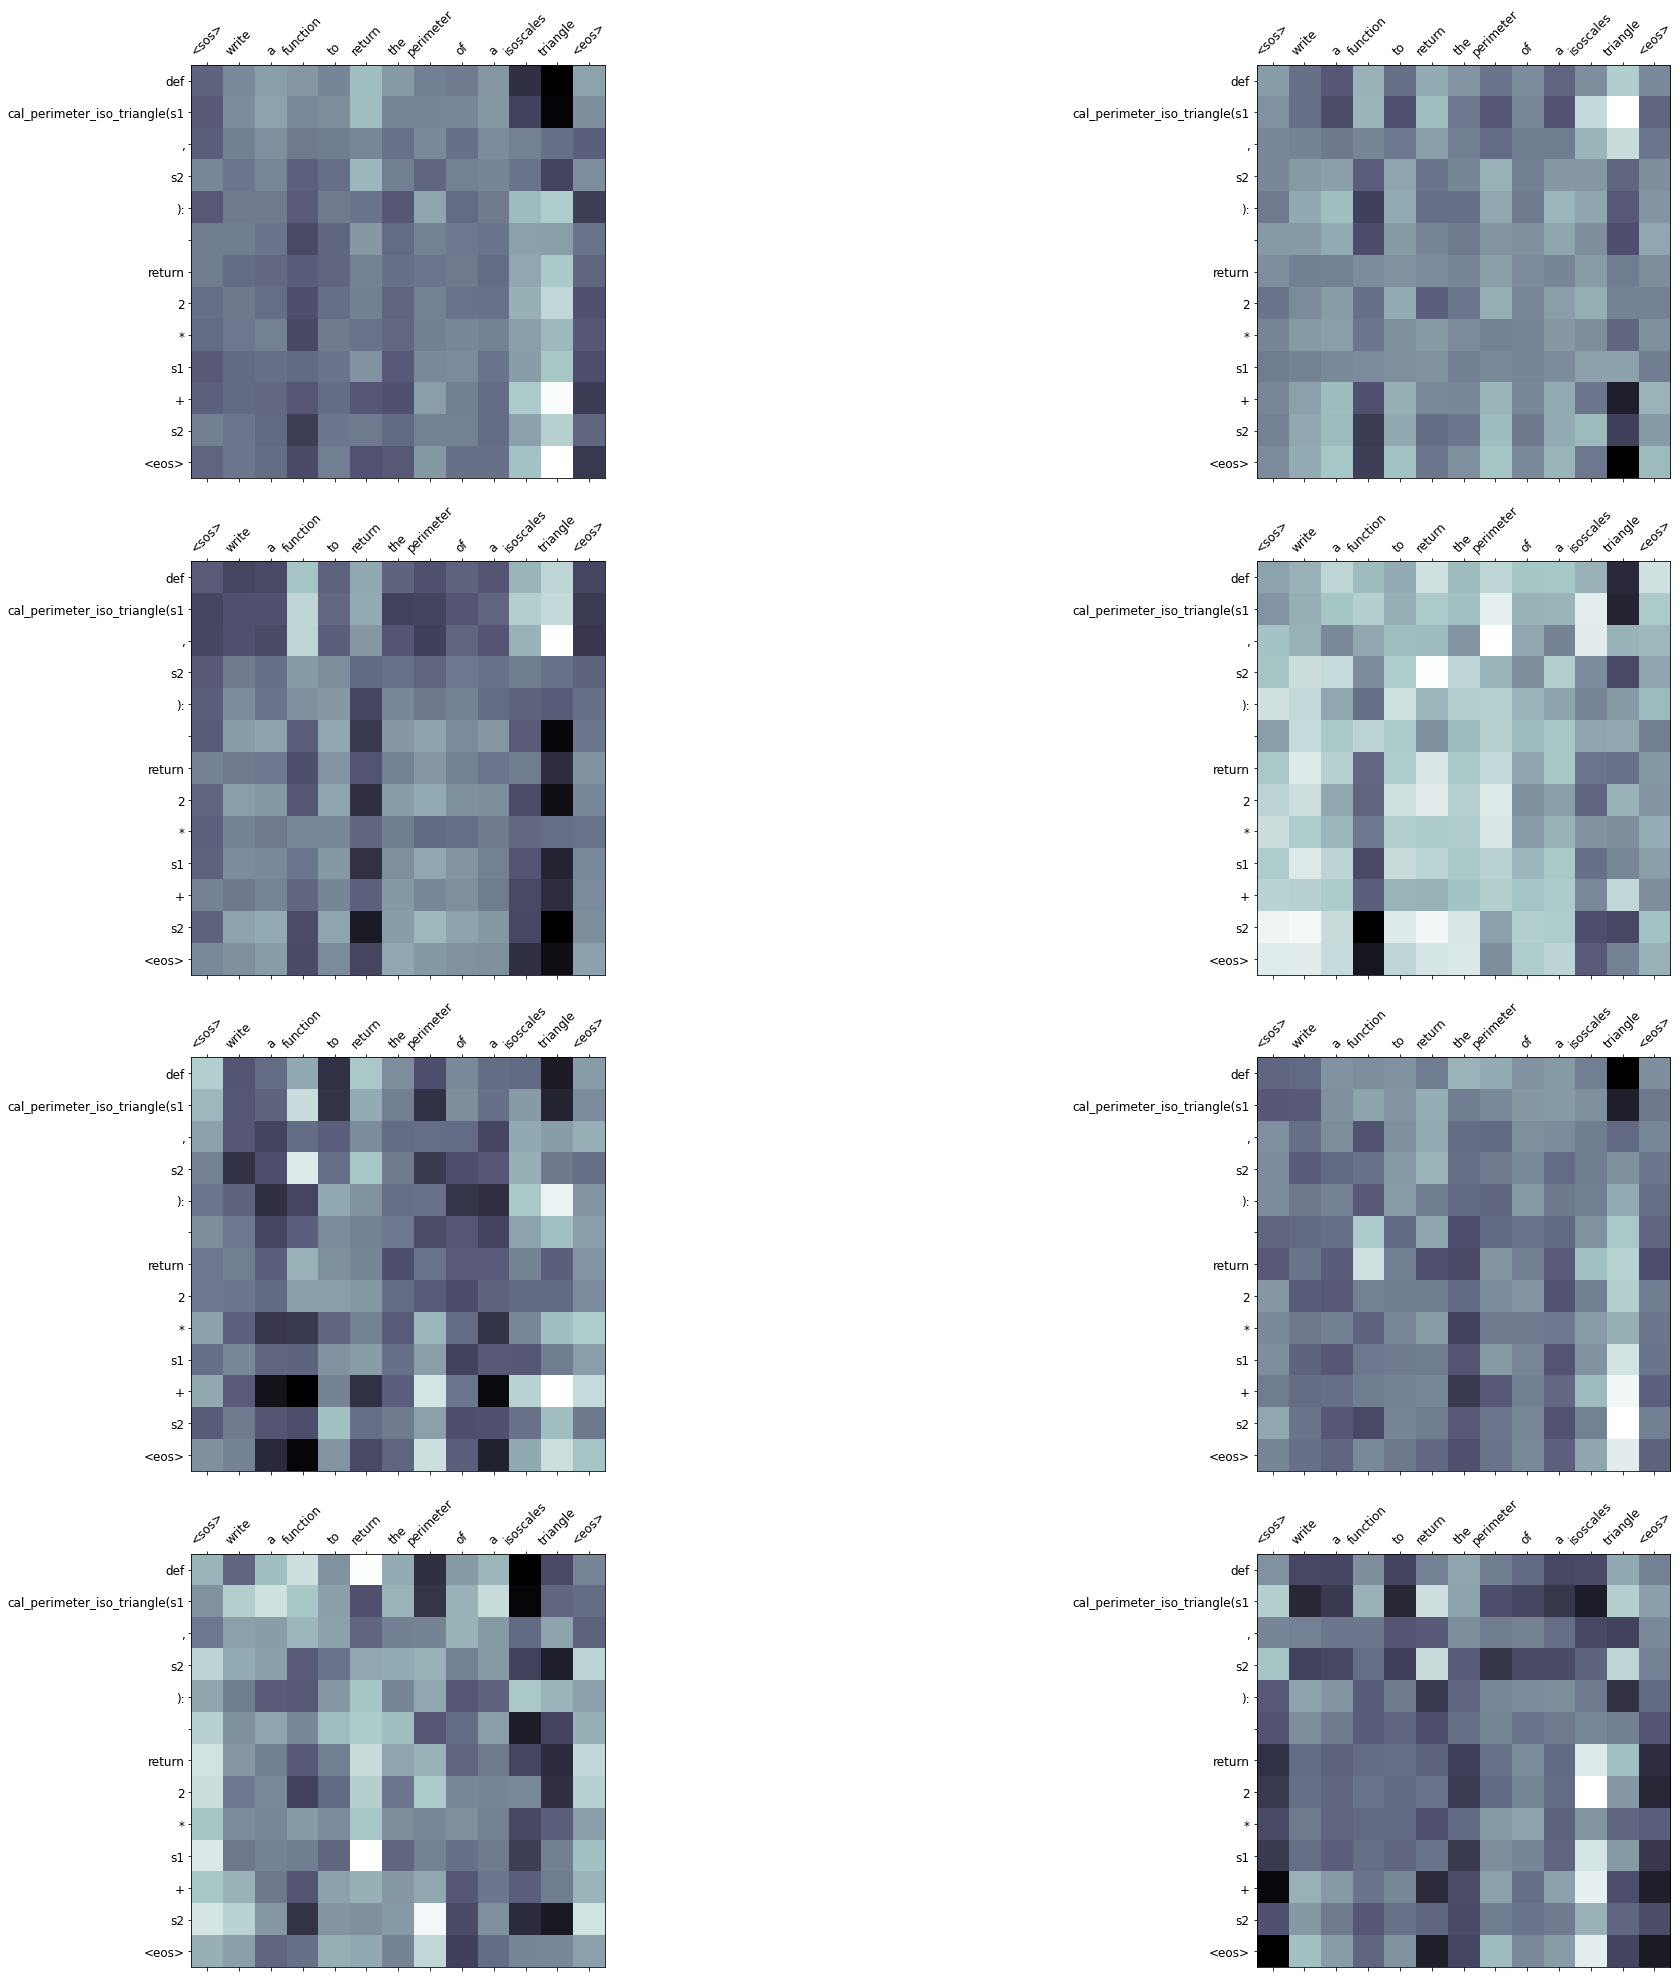

In [83]:
sentence = "write a function to return the perimeter of a isoscales triangle"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)
#Model cand depict relationship between triangle and cal_perimeter_iso_triangle

Generated Code by Model:
def int_to_oct(a ): 
     return oct(a ) 


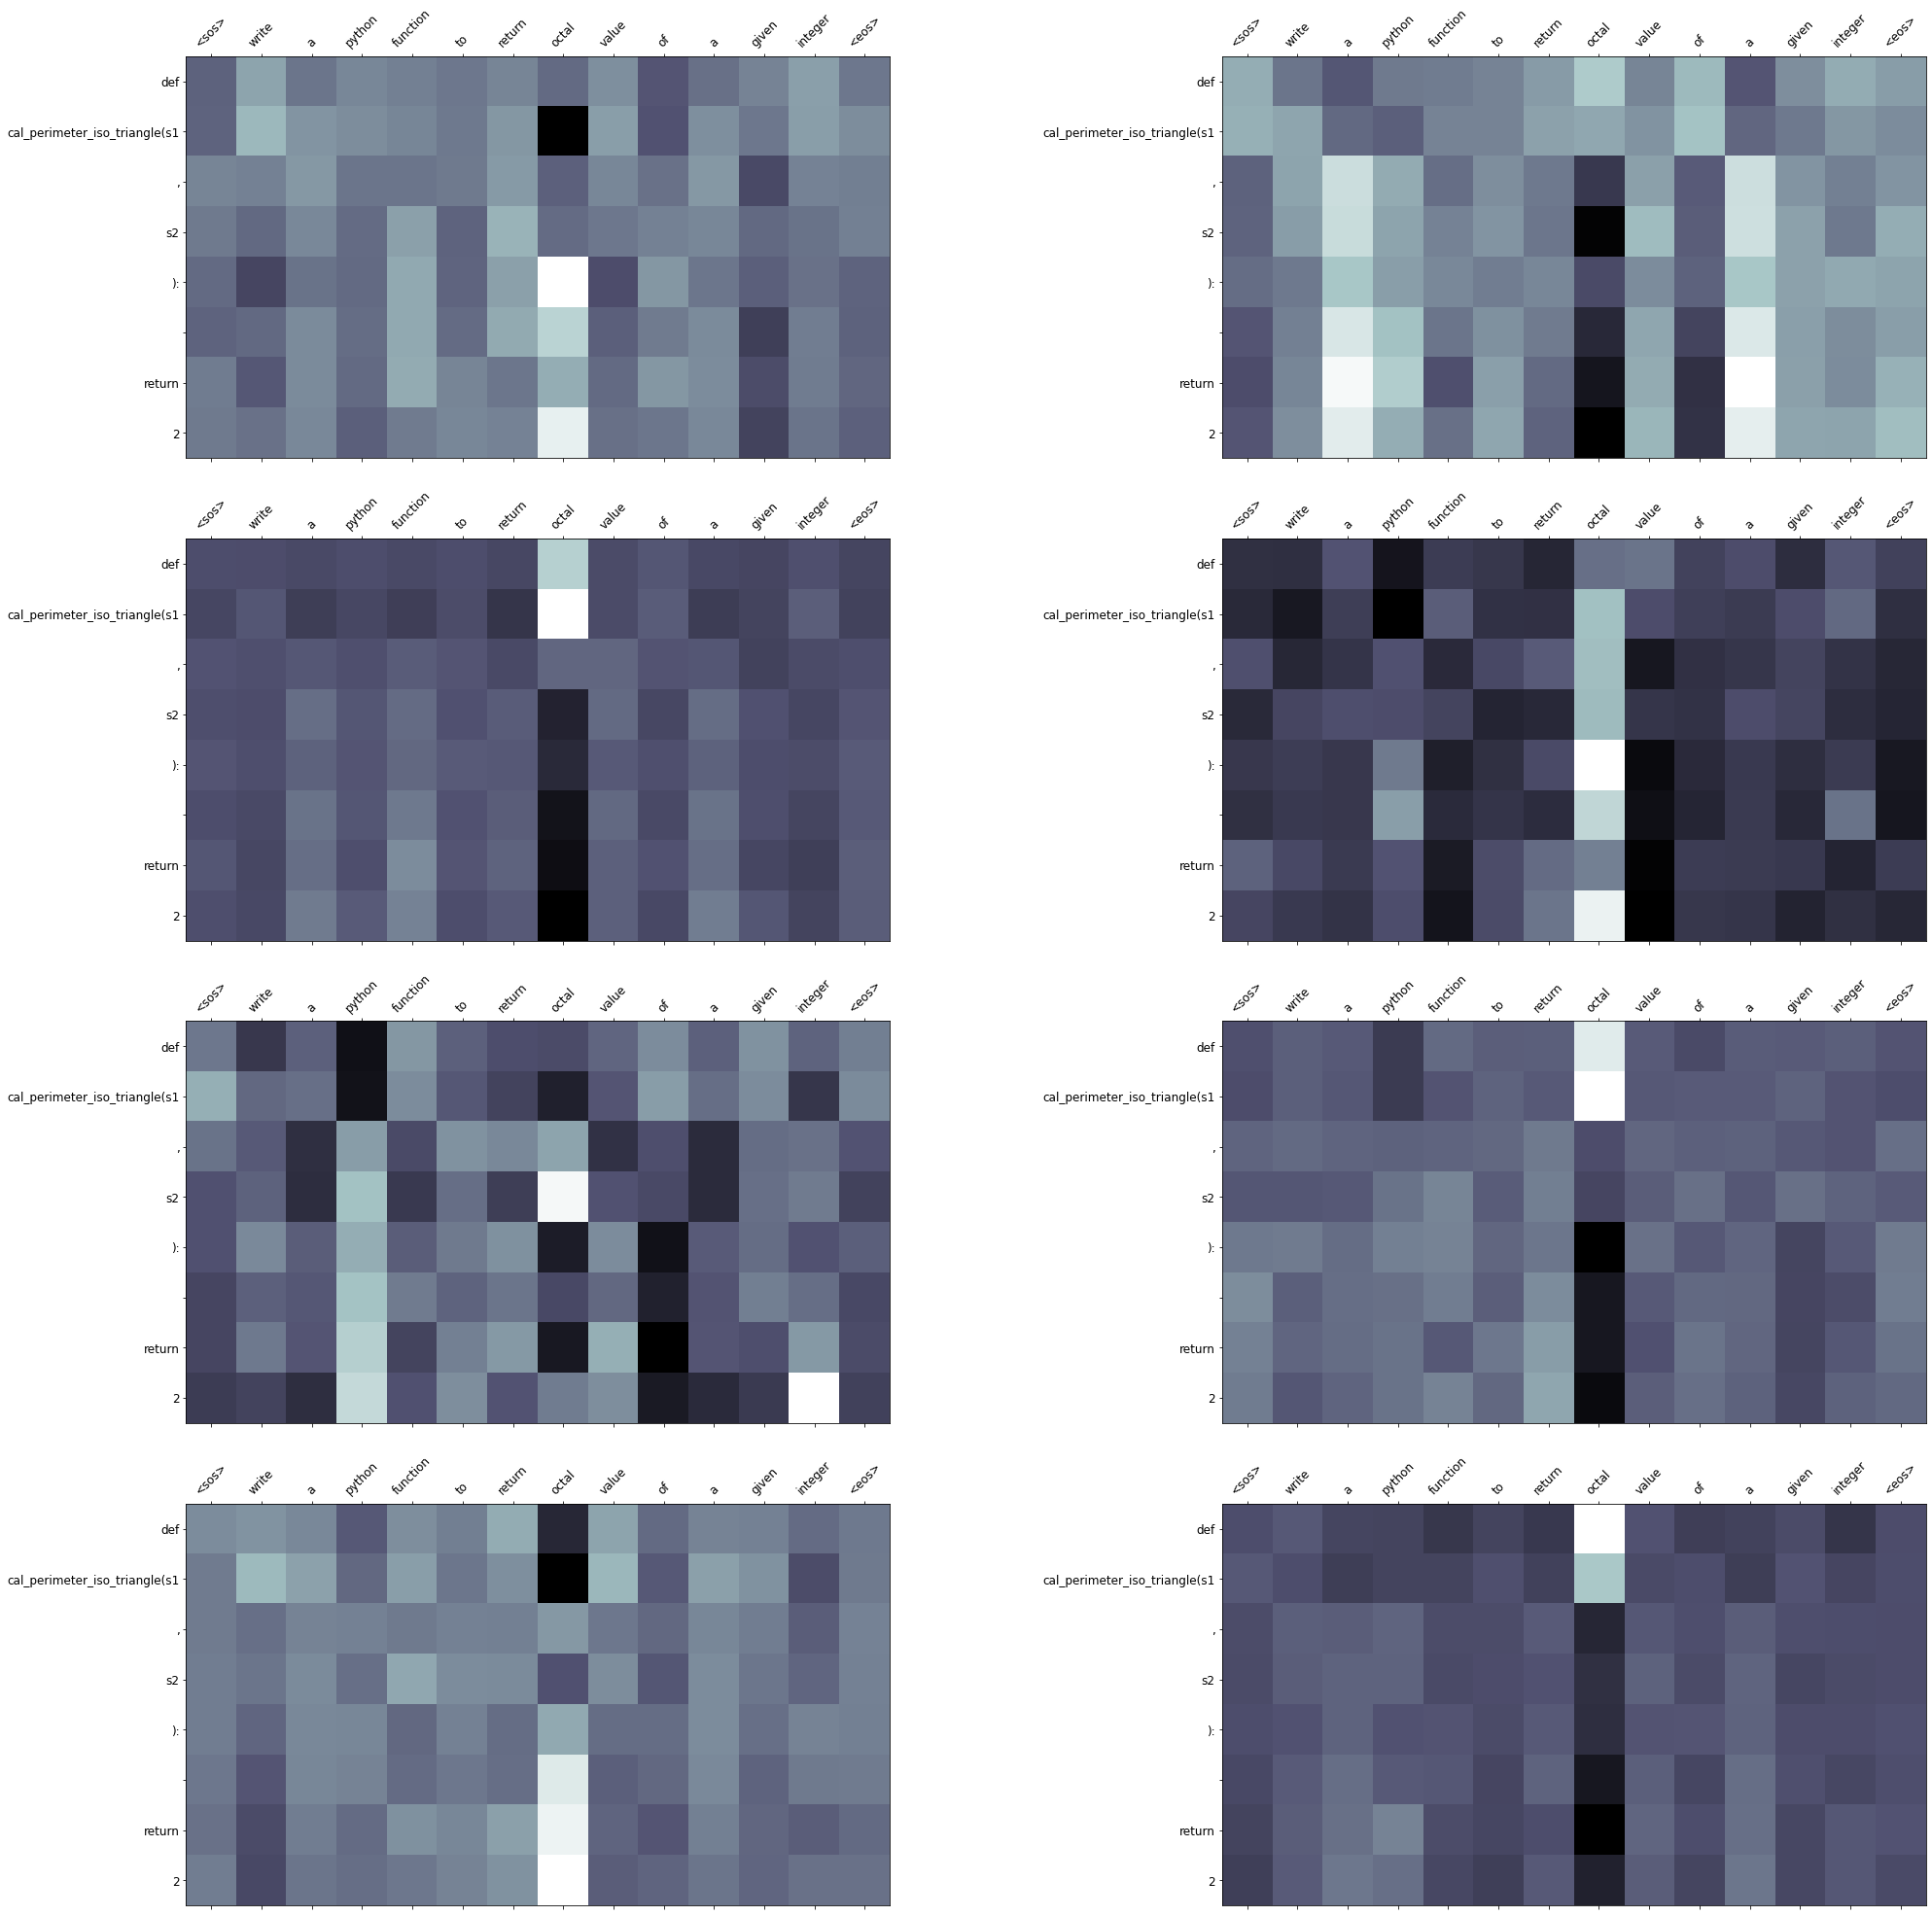

In [87]:
sentence = "write a python function to return octal value of a given integer"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:


 def factorial(n ): 
     if n = = 1 : 
         return 1 
     else : 
         return n * factorial(n - 1 ) 


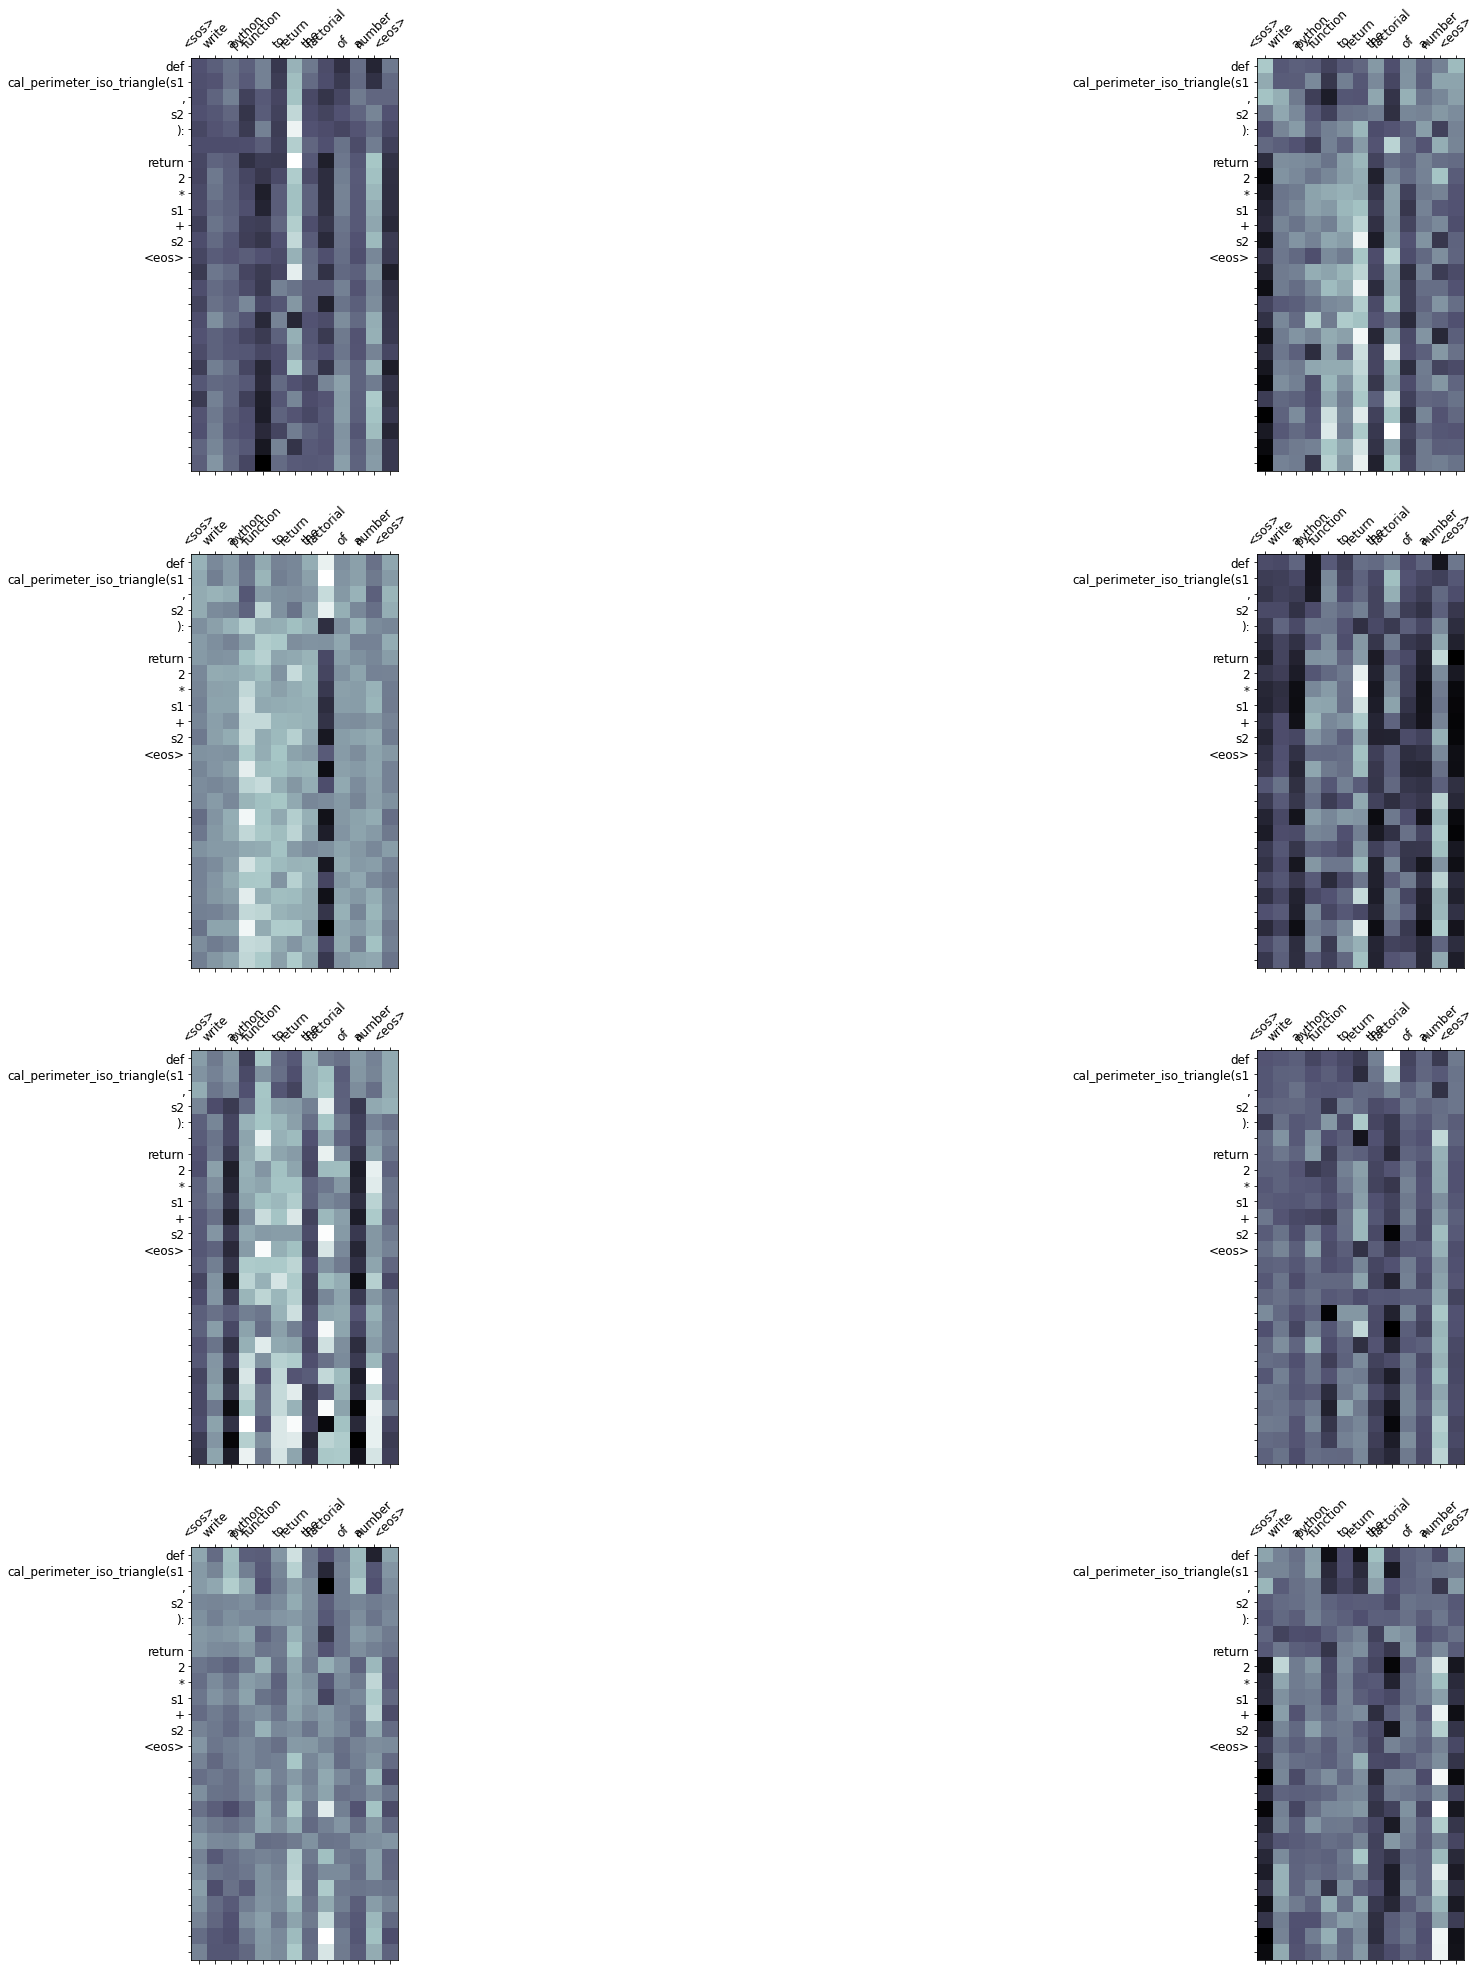

In [88]:
sentence = "write a python function to return the factorial of a number"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
def multiplyList(myList ): 
     result = 1 
     for x in myList : 
         result = result * x 
     return result 


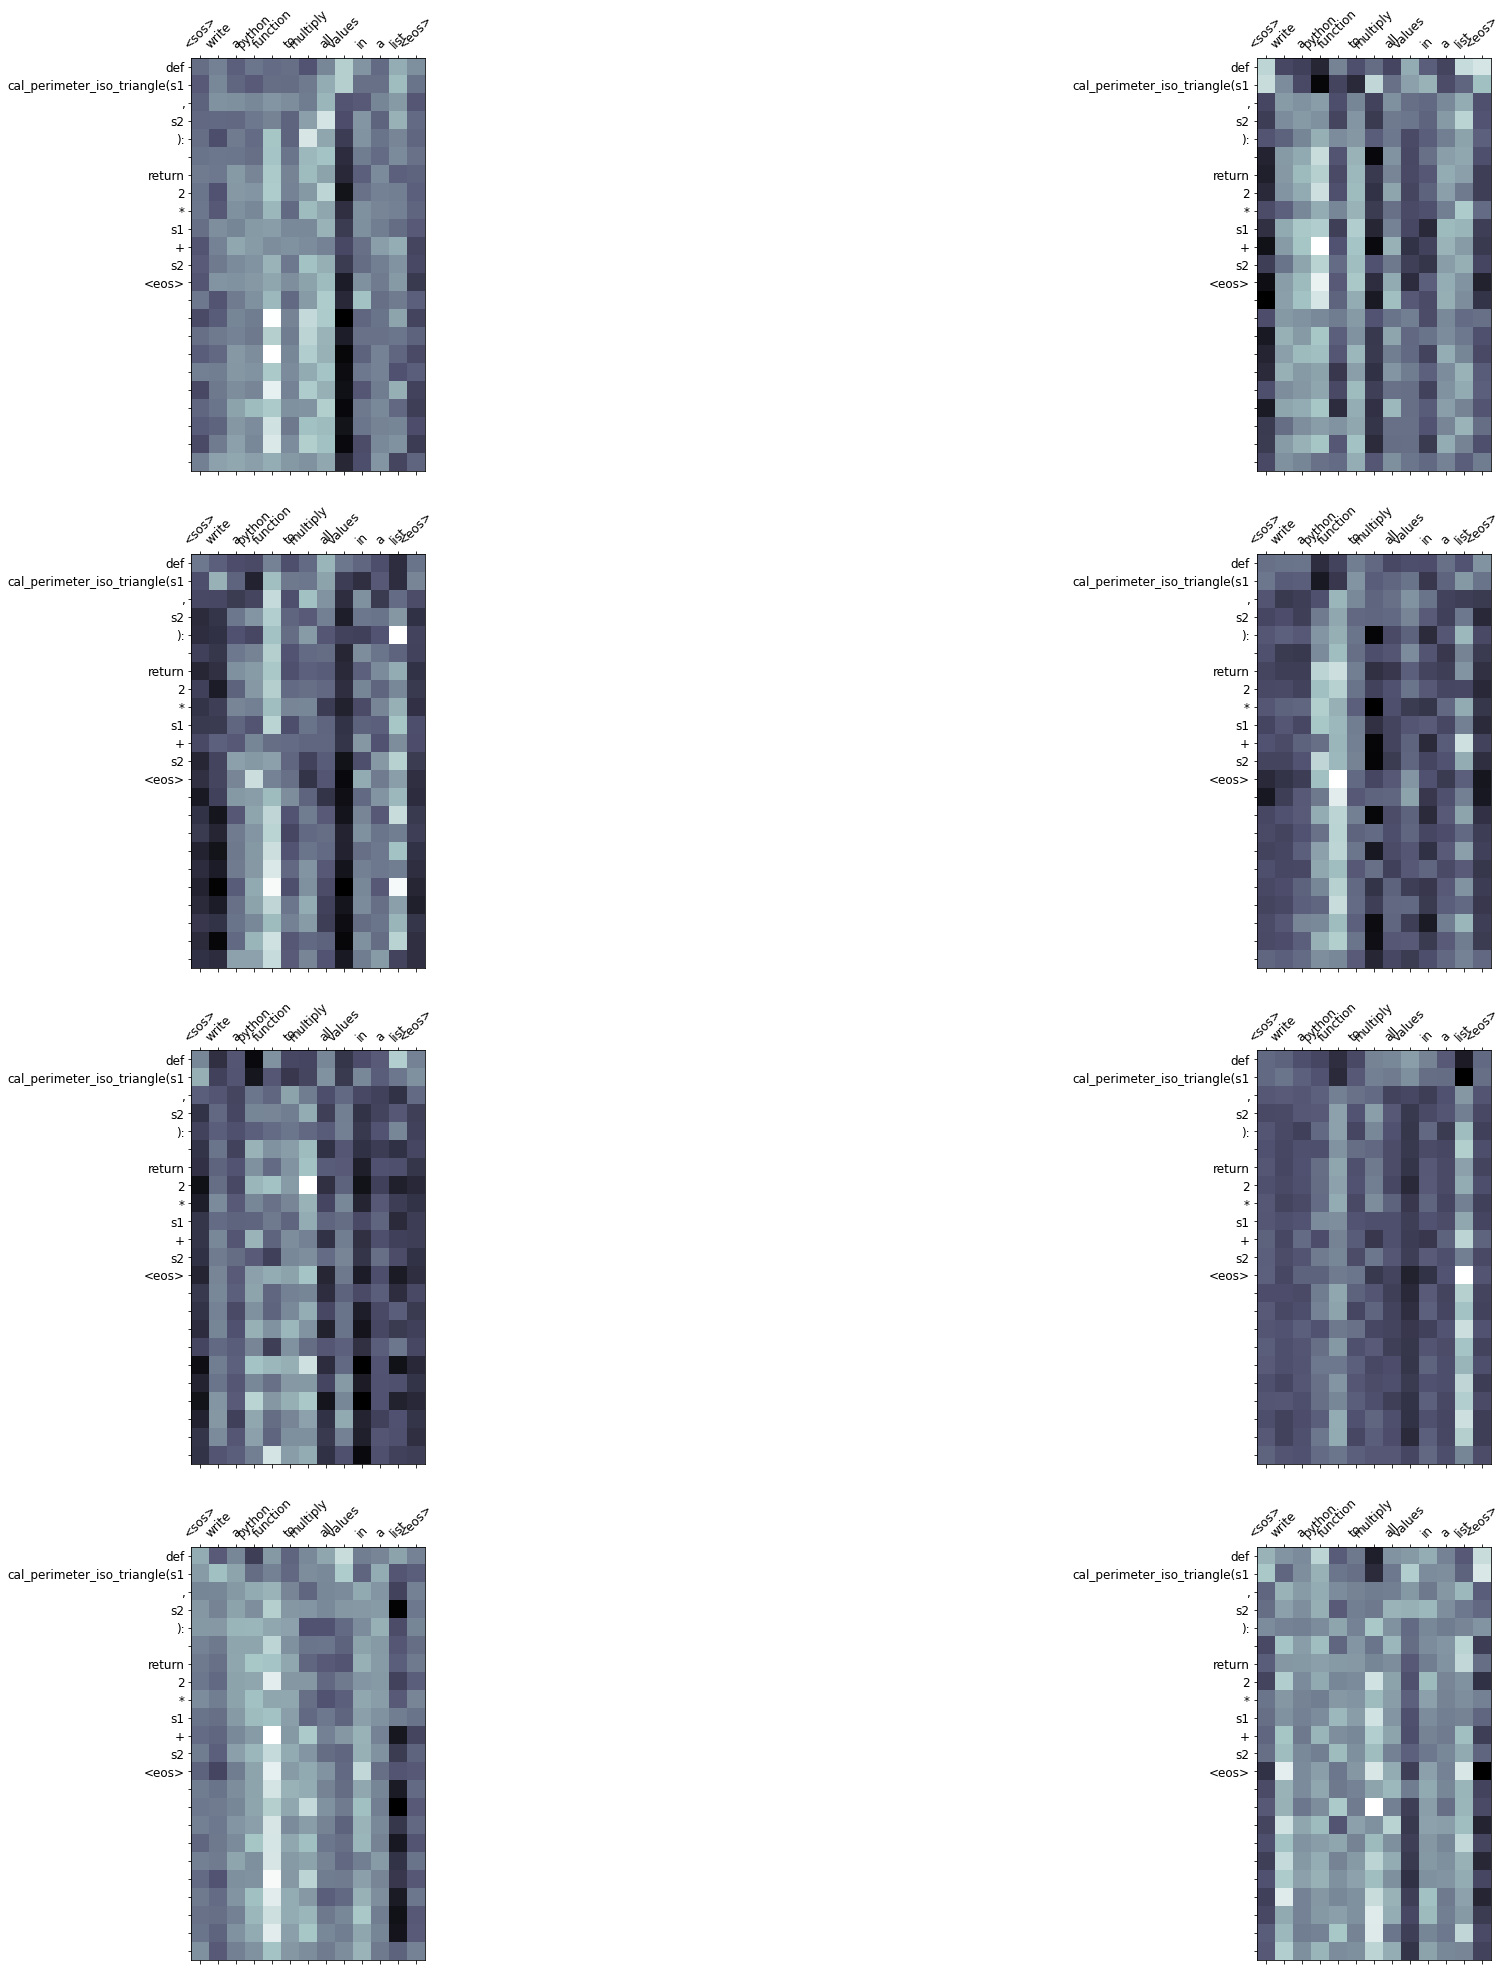

In [84]:
sentence = "write a python function to multiply all values in a list"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
num1 = 1.5 
 num2 = 6.3 
 sum = num1 + num2 
 print(f'Sum : { sum } ' ) 


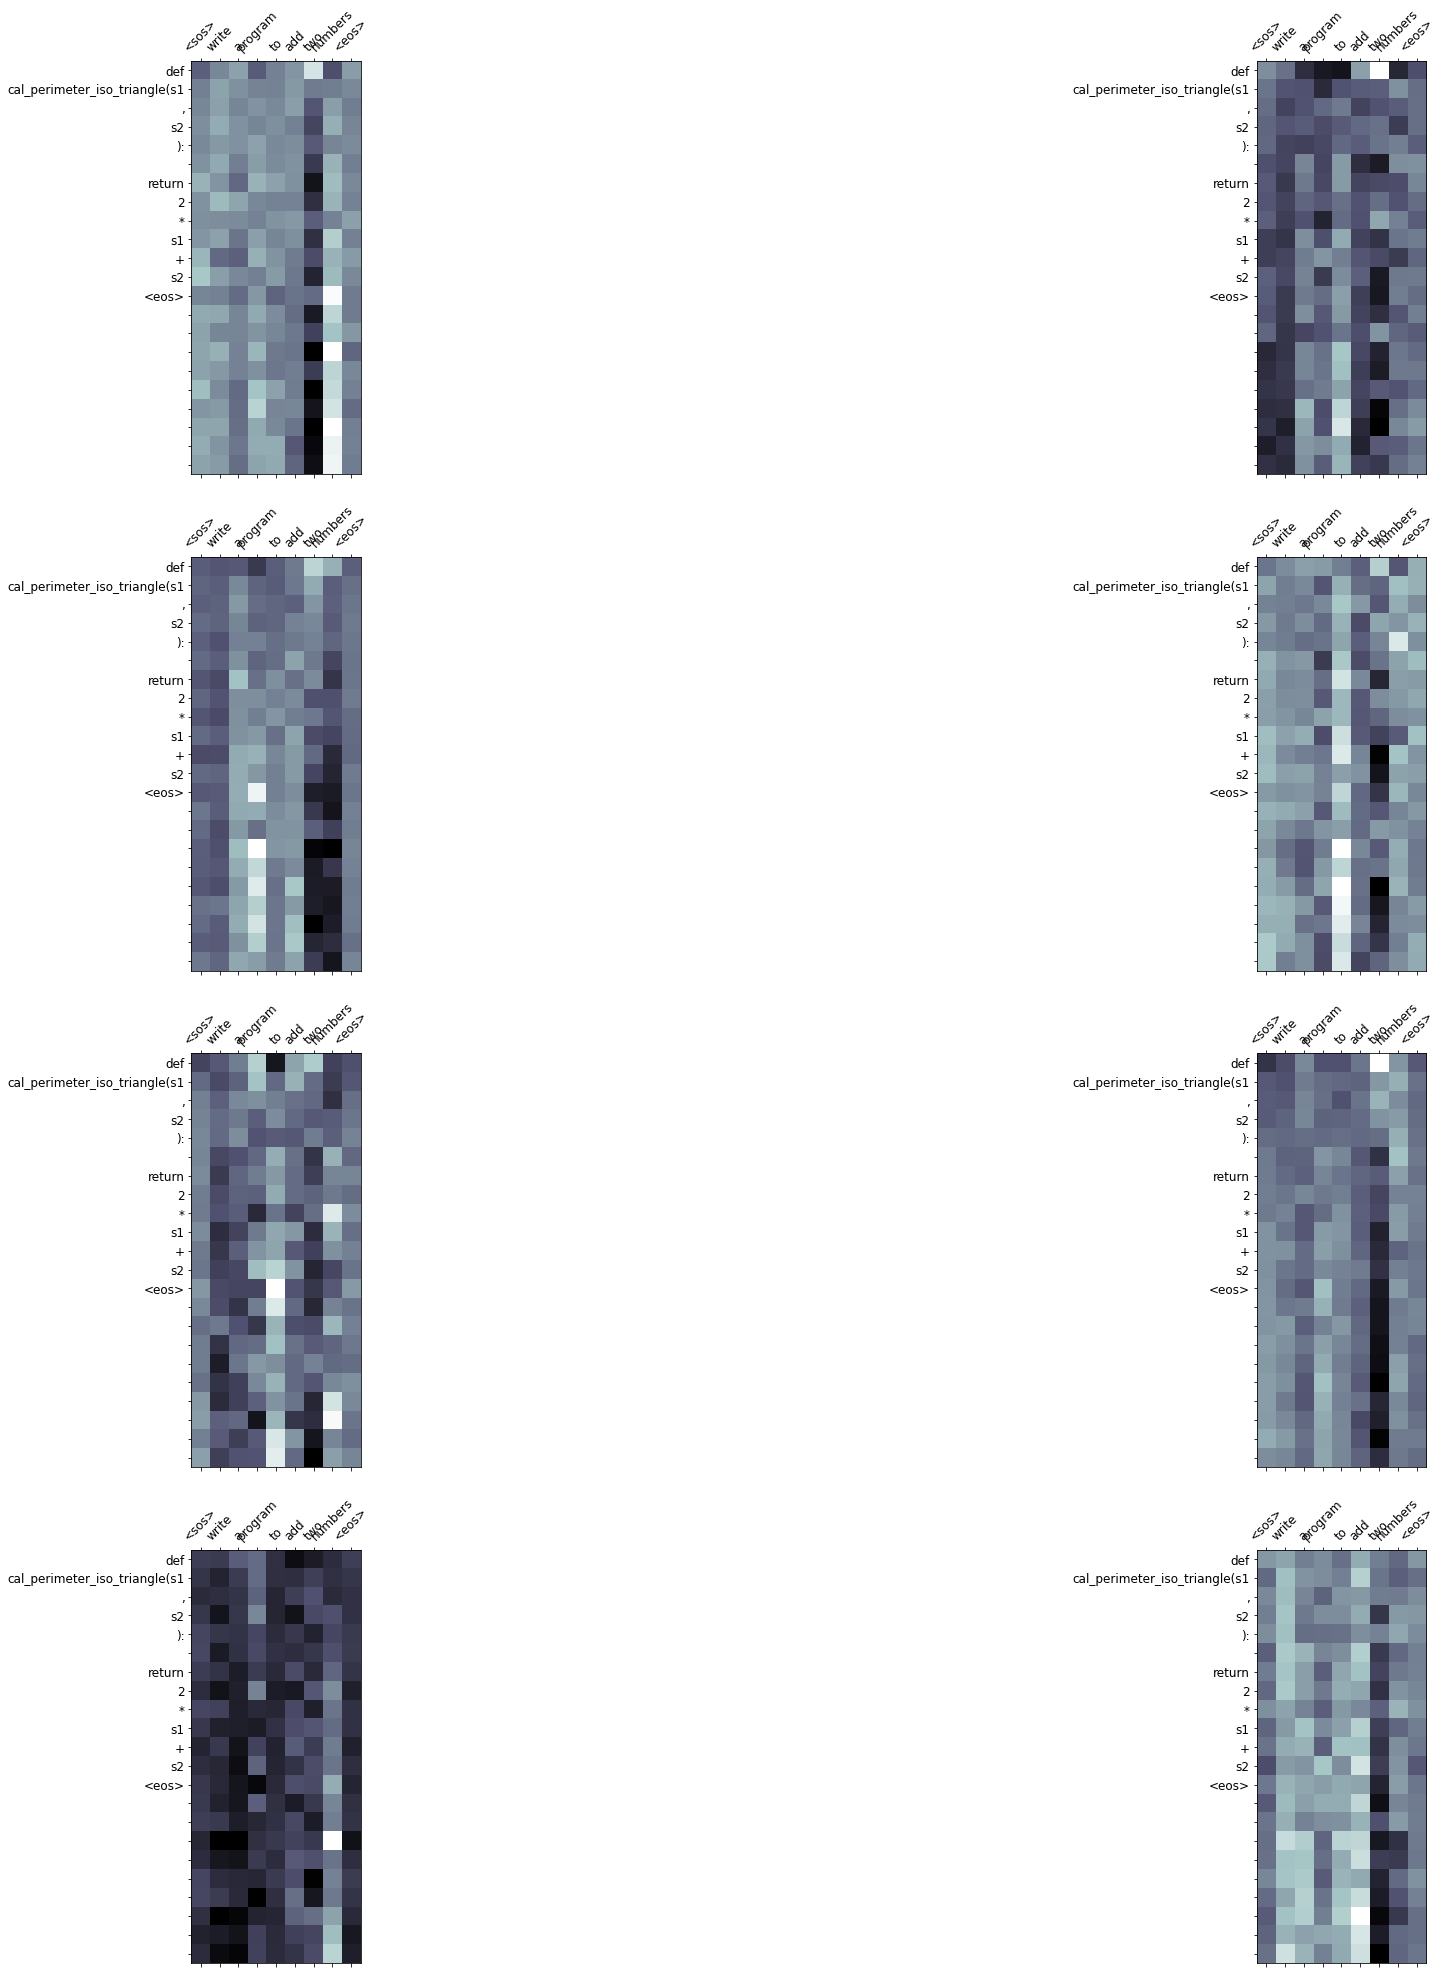

In [85]:
sentence = "write a program to add two numbers"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Model is able show attention between number and num1

Generated Code by Model:
num1 = 1.5 
 num2 = 6.3 
 product = num1 * num2 * num2 
 print(f'Sum : { product } ' ) 


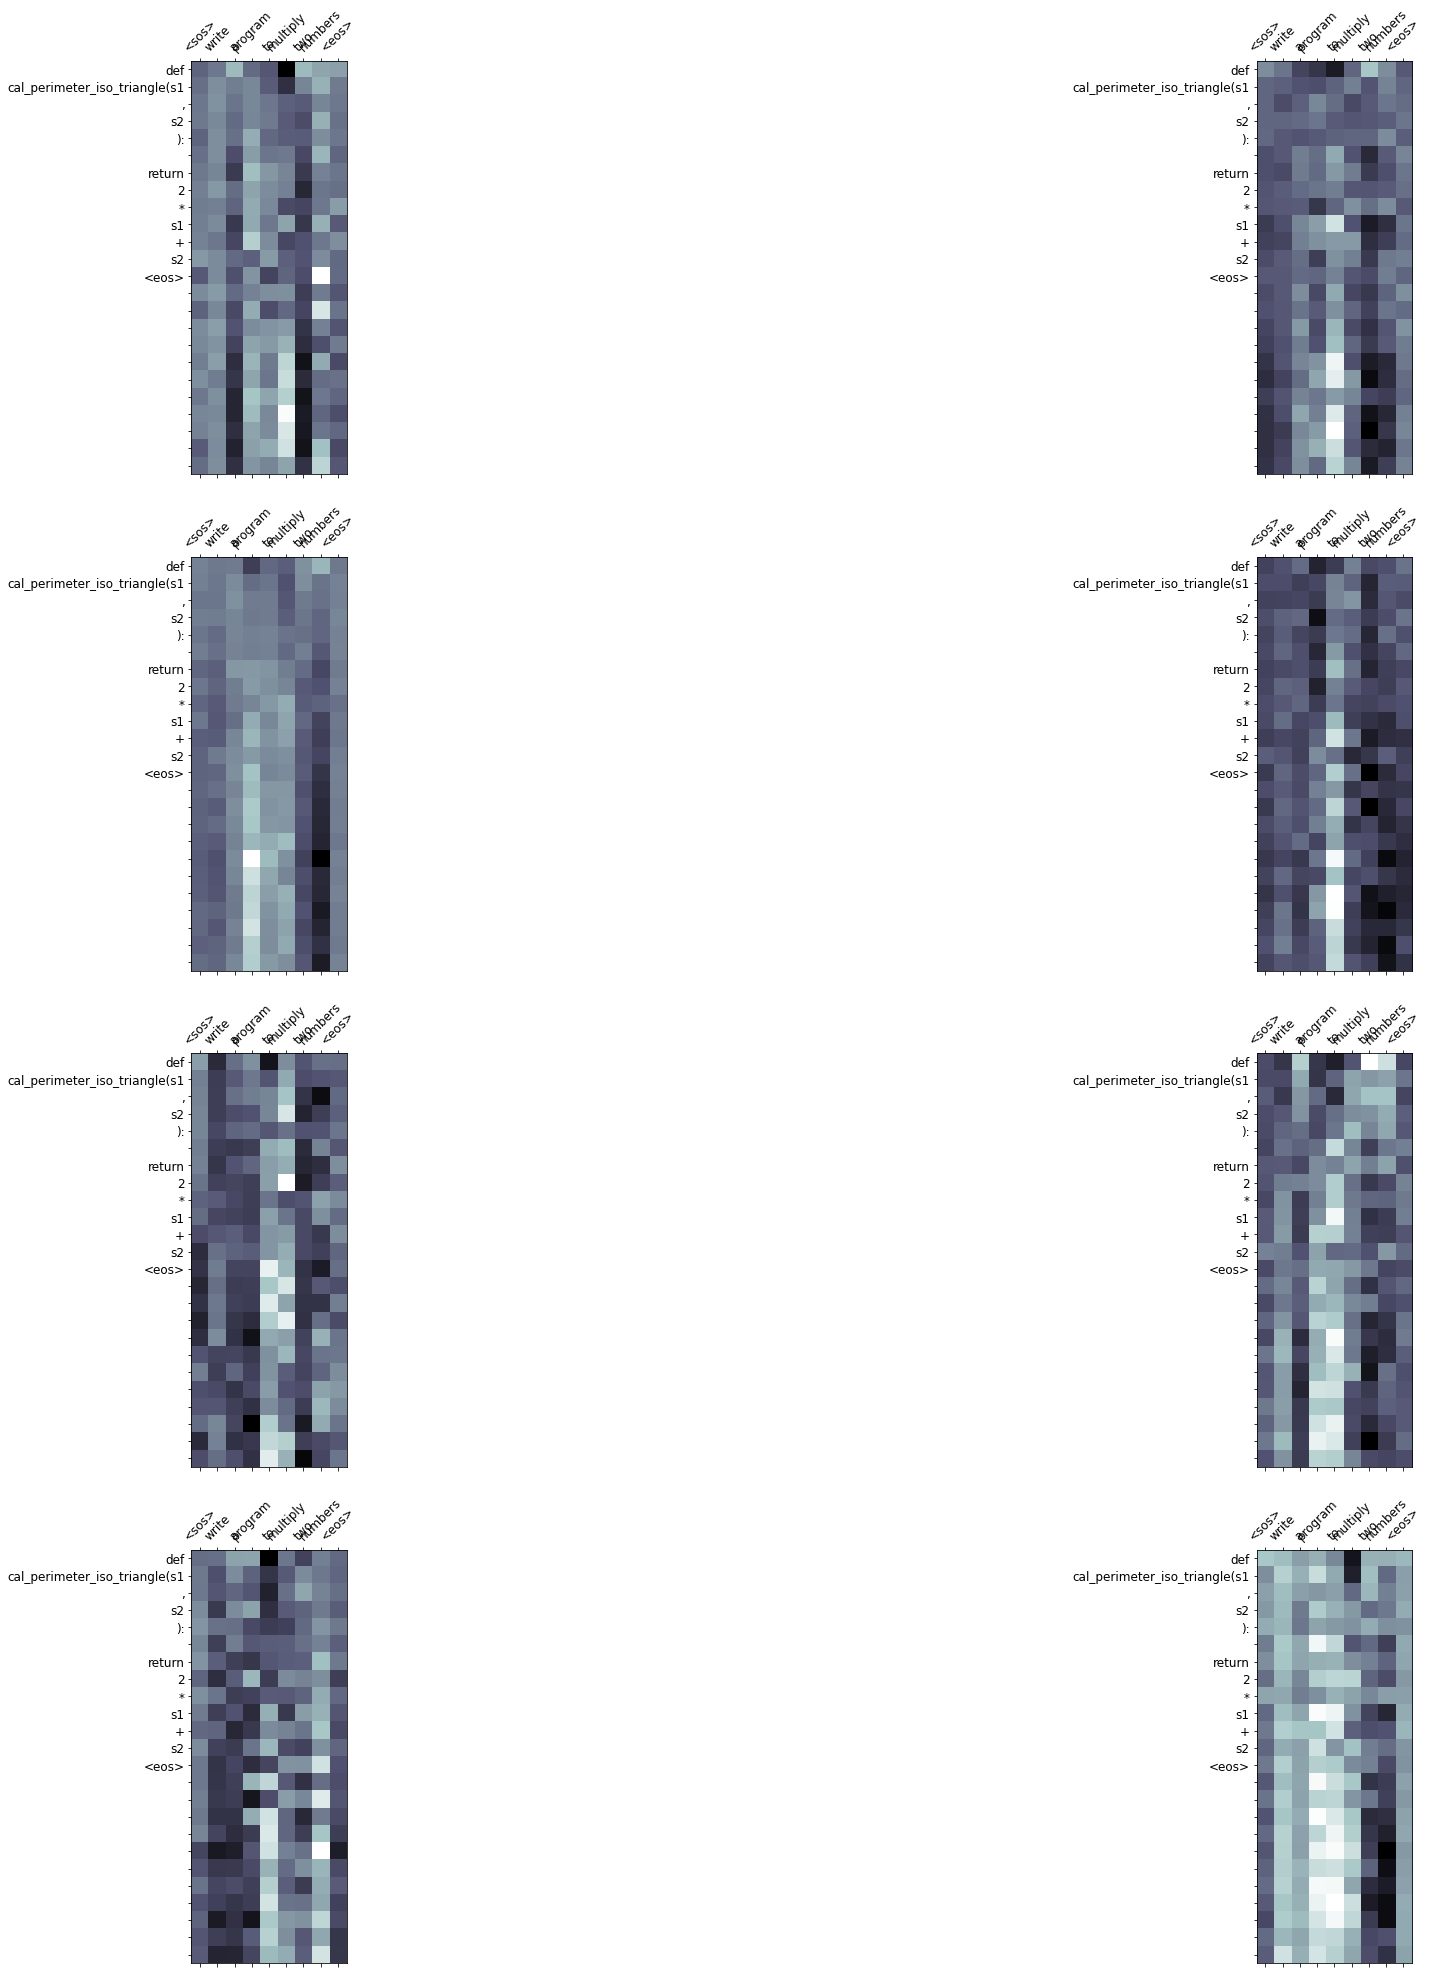

In [86]:
sentence = "write a program to multiply two numbers"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
def cal_mi_ring(mass : float , radius : float ) - > float : 
     return mass * ( radius**2 ) 


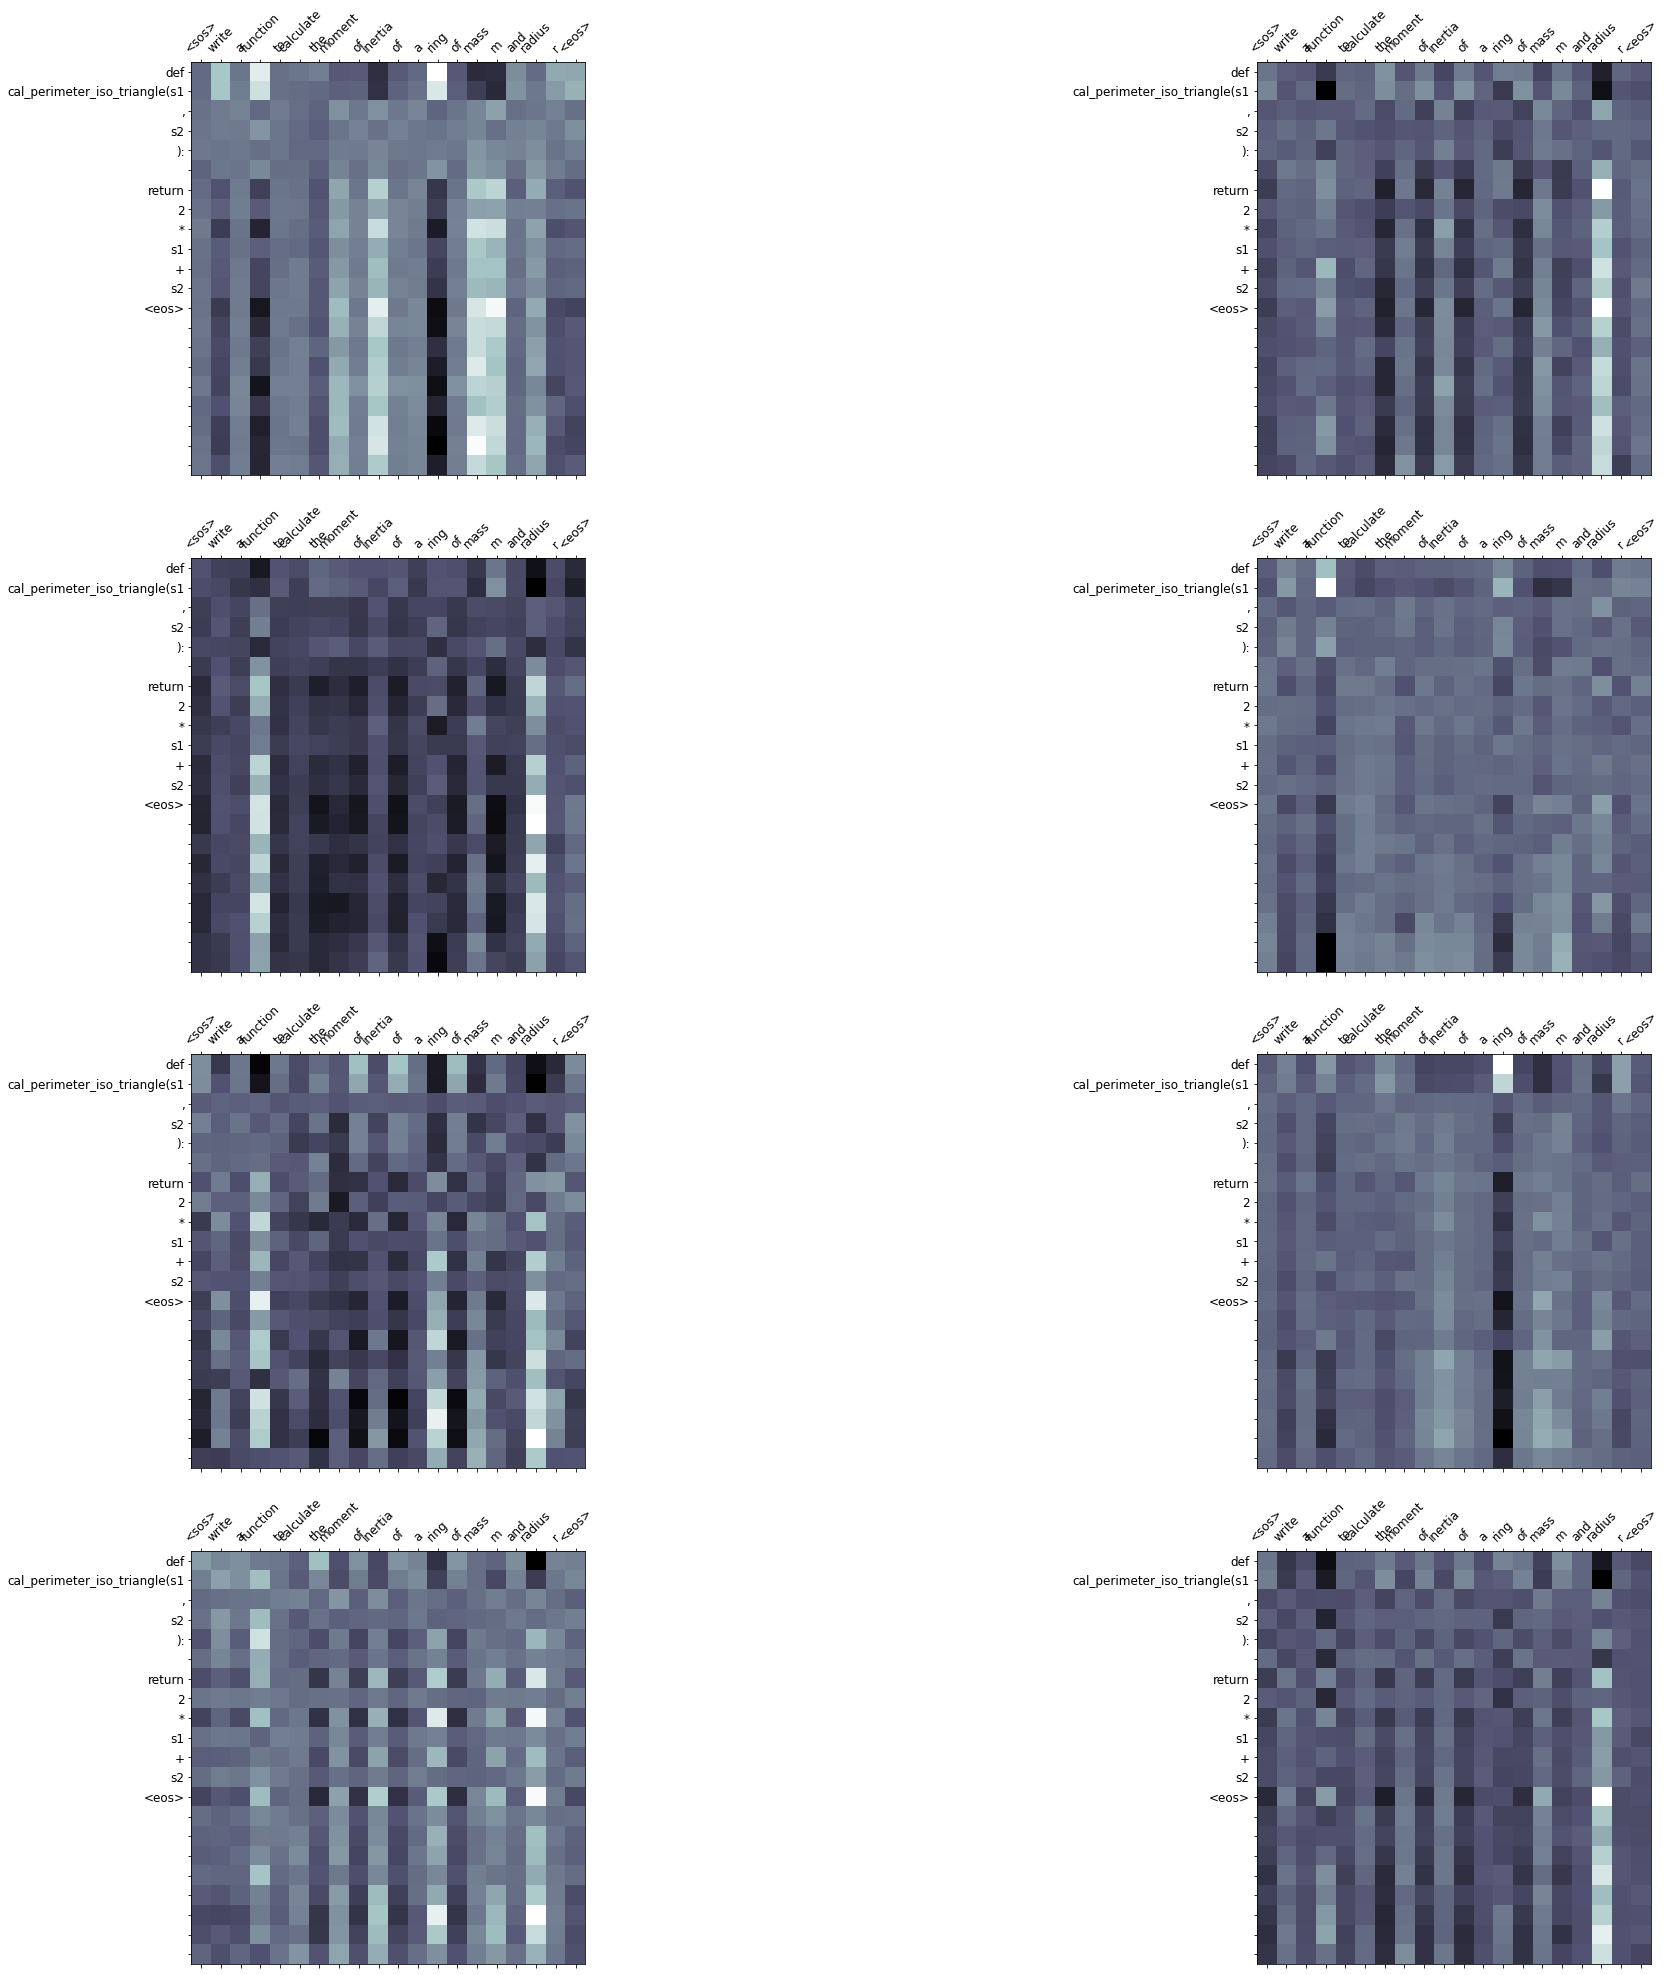

In [89]:
sentence="write a function to calculate the moment of inertia of a ring of mass m and radius r"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
def derivative_exp(x : float ) - > float : 
     import math 
     return math.exp(x ) 


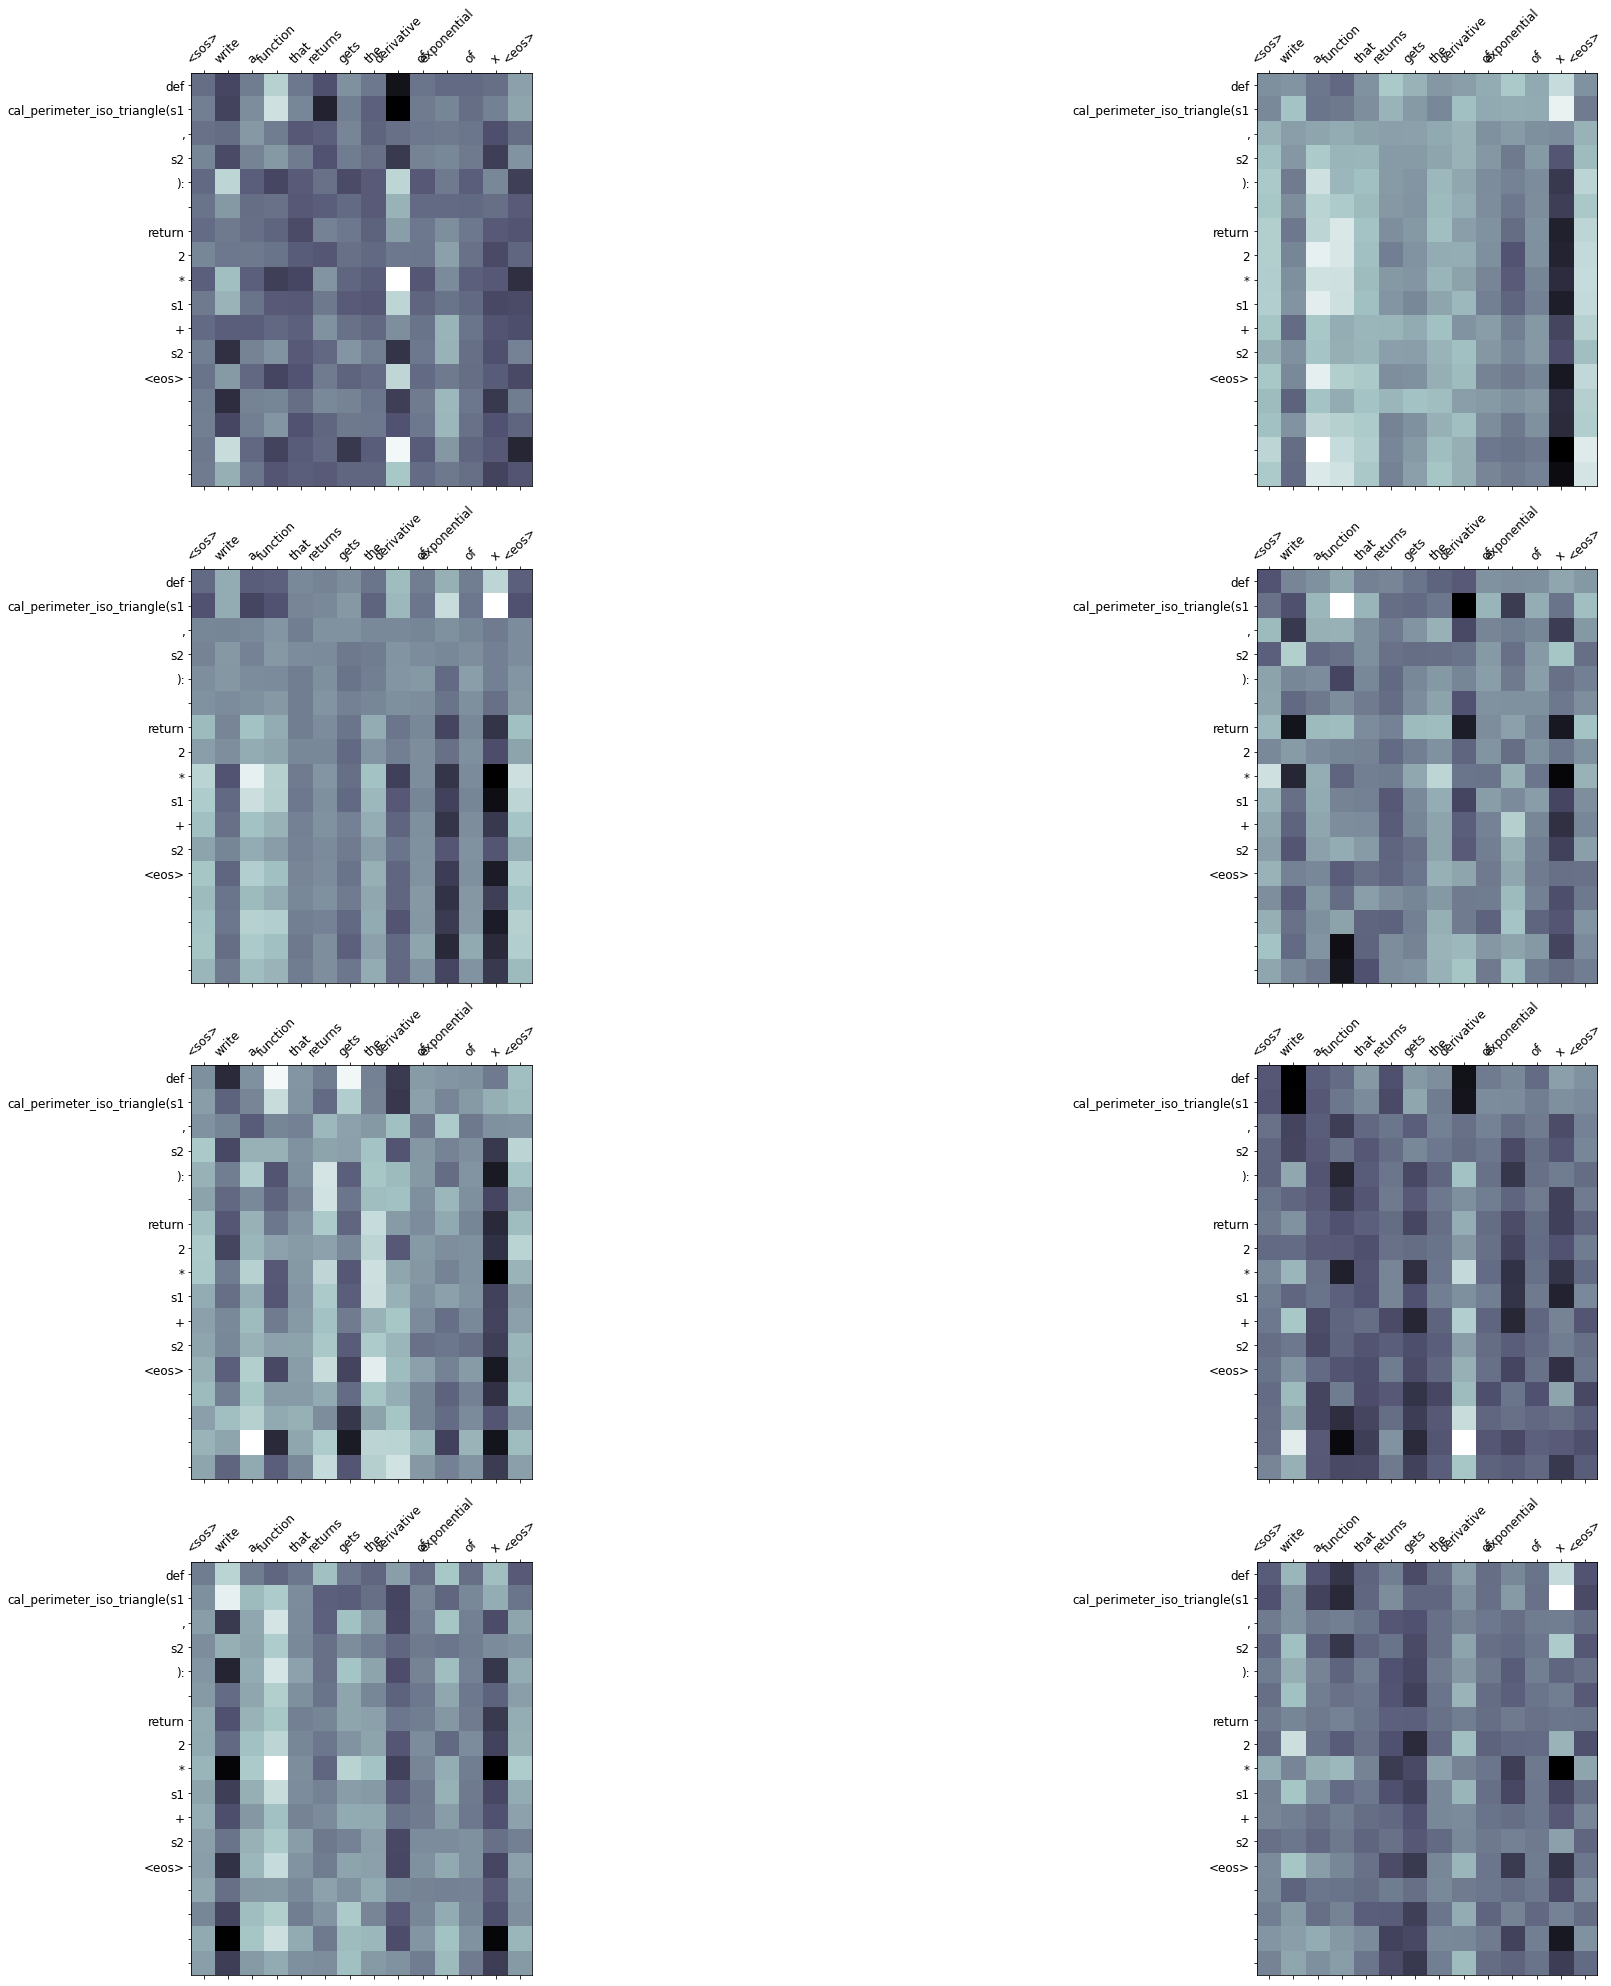

In [90]:
sentence="write a function that returns gets the derivative of exponential of x"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
def Cumulative(lists ): 
     cu_list = [ ] 
     length = len(lists ) 
     cu_list = [ sum(lists[0 : x:1 ] ) for x in range(0 , length + 1 ) ] 
     return cu_list[1 :] 


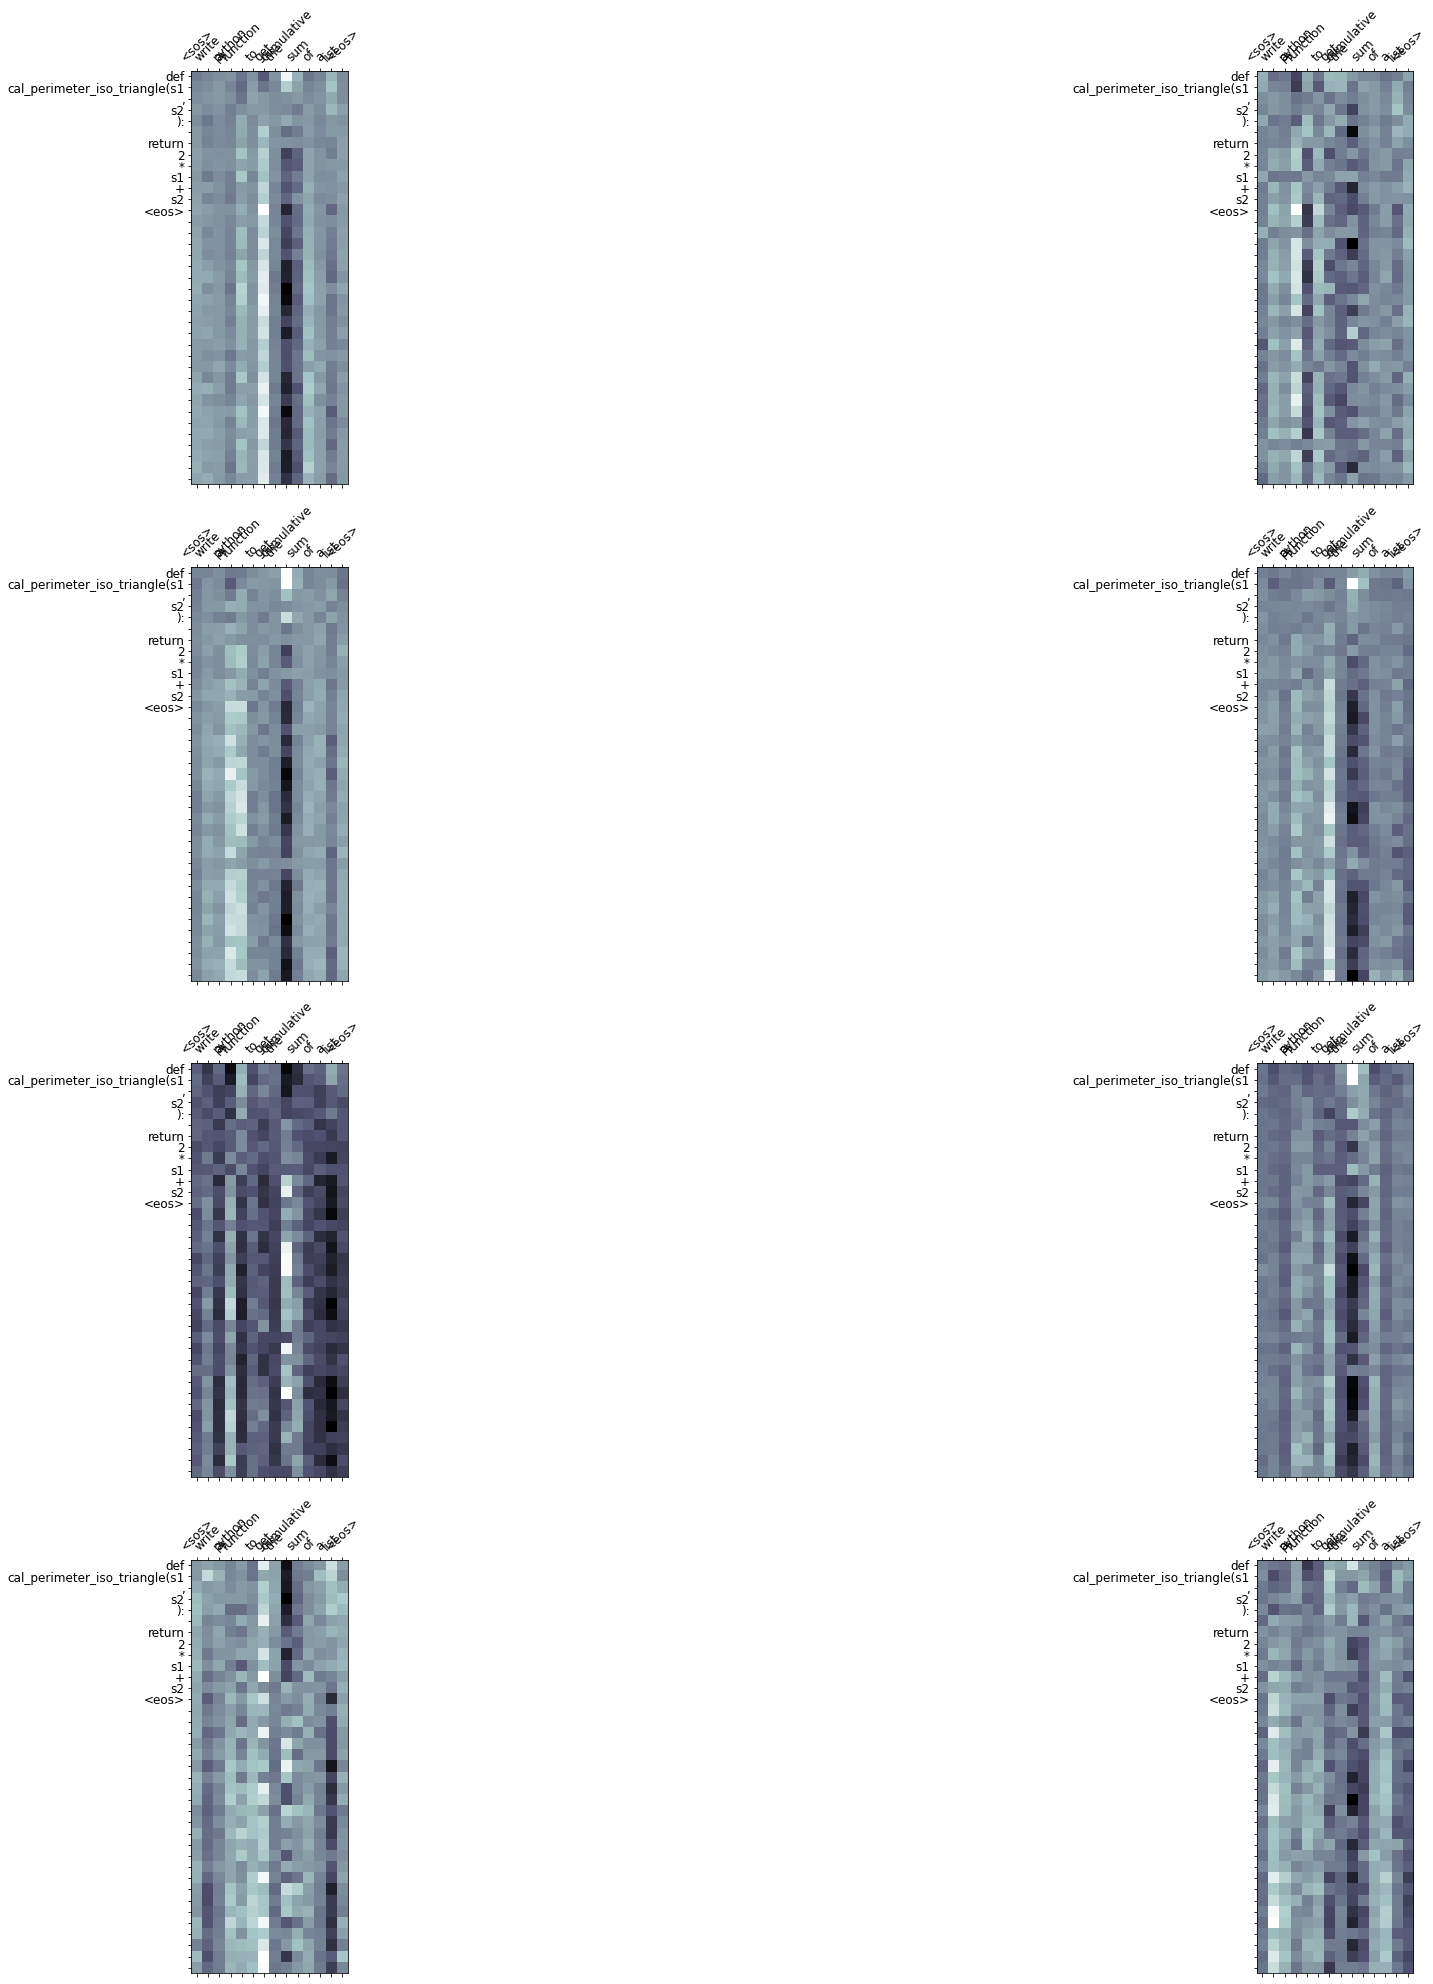

In [91]:
sentence="write a python function to get the cumulative sum of a list"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
a = b , b = b , a 


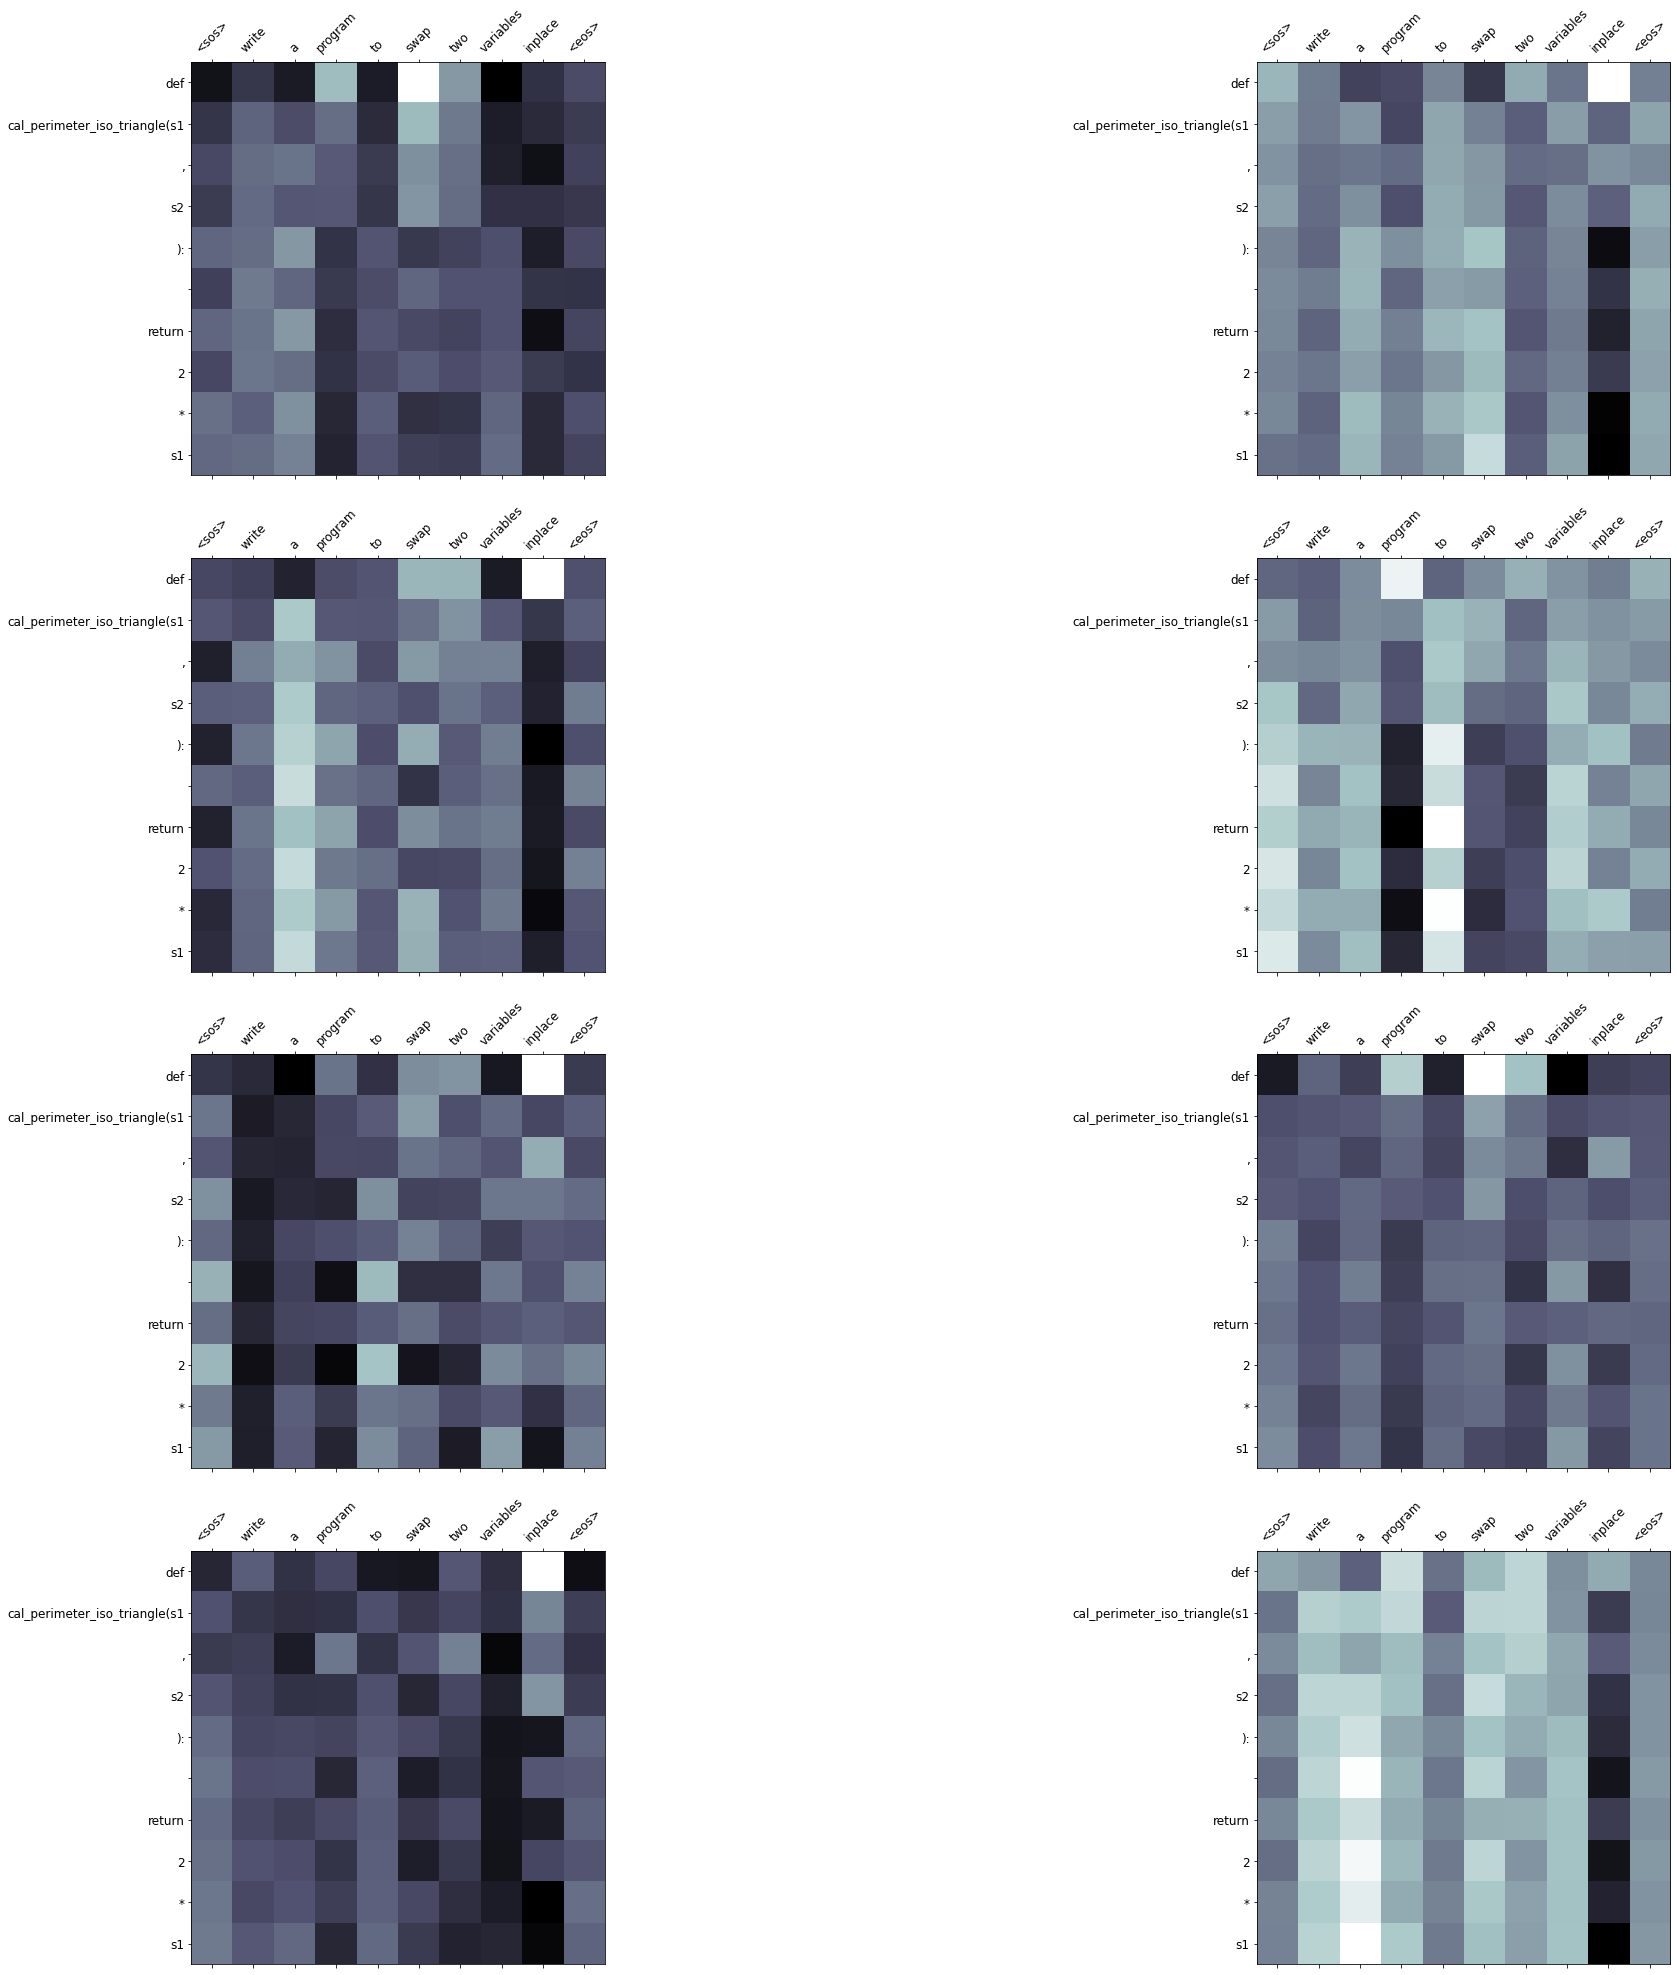

In [92]:
sentence="write a program to swap two variables inplace"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:


 def factorial(n ): 
     if n = = 1 : 
         return 1 
     else : 
         return n * factorial(n - 1 ) 


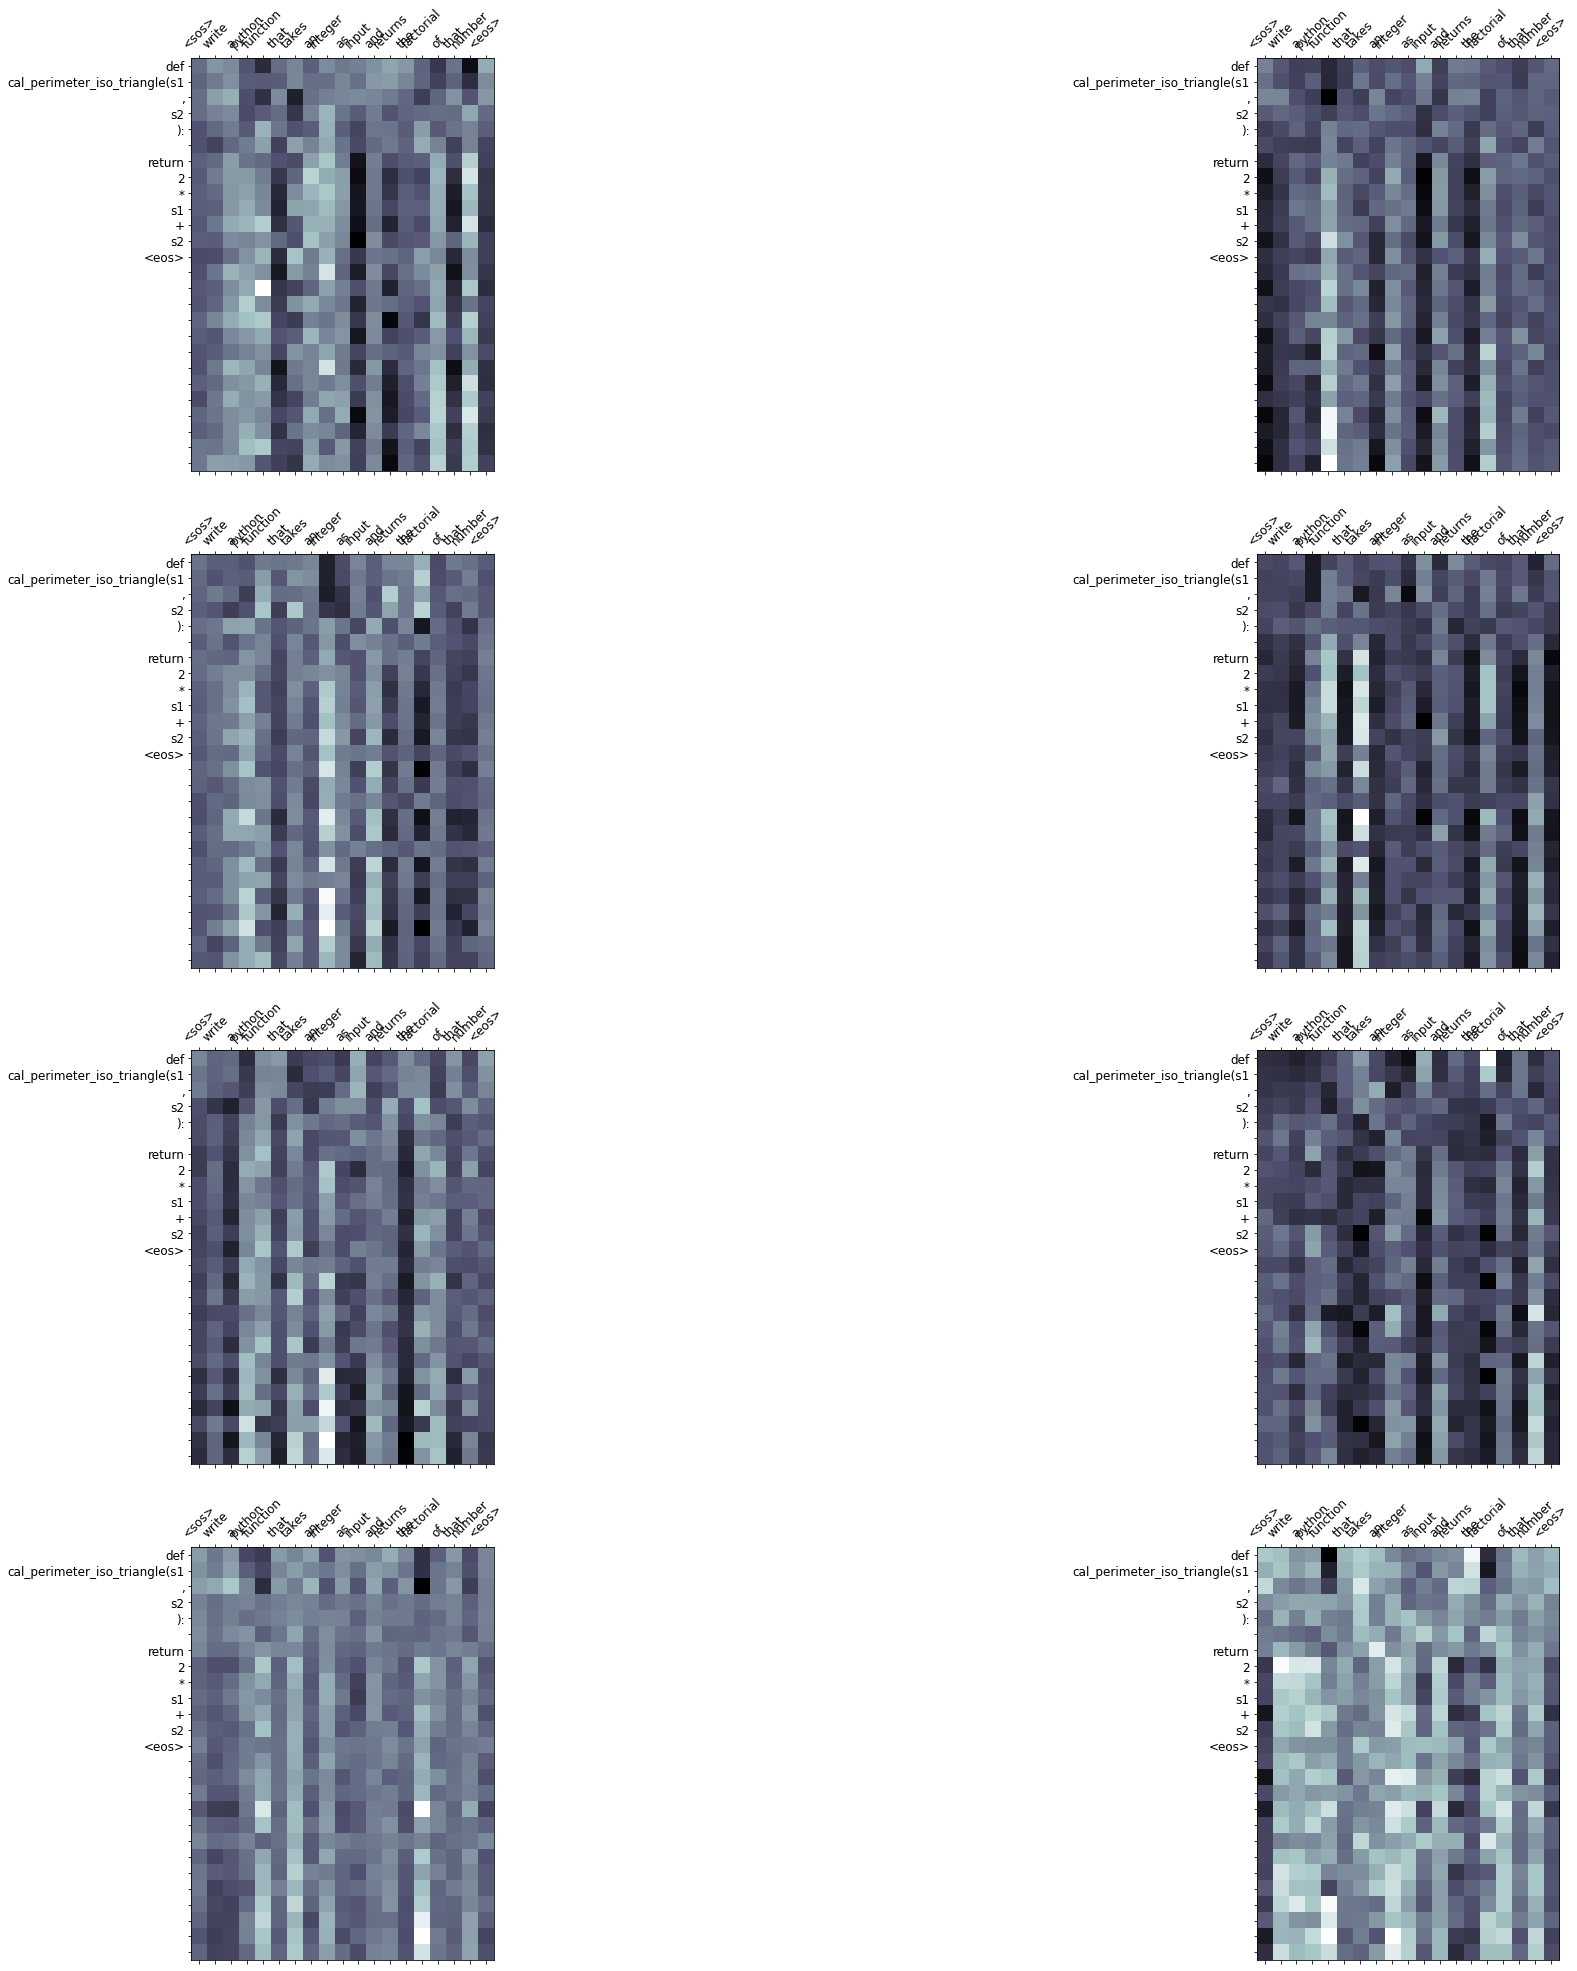

In [93]:
sentence="write a python function that takes an integer as input and returns the factorial of that number"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
def cal_surface_area_cuboid(l , b , h ): 
     return 2 * ( l * b + b * h + h * h + h 


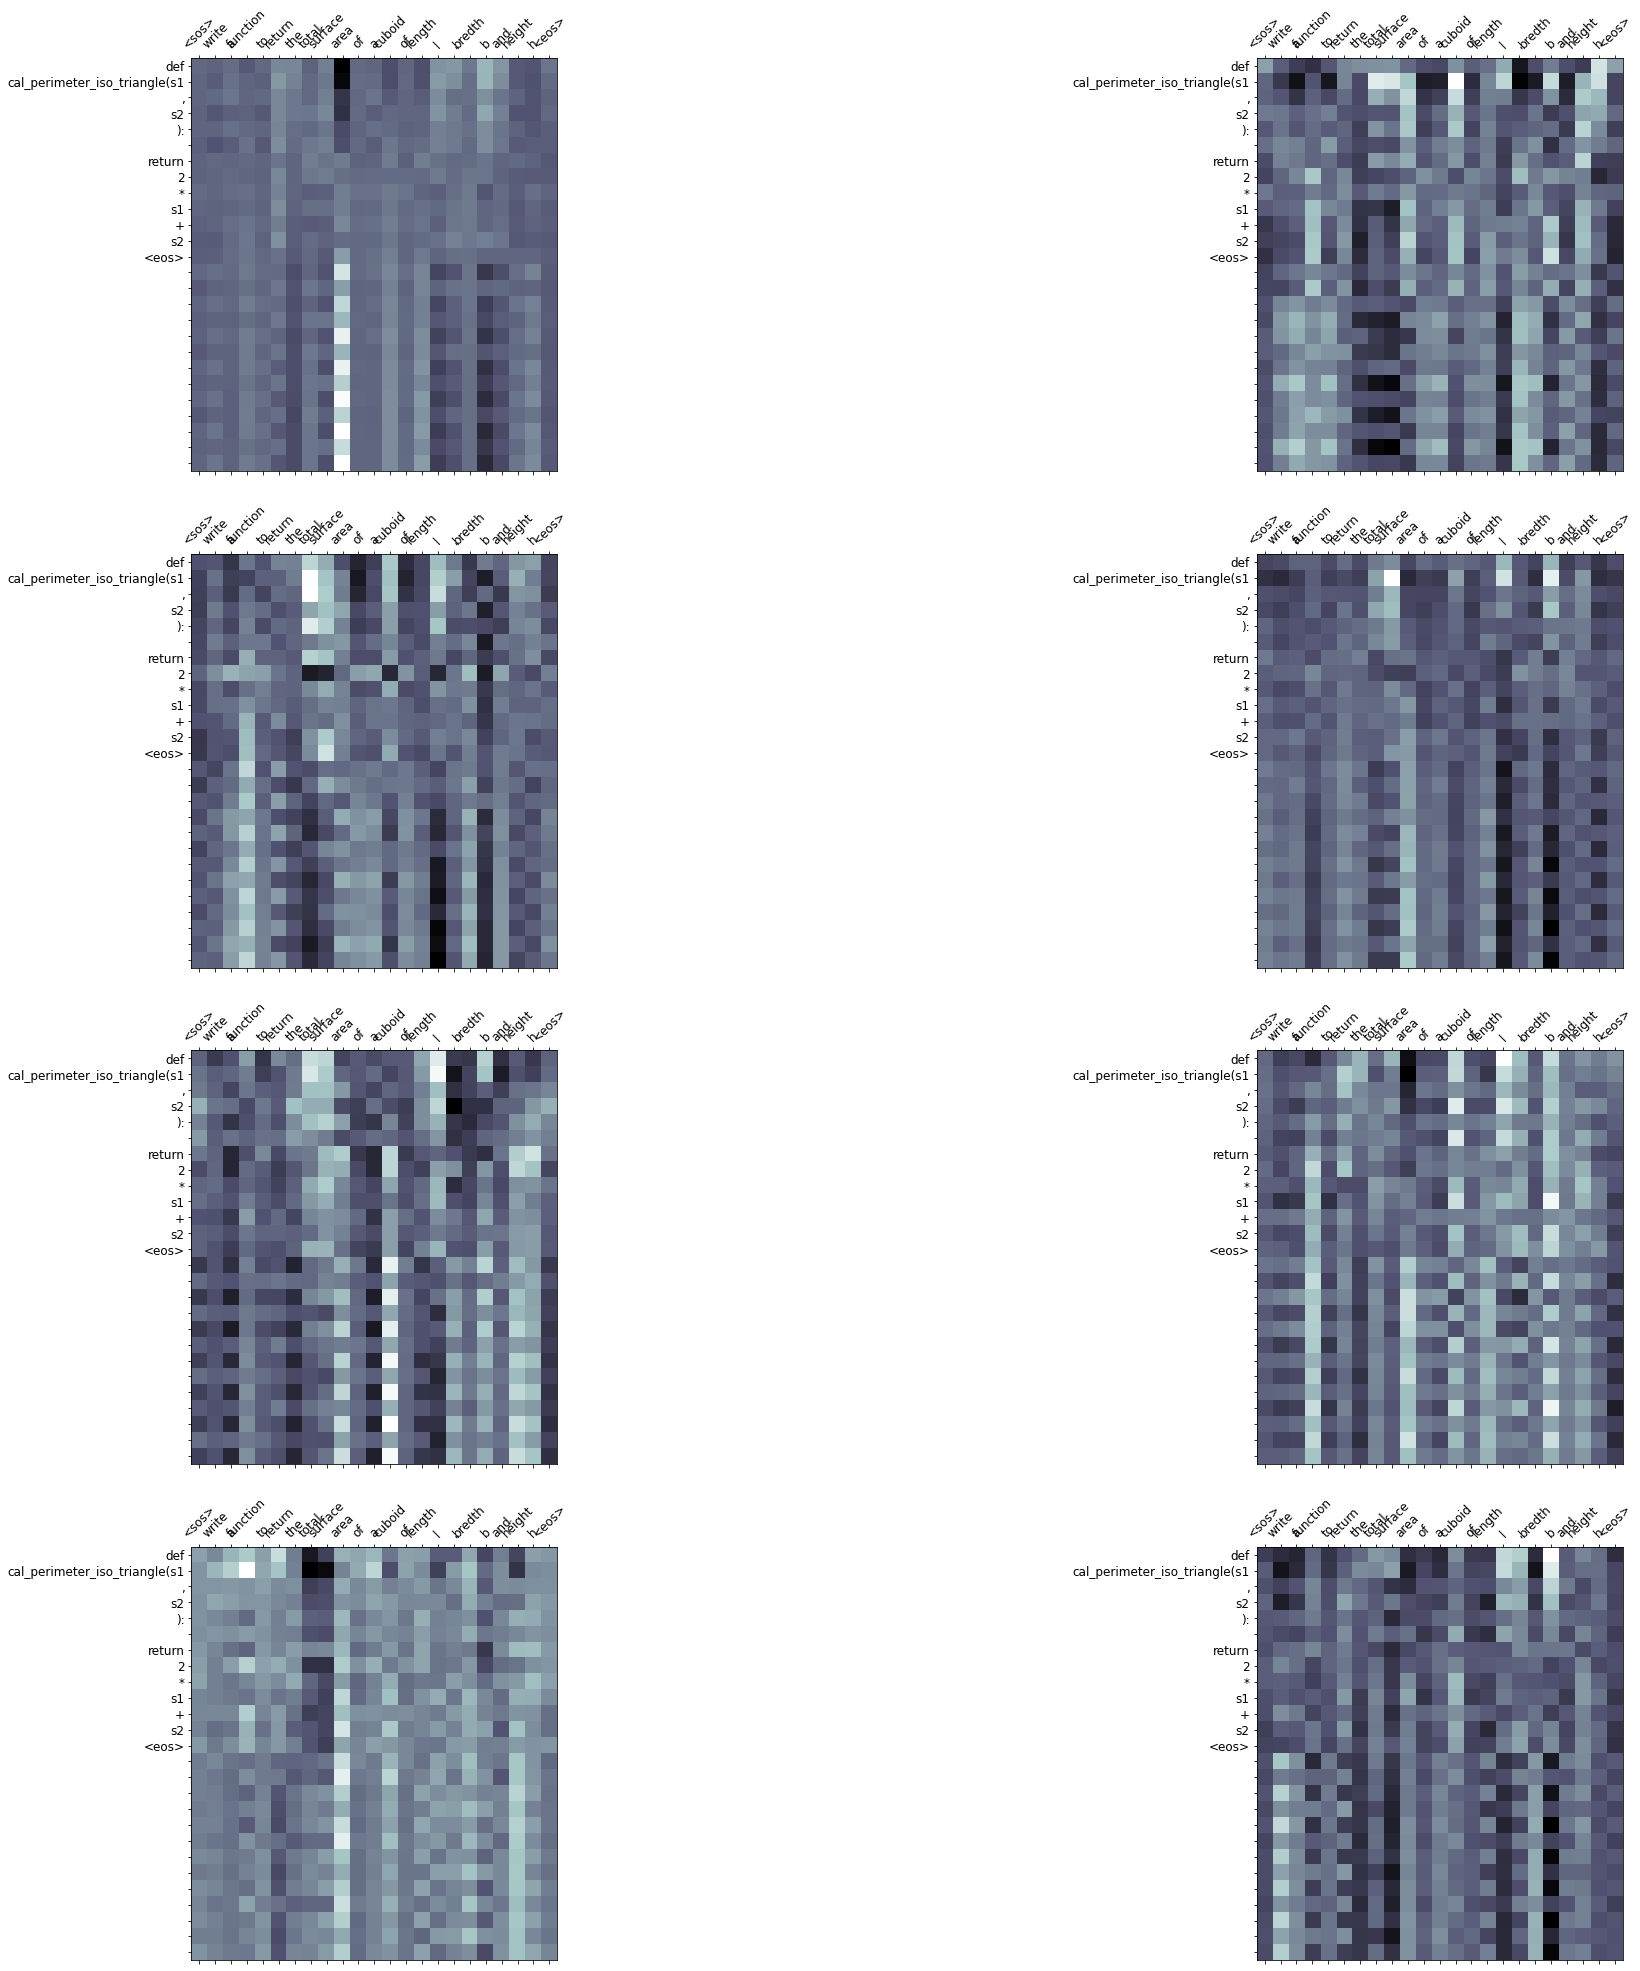

In [94]:
sentence = "write a function to return the total surface area of a cuboid of length l , bredth b and height h"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
def sort_descending(list_to_be_sorted ): 
     return sorted(list_to_be_sorted , reverse = True ) 


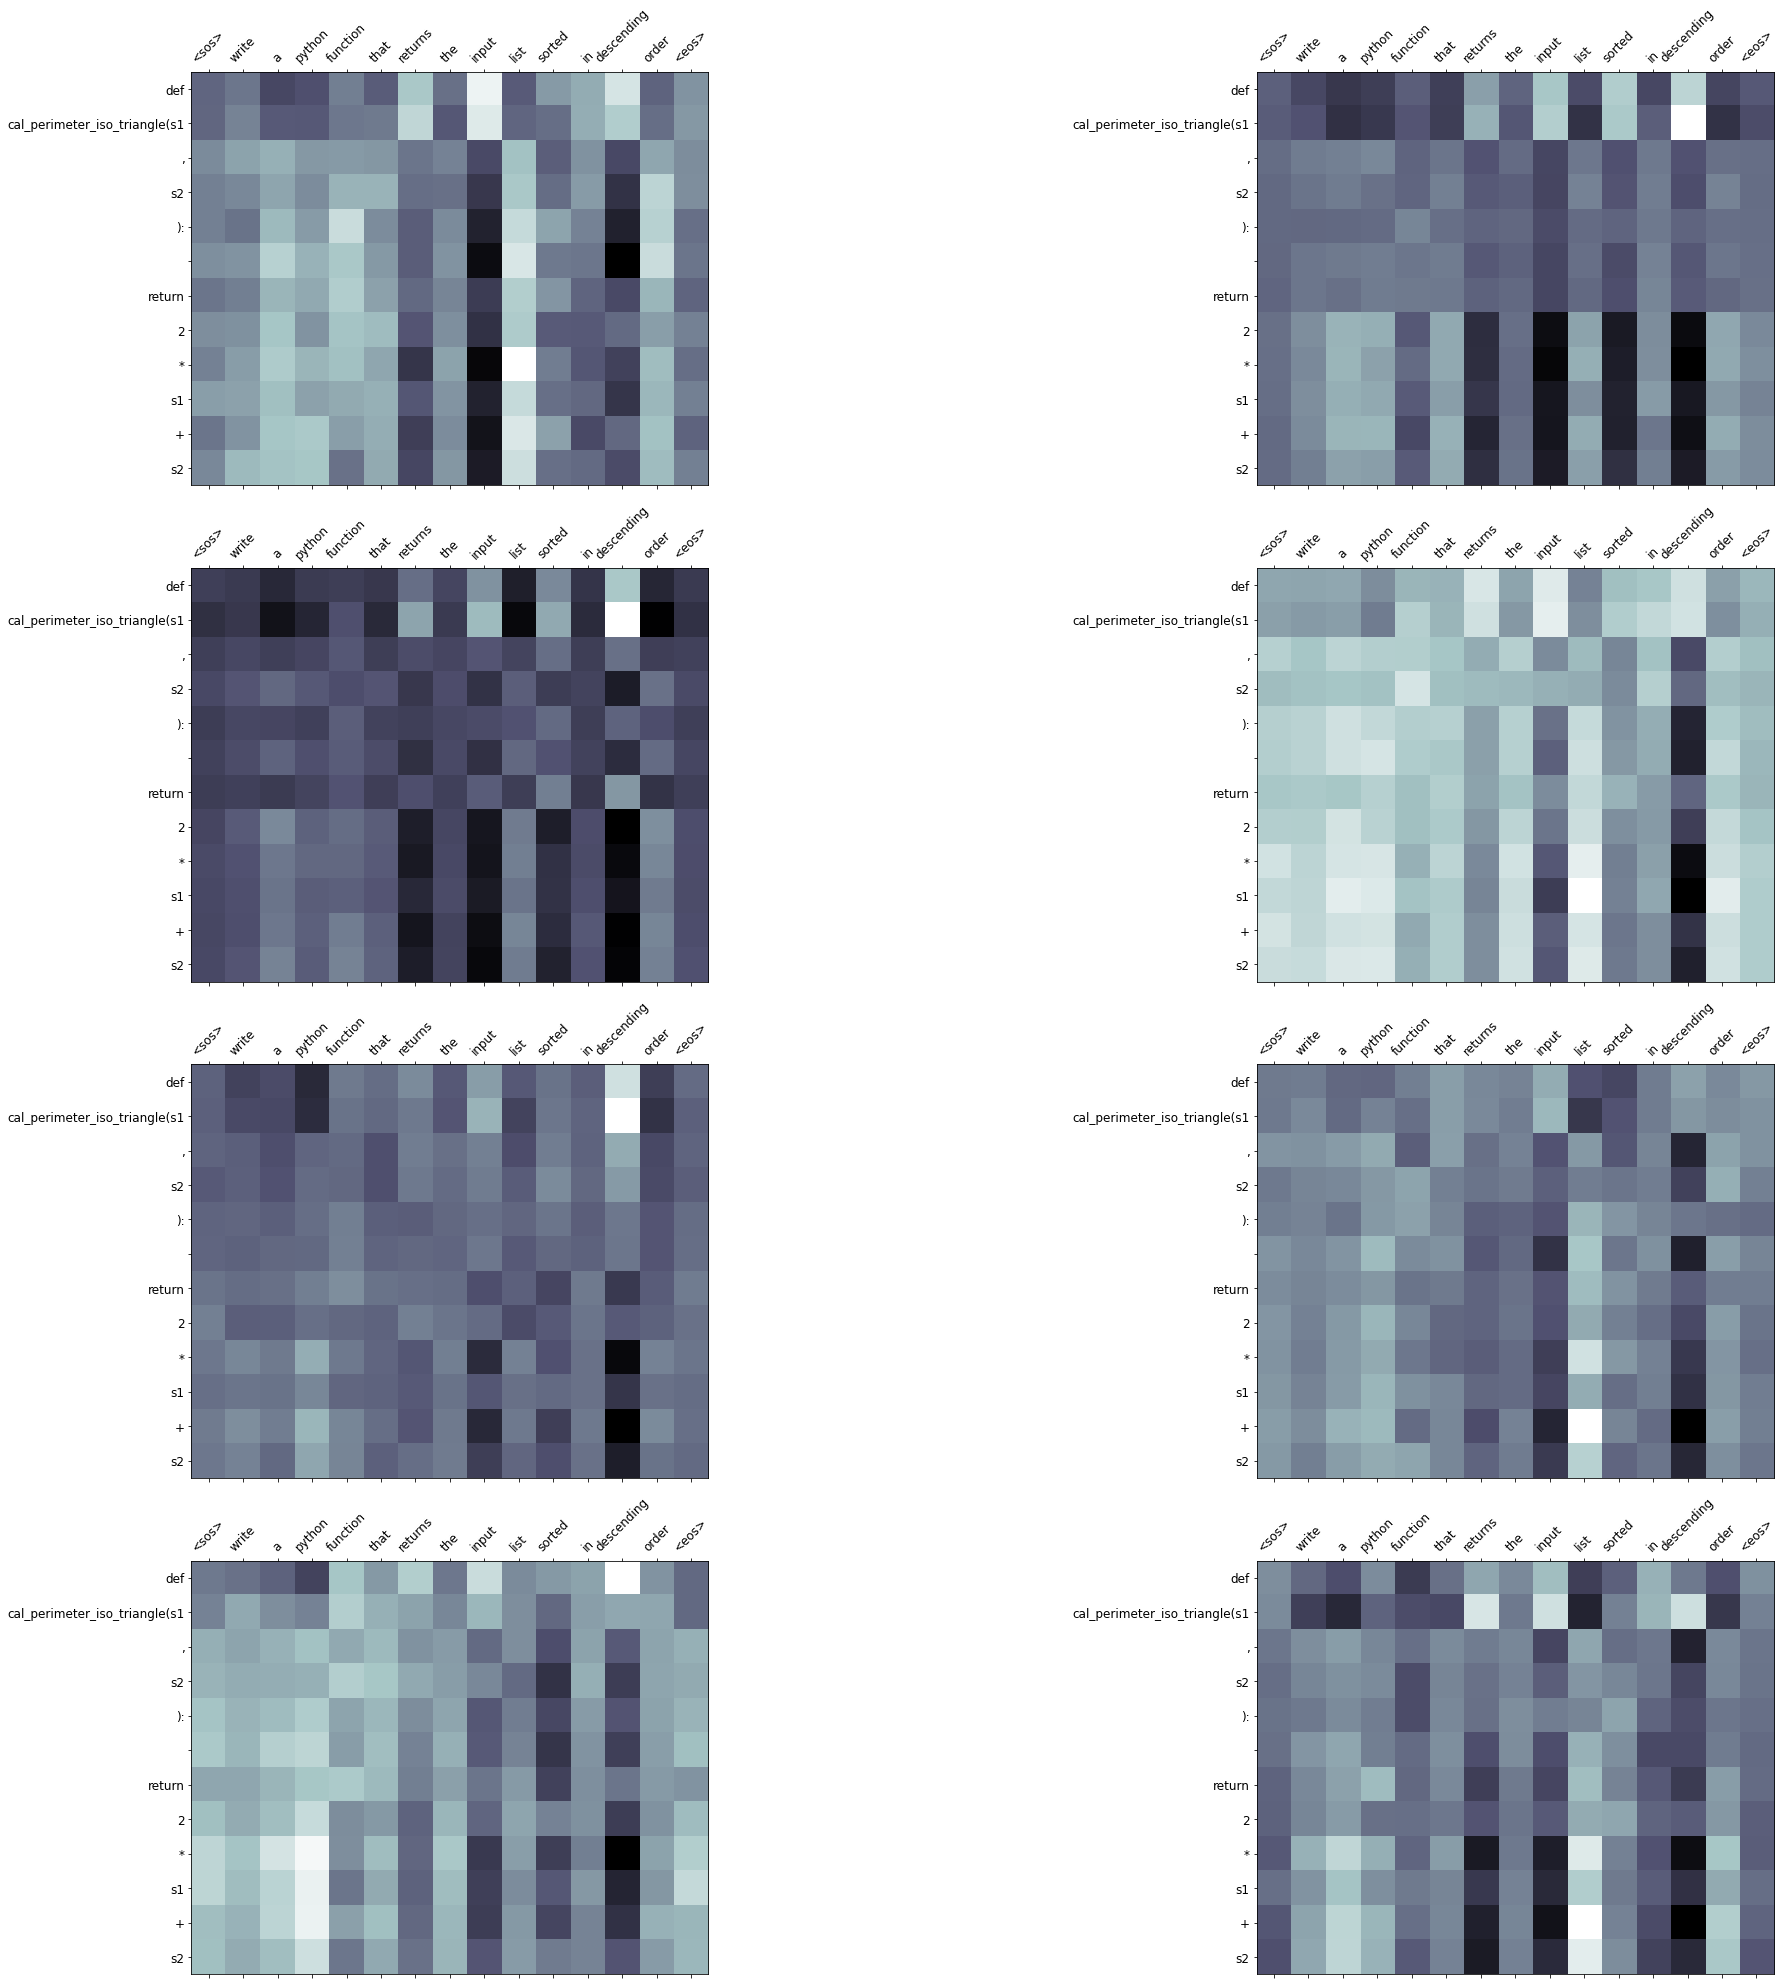

In [95]:
sentence = "write a python function that returns the input list sorted in descending order"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
def Cumulative(lists ): 
     cu_list = [ ] 
     length = len(lists ) 
     cu_list = [ sum(lists[0 : x:1 ] ) for x in range(0 , length + 1 ) ] 
     return cu_list[1 :] 


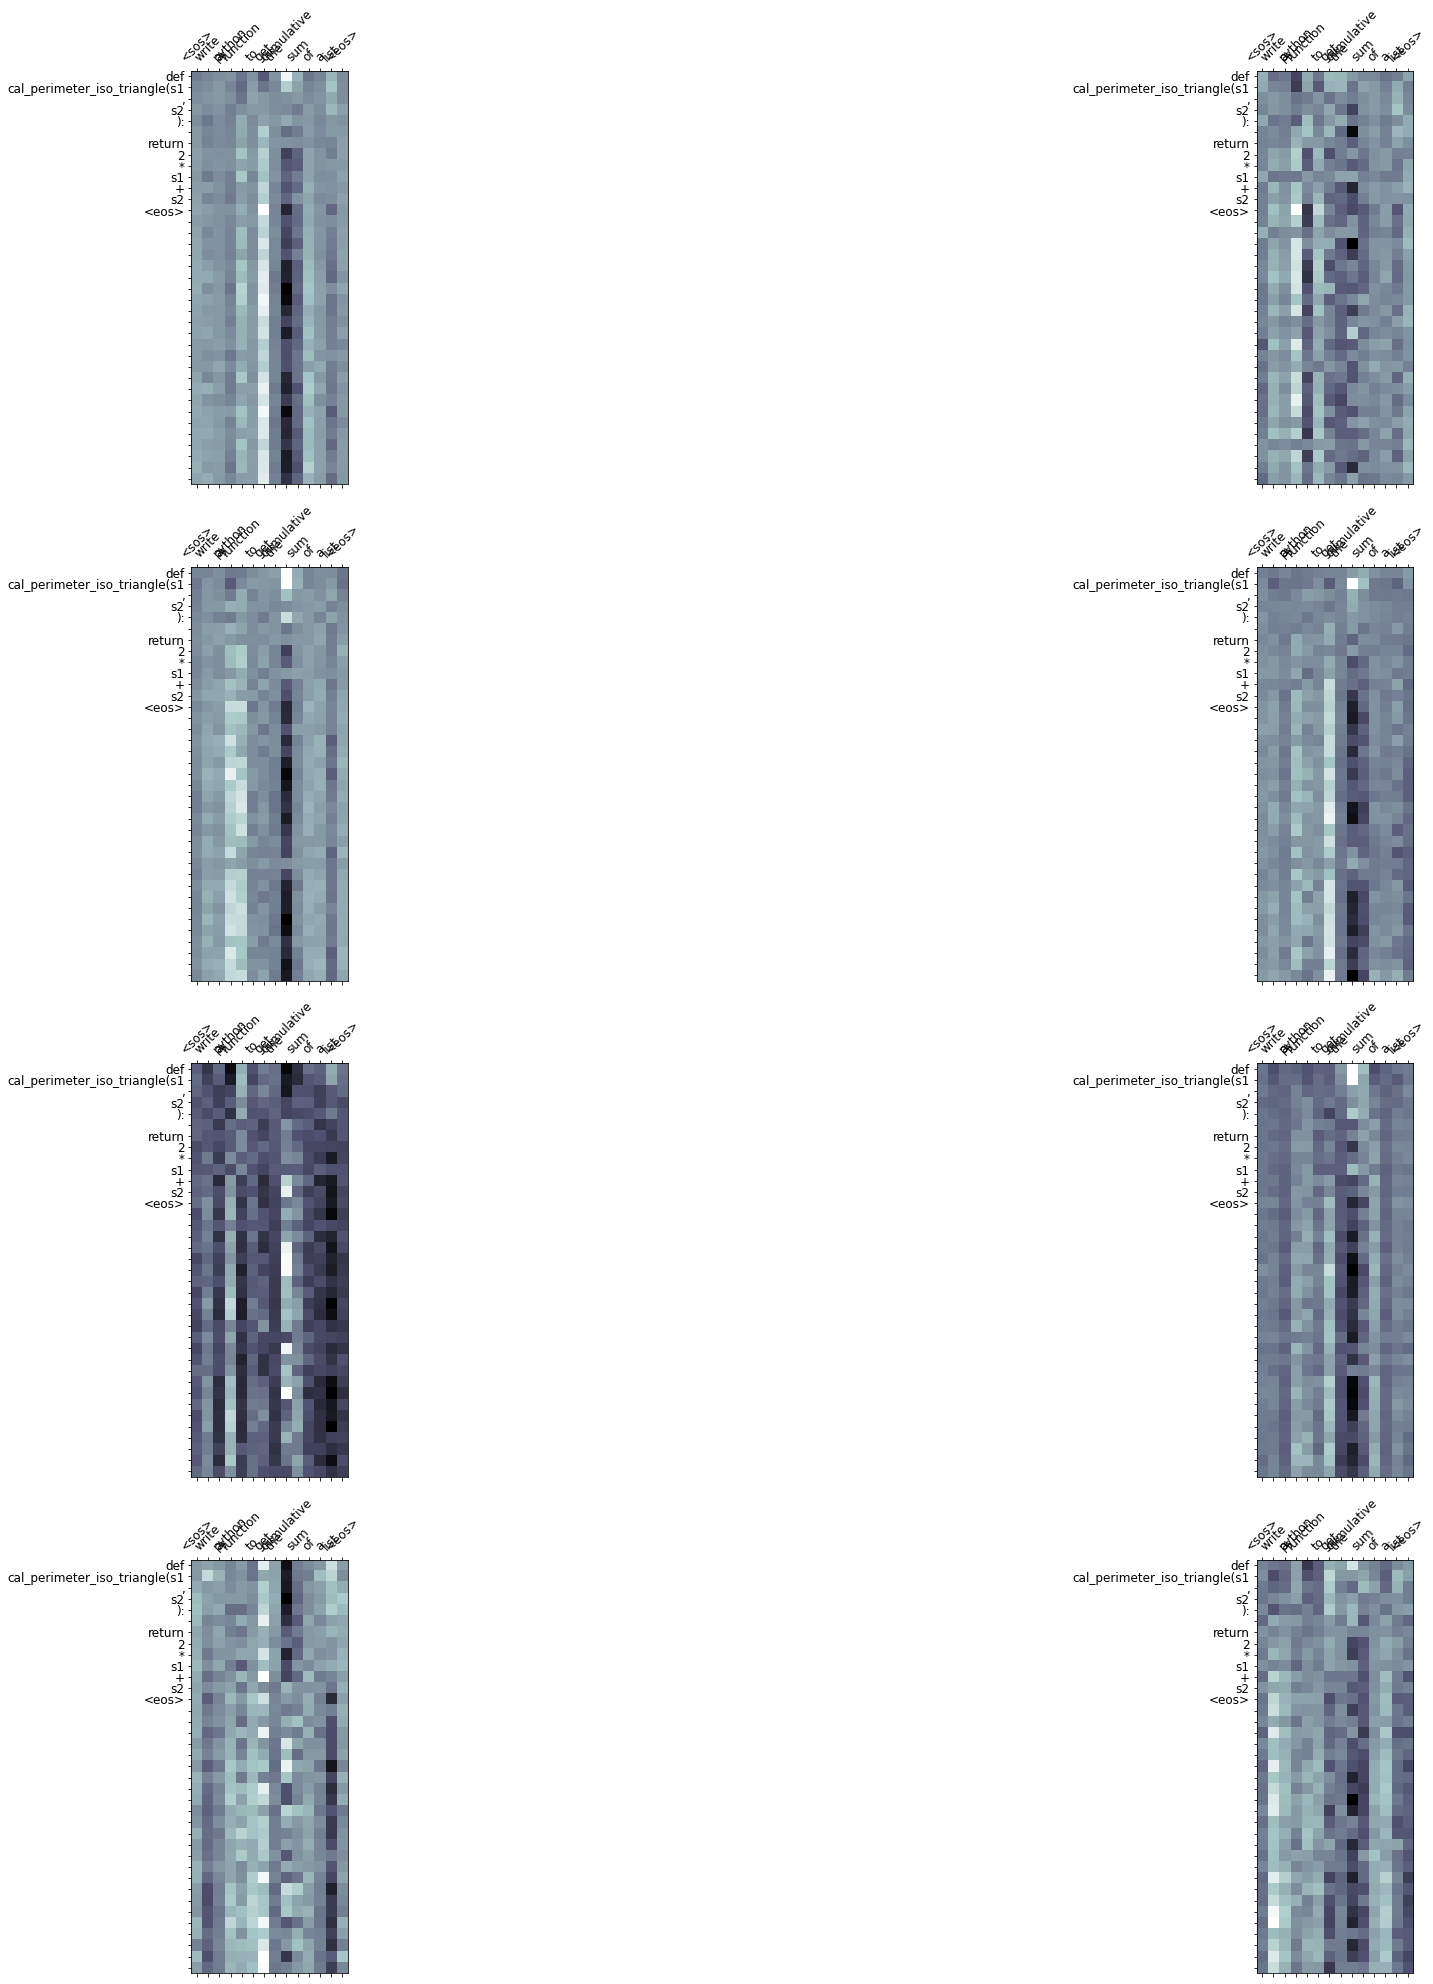

In [96]:
sentence = "write a python function to get the cumulative sum of a list"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:


 def remove(string , n ): 
     first = string[:n ] 
     last = string[n + 1 :] 
     return first + last 


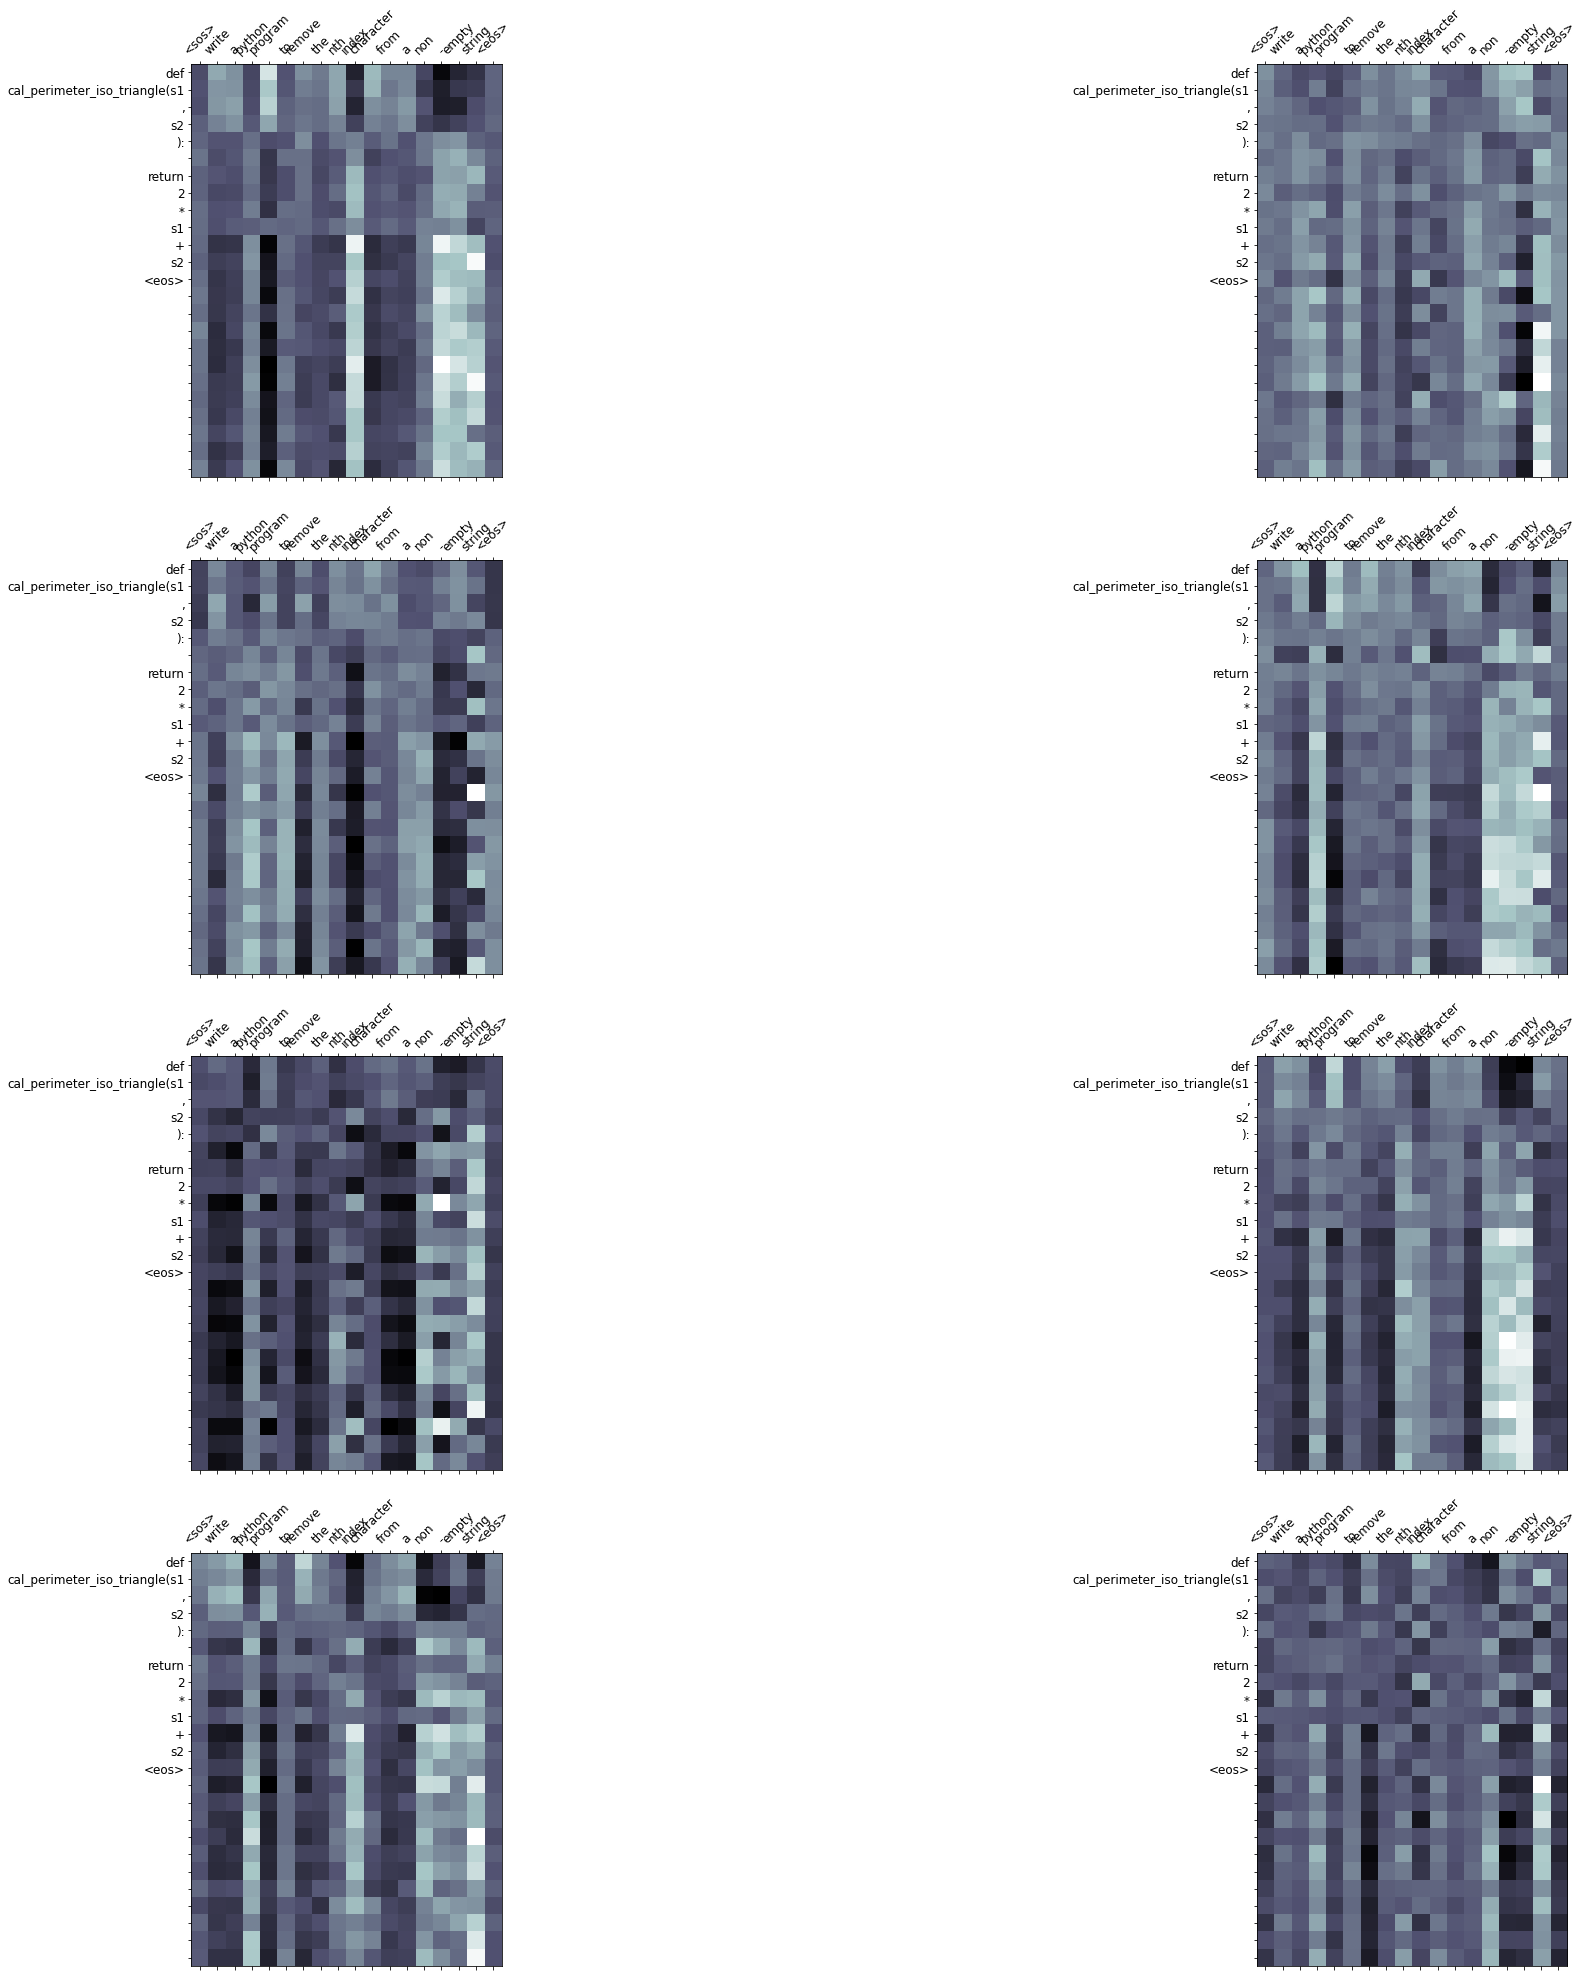

In [97]:
sentence="write a python program to remove the nth index character from a non - empty string"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
def findArea(r ): 
     PI = 3.142 
     return PI * ( r * r ) 


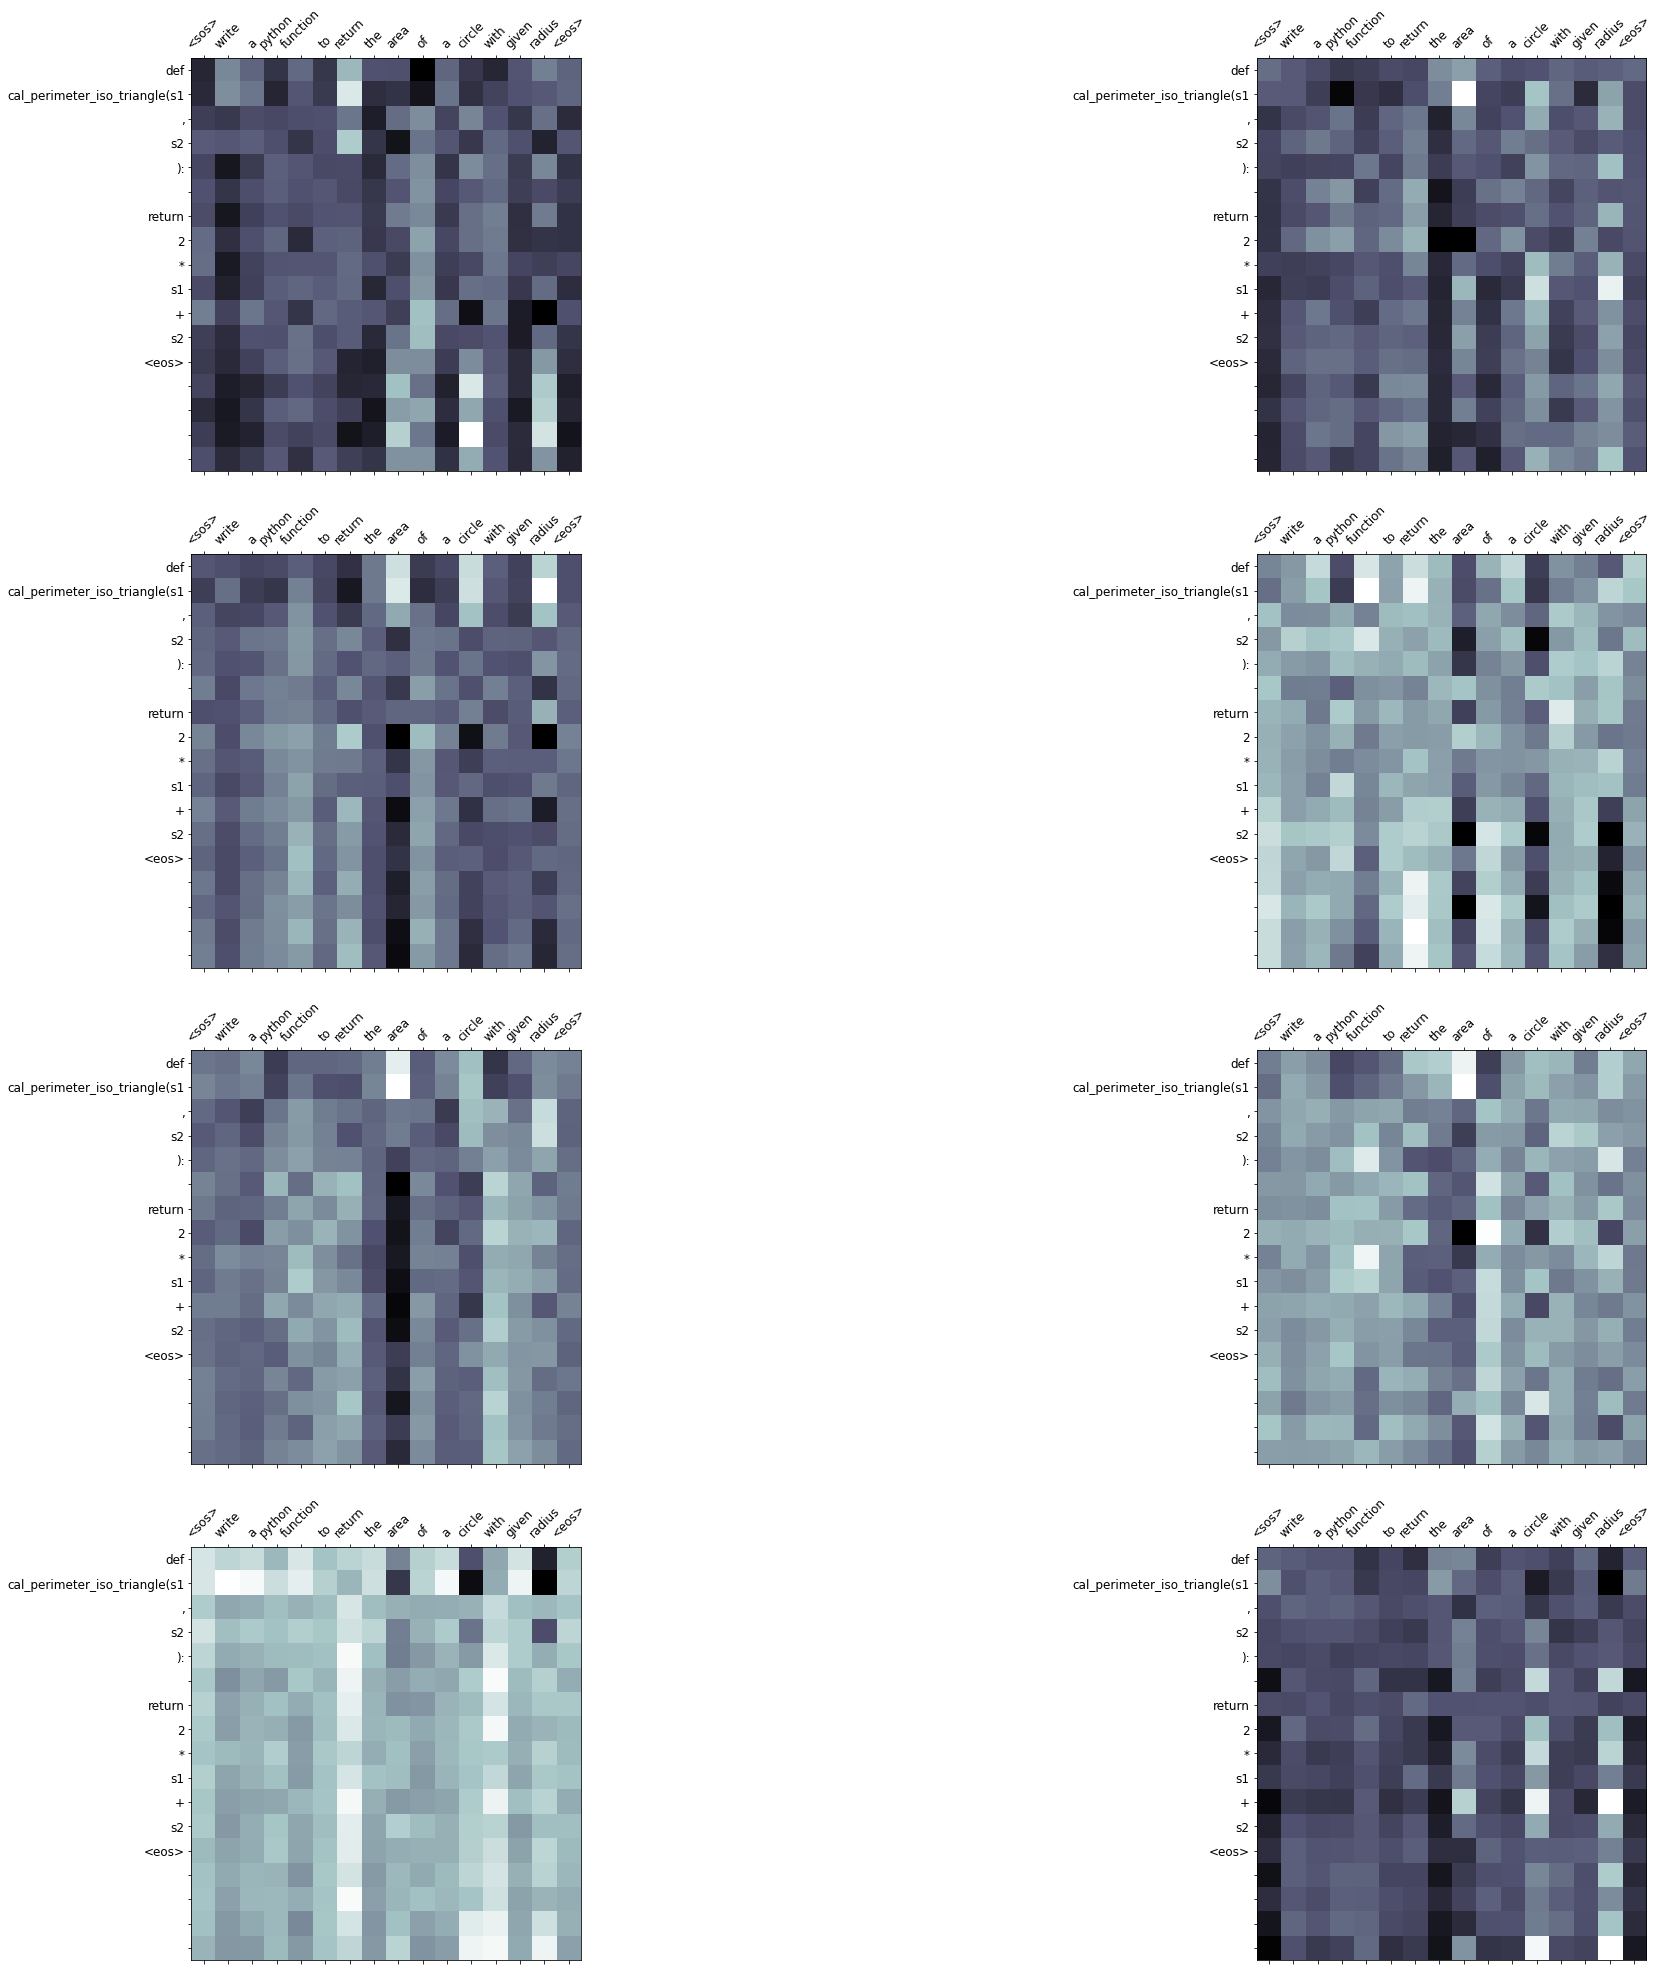

In [98]:
sentence="write a python function to return the area of a circle with given radius"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
import os 
 import <unk> 
 os.cpu_count ( ) 


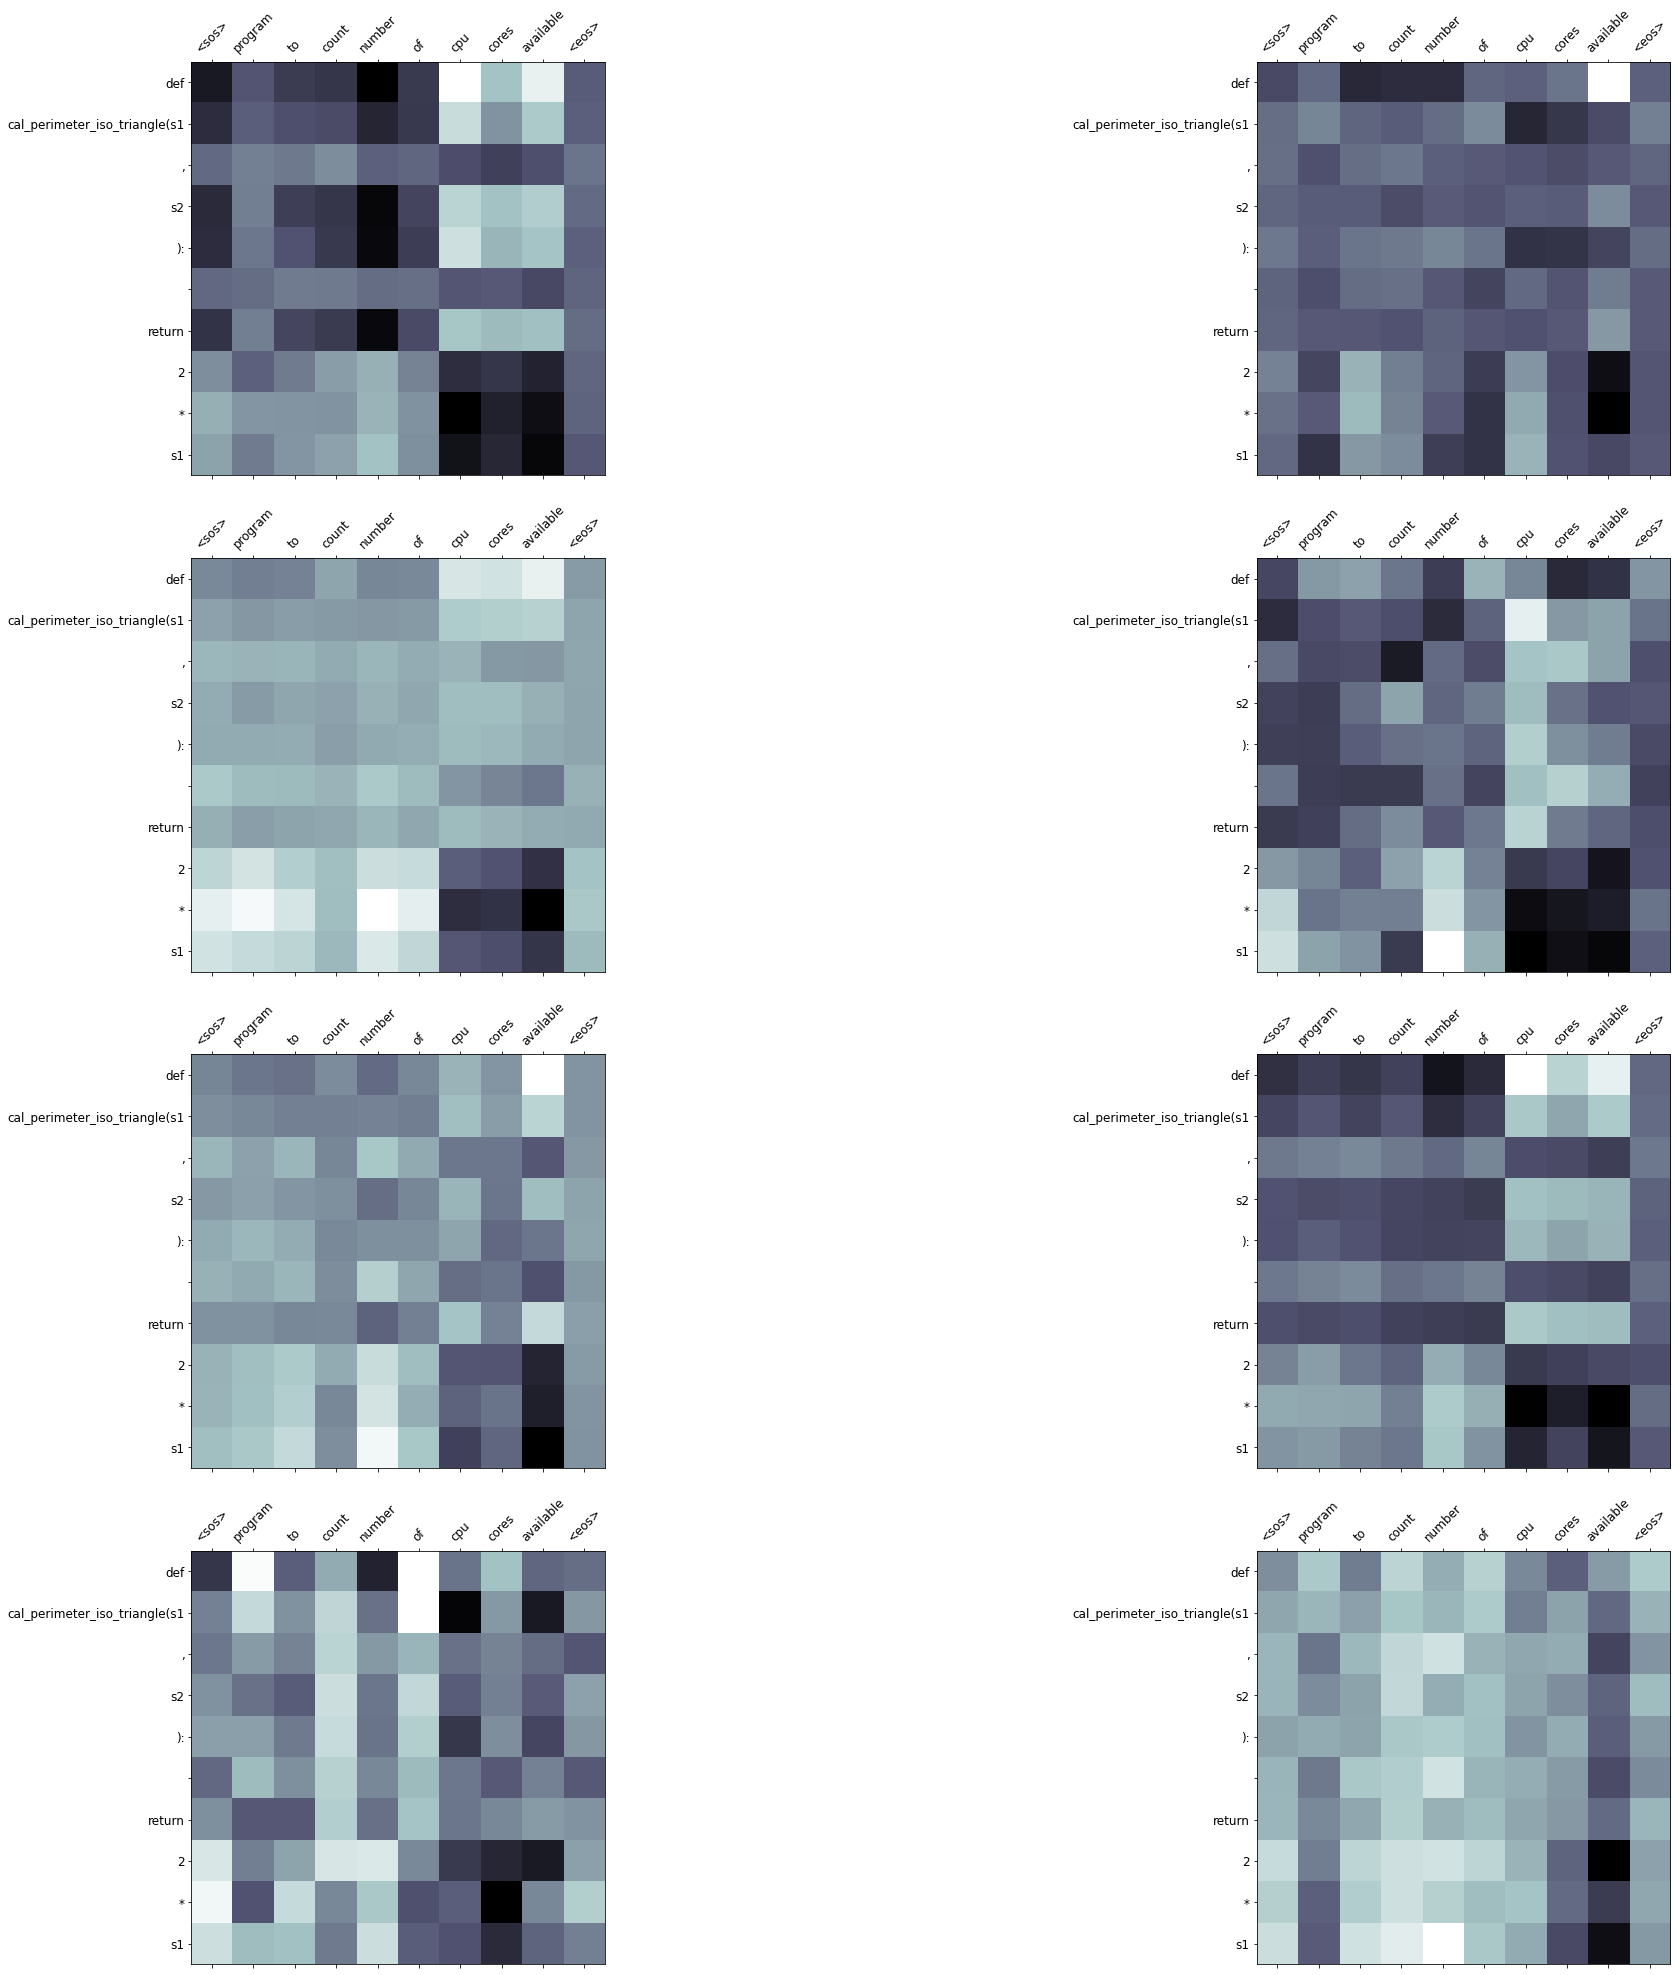

In [99]:
sentence="program to count number of cpu cores available"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
from datetime import datetime , timedelta 
 given_date = datetime(2020 , 2 , 25 ) 
 days_to_subtract = 7 
 res_date = given_date - timedelta(days = days_to_subtract ) 
 print(res_date ) 


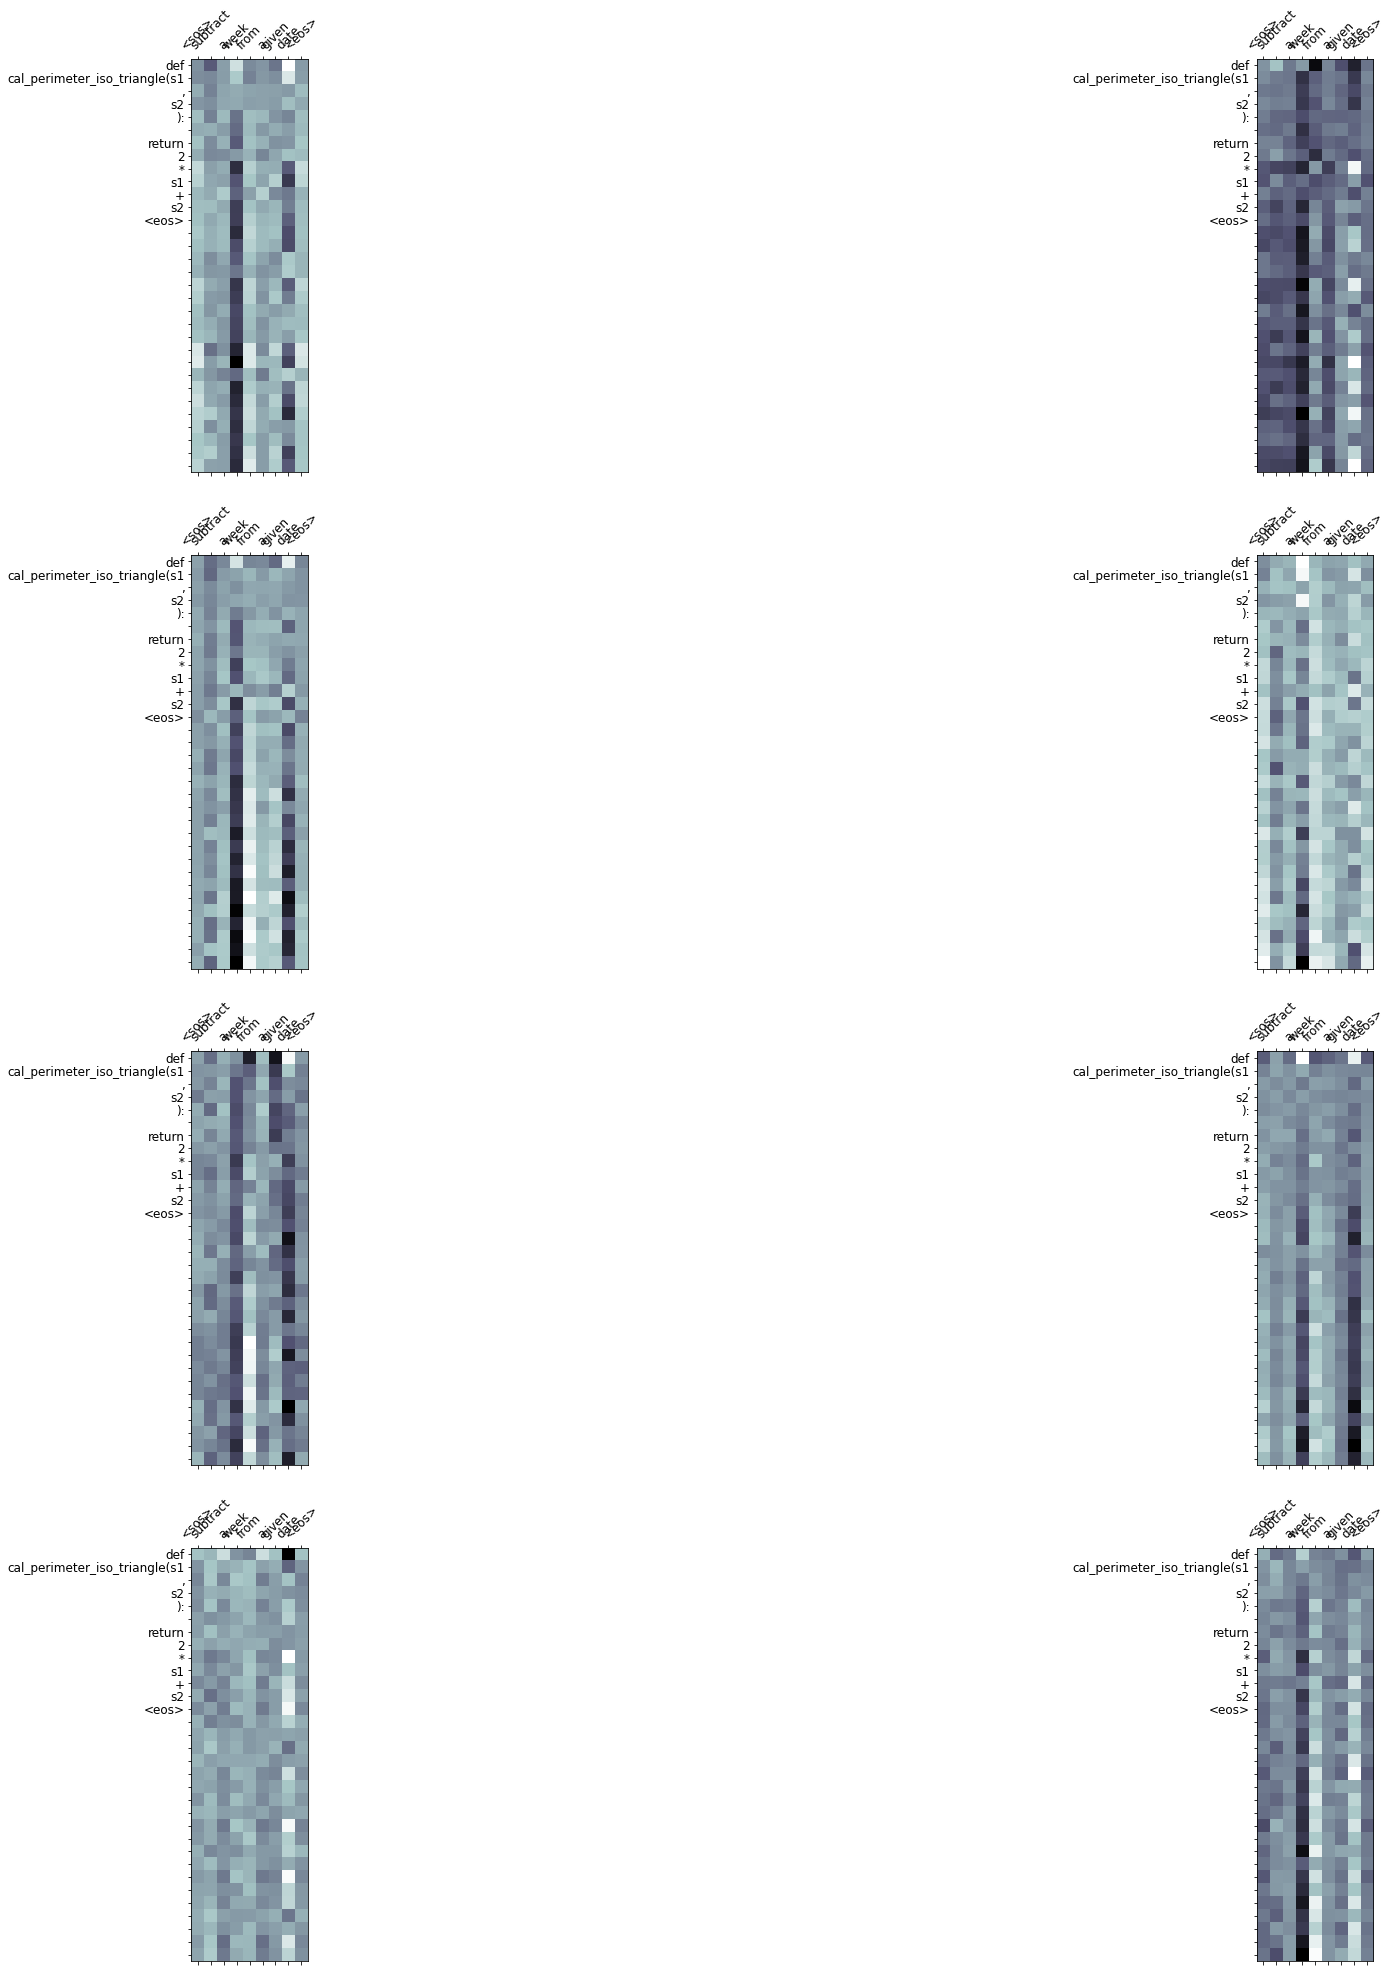

In [100]:
sentence="subtract a week from a given date"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

Generated Code by Model:
currentEmployee = { 1 : ' Scott ' , 2 : " Eric " , 3 : " Kelly " } 
 formerEmployee = { 2 : ' Eric ' , 4 : " Emma " } 
 allEmployee = { * * currentEmployee , * * formerEmployee } 
 print(allEmployee ) 


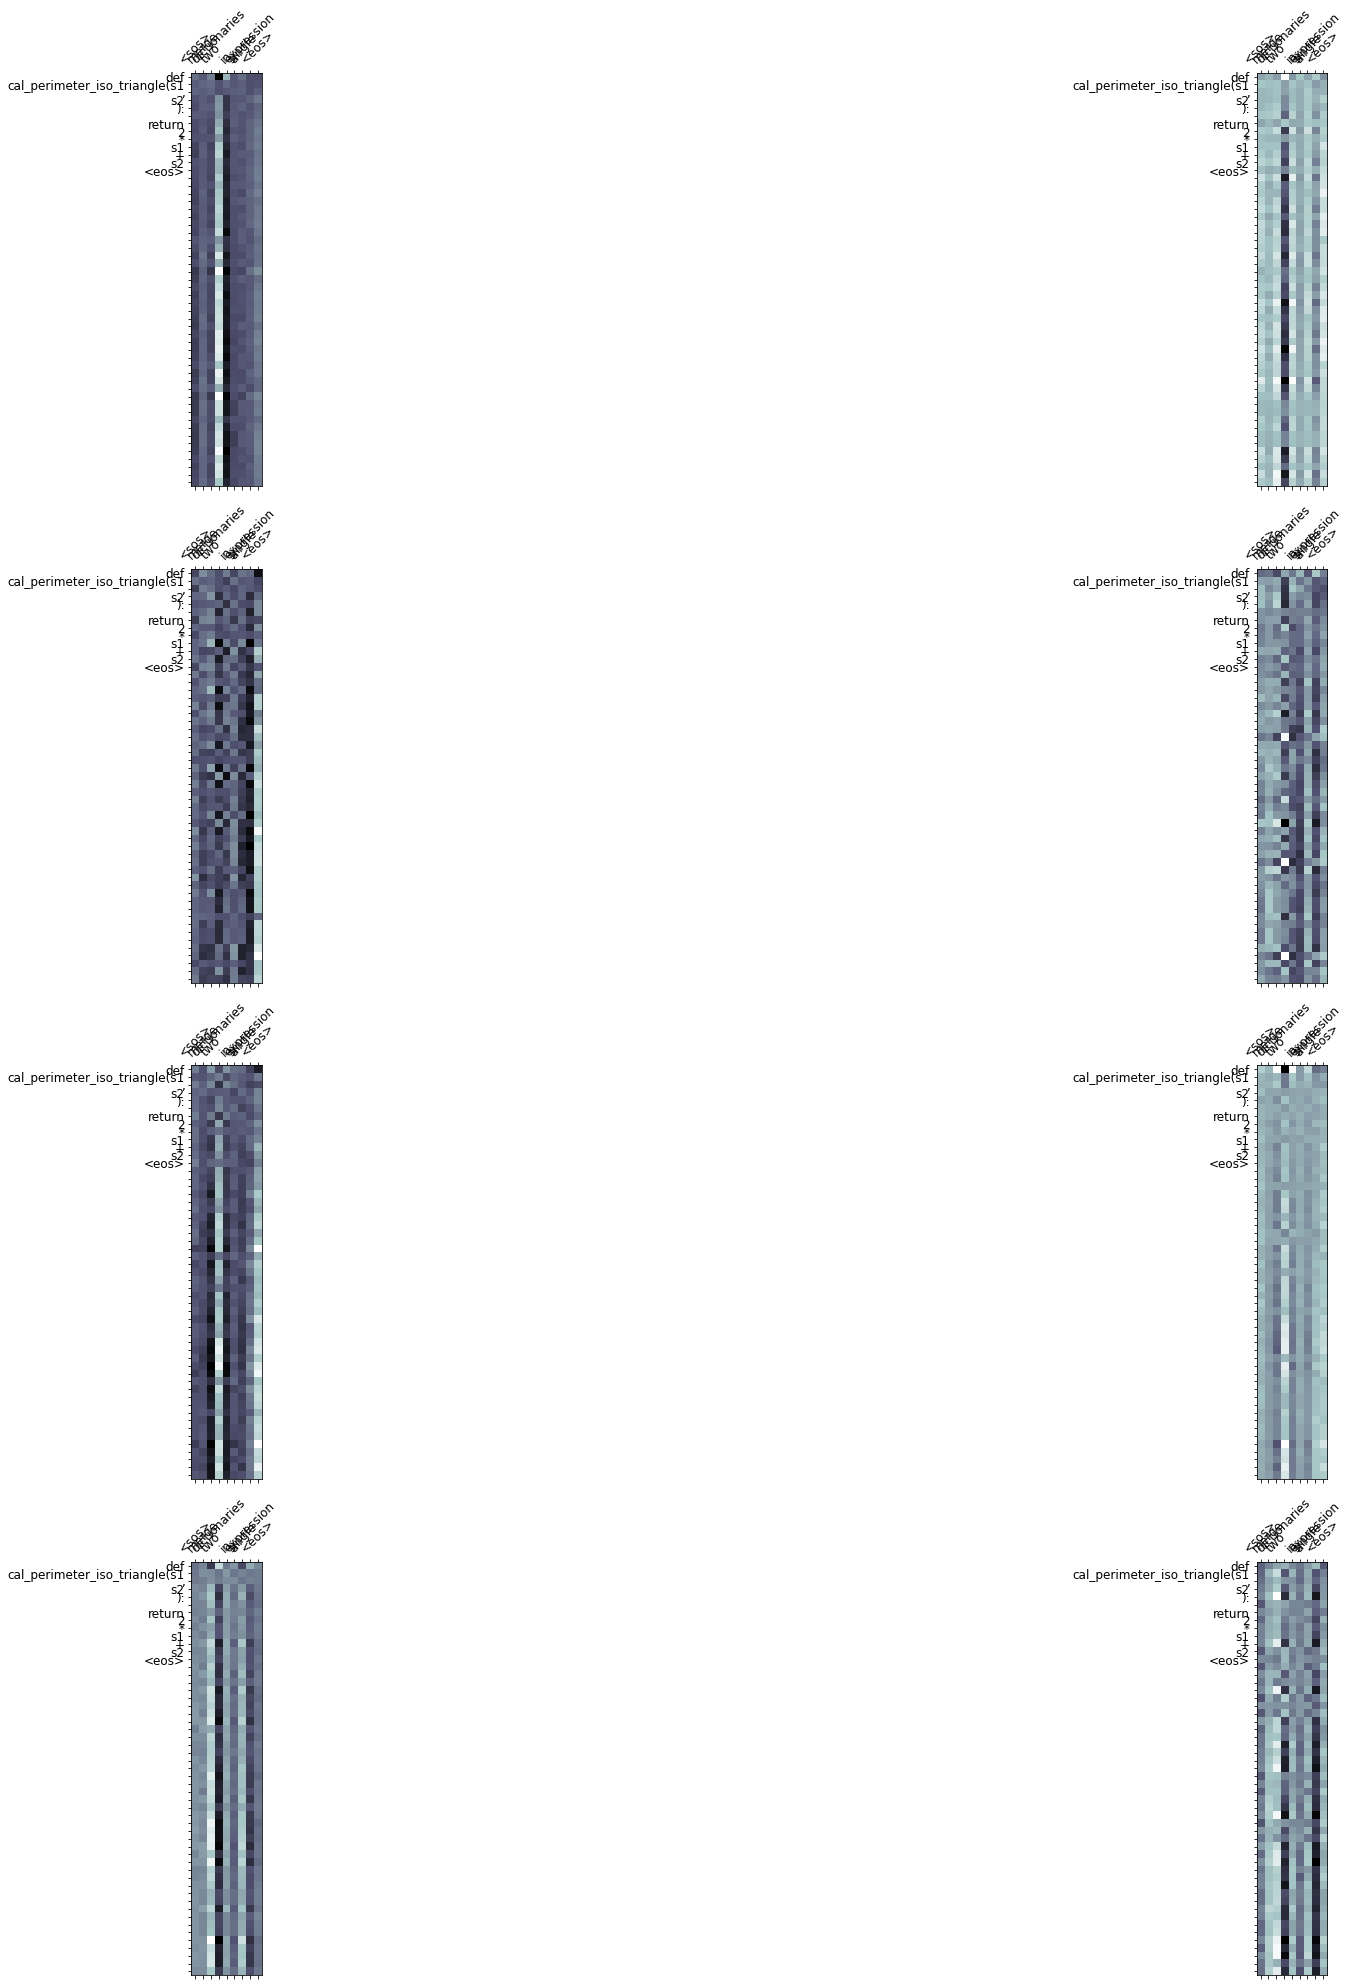

In [101]:
sentence="merge two dictionaries in a single expression"
translation, attention = translate_sentence(sentence, SRC, TRG, model, device)
listToStr = ' '.join([str(elem) for elem in translation]) 
listToStrx = listToStr.replace('<eos>', '')
print(f'Generated Code by Model:\n{listToStrx}')
display_attention(sentence, code, attention)

In [73]:
import random
#Generate 5 random numbers between 10 and 30

randomlist = random.sample(range(0, len(test_act_data)), 400)
for ele in randomlist:
#for ele in range(0,100):
  example_idx = ele
  src = vars(test_act_data.examples[example_idx])['Description']
  trg = vars(test_act_data.examples[example_idx])['Code']
  # print(f'src = {src}')
  listToStr = ' '.join([str(elem) for elem in src]) 
  print(f'Description: {listToStr}')

  listToStr = ' '.join([str(elem) for elem in trg]) 
  print(f'Source Code:\n{listToStr}')
  
  print(f'\n')
  # print(f'\n')
  # print(f'trg = {trg}')
  listToStr = ' '.join([str(elem) for elem in trg]) 
  translation, attention = translate_sentence(src, SRC, TRG, model, device)
  listToStr = ' '.join([str(elem) for elem in translation]) 
  listToStrx = listToStr.replace('<eos>', '')
  print(f'Generated Code by Model:\n{listToStrx}')
  print('#########################################################################################################')
  print('#########################################################################################################')

Streaming output truncated to the last 5000 lines.
     else : 
         return ' no profit or loss ' , 0 
#########################################################################################################
#########################################################################################################
Description: write a python function to get the surface_area of a cylinder with radius & height as input
Source Code:
def cylinder_surface_area(radius , height ): 
     surface_area=3.14 * ( radius * * 2 ) + ( 2 * 3.14 * radius * height ) 
     return surface_area


Generated Code by Model:
def <unk> , radius ): 
     pi = 3.14 
     return pi * ( radius**2 ) * height 
#########################################################################################################
#########################################################################################################
Description: write a program to convert date to timestamp and print the result
Source Code:
impor